In [1]:
import sys
import importlib
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import random
import optuna
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
base_path = "../src/"
sys.path.append(base_path)
import models
import train
from losses import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
datafilename='../../DATA/data_L25LH_TNG.hdf5'
#datafilename='../../DATA/data_L50_TNG_v3.hdf5'
with h5py.File(datafilename, 'r') as f:
    print("Datasets available:")
    for key in f.keys():
        print(key)

with h5py.File(datafilename, 'r') as f:
    #Parameters = f['Parameters'][0, :1024].T.reshape(-1, 1)
    Parameters = f['Parameters'][:, :1024].T
#logflag = np.array([False])
#logflag = np.array([False, False, True, True, True, True])
logflag = np.array([False, False, True, True, True, True, False, False, False, True, True, False, False, True, False, True, False, True, True, False, False, True, True, True, True, True, True, False, True, False, True, False, False, False, True])
logflag = logflag[:Parameters.shape[1]]
origParameters = Parameters
if not np.all(Parameters[:, logflag] > 0):
    raise ValueError("Some values to be logged are non-positive.")
PartiallyLoggedParameters = Parameters.copy()
PartiallyLoggedParameters[:, logflag] = np.log(PartiallyLoggedParameters[:, logflag])
means = PartiallyLoggedParameters.mean(axis=0)
stds = PartiallyLoggedParameters.std(axis=0)
Parameters = (PartiallyLoggedParameters - means) / stds
#print(Parameters.shape)
#print(Parameters.dtype)
#print(Parameters.min(axis=0))
#print(Parameters.max(axis=0))

with h5py.File(datafilename, 'r') as f:
    Ms_Mh_s90 = f['Ms_Mh_s90'][:].T
    Ms_Mh_s61 = f['Ms_Mh_s61'][:].T
    MBH_Mh_s90 = f['MBH_Mh_s90'][:].T
    MBH_Mh_s61 = f['MBH_Mh_s61'][:].T
    Mg_Mh_s90 = f['Mg_Mh_s90'][:].T
    Mg_Mh_s61 = f['Mg_Mh_s61'][:].T
    Rs_Ms_s90 = f['Rs_Ms_s90'][:].T
    Rs_Ms_s61 = f['Rs_Ms_s61'][:].T
    SFR_Ms_s90 = f['SFR_Ms_s90'][:].T
    SFR_Ms_s61 = f['SFR_Ms_s61'][:].T
    Zs_Ms_s90 = f['Zs_Ms_s90'][:].T
    Zs_Ms_s61 = f['Zs_Ms_s61'][:].T
    SFRH_100Myr = f['SFRH_100Myr'][:].T

Datasets available:
MBH_Mh_s61
MBH_Mh_s90
Mg_Mh_s61
Mg_Mh_s90
Ms_Mh_s61
Ms_Mh_s90
Parameters
Rs_Ms_s61
Rs_Ms_s90
SFRH_100Myr
SFRH_z
SFR_Ms_s61
SFR_Ms_s90
Zs_Ms_s61
Zs_Ms_s90
logMh_s61
logMh_s90
logMs_s61
logMs_s90


In [4]:
#x = torch.from_numpy(Ms_Mh_s90).float()
x = torch.cat((torch.from_numpy(Ms_Mh_s90), torch.from_numpy(Ms_Mh_s61)), dim=1).float()
#x = torch.cat((torch.from_numpy(Ms_Mh_s90), torch.from_numpy(Ms_Mh_s61), torch.from_numpy(MBH_Mh_s90), torch.from_numpy(MBH_Mh_s61), torch.from_numpy(Mg_Mh_s90), torch.from_numpy(Mg_Mh_s61)), dim=1).float()
#x = torch.cat((torch.from_numpy(Ms_Mh_s90), torch.from_numpy(Ms_Mh_s61), torch.from_numpy(MBH_Mh_s90), torch.from_numpy(MBH_Mh_s61), torch.from_numpy(Mg_Mh_s90), torch.from_numpy(Mg_Mh_s61), torch.from_numpy(Rs_Ms_s90), torch.from_numpy(Rs_Ms_s61), torch.from_numpy(SFR_Ms_s90), torch.from_numpy(SFR_Ms_s61), torch.from_numpy(Zs_Ms_s90), torch.from_numpy(Zs_Ms_s61), torch.from_numpy(SFRH_100Myr)), dim=1).float()

normalize_inputs = True

if normalize_inputs:
    x_np = x.numpy()
    x_means = x_np.mean(axis=0)
    x_stds = x_np.std(axis=0)
    x_np_norm = (x_np - x_means) / x_stds
    x = torch.from_numpy(x_np_norm).float()


print("Total NaNs:", torch.isnan(x).sum().item())
print("Total Infs:", torch.isinf(x).sum().item())
x[torch.isnan(x)] = 11
x[torch.isinf(x)] = 11
print("Total NaNs:", torch.isnan(x).sum().item())
print("Total Infs:", torch.isinf(x).sum().item())
y = torch.from_numpy(Parameters).float()
print(x.shape)
print(y.shape)
#print(x.dtype)
#print(y.dtype)
#print(x[1:3,:])
#print(y[1:3,:])

Total NaNs: 0
Total Infs: 0
Total NaNs: 0
Total Infs: 0
torch.Size([1000, 28])
torch.Size([1000, 6])


In [5]:
importlib.reload(train)
importlib.reload(models)

<module 'models' from '/Users/nicolasgarcia/Downloads/GAL_SBI/camelsPE/jupyter_notebook/../src/models.py'>

In [6]:
def objective(trial):
    # --- Hyperparameter ranges ---
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    wd = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32])
    n_layers = trial.suggest_int("n_layers", 1,3)
    hidden_dims = [trial.suggest_int(f"n_units_l{i+1}", 32, 256) for i in range(n_layers)]
    
    # Reproducibility
    seed = 10
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Dataset (x and y must be defined in global scope)
    full_dataset = TensorDataset(x, y)
    n_val = int(len(full_dataset) * 0.1)
    n_train = len(full_dataset) - n_val
    train_ds, val_ds = random_split(full_dataset, [n_train, n_val])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    # Safe input/output dim inference
    input_dim = x.shape[1] if x.ndim > 1 else 1
    output_dim = y.shape[1] if y.ndim > 1 else 1

    # Model
    model = models.SimpleMLP(input_dim, hidden_dims, output_dim, dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=100)

    try:
        train_losses, val_losses = train.fit(
            model, train_loader, val_loader,
            optimizer, criterion, device,
            epochs=1000, scheduler=scheduler
        )
    except Exception as e:
        print(f"Trial failed with error: {e}")
        return float("inf")

    return val_losses[-1]


In [7]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1000)

[I 2025-06-23 03:12:47,992] A new study created in memory with name: no-name-5f9c6a93-ea75-4dd2-adf5-b8fdc3ff73ea


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4895


[I 2025-06-23 03:14:47,562] Trial 0 finished with value: 0.44895926117897034 and parameters: {'lr': 1.1967839627784094e-05, 'weight_decay': 0.0003709612224569461, 'dropout_rate': 0.16721558792037372, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 136, 'n_units_l2': 167, 'n_units_l3': 177}. Best is trial 0 with value: 0.44895926117897034.


[Iter 1000] validation loss: 0.4490


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4283


[I 2025-06-23 03:17:43,508] Trial 1 finished with value: 0.43138899547713144 and parameters: {'lr': 0.0017298068349183508, 'weight_decay': 5.8480177740726e-05, 'dropout_rate': 0.3649826187322623, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 199, 'n_units_l2': 82}. Best is trial 1 with value: 0.43138899547713144.


[Iter 1000] validation loss: 0.4314


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.5731


[I 2025-06-23 03:19:11,821] Trial 2 finished with value: 0.49920302629470825 and parameters: {'lr': 1.3072426116770412e-05, 'weight_decay': 0.0007383345432277469, 'dropout_rate': 0.3272739596502865, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 90, 'n_units_l2': 95, 'n_units_l3': 207}. Best is trial 1 with value: 0.43138899547713144.


[Iter 1000] validation loss: 0.4992


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.5372


[I 2025-06-23 03:22:16,760] Trial 3 finished with value: 0.5393909982272557 and parameters: {'lr': 0.0033506946465378137, 'weight_decay': 1.3899921522859005e-05, 'dropout_rate': 0.10870741707403747, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 233, 'n_units_l2': 185, 'n_units_l3': 224}. Best is trial 1 with value: 0.43138899547713144.


[Iter 1000] validation loss: 0.5394


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3982


[I 2025-06-23 03:23:09,782] Trial 4 finished with value: 0.433844231069088 and parameters: {'lr': 0.0002905583495406156, 'weight_decay': 7.064059851546591e-06, 'dropout_rate': 0.059029311848998456, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 200, 'n_units_l2': 116}. Best is trial 1 with value: 0.43138899547713144.


[Iter 1000] validation loss: 0.4338


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4032


[I 2025-06-23 03:23:59,878] Trial 5 finished with value: 0.4356474280357361 and parameters: {'lr': 0.0008508554542090192, 'weight_decay': 0.00021459973861028285, 'dropout_rate': 0.14980674394709054, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 178, 'n_units_l2': 53}. Best is trial 1 with value: 0.43138899547713144.


[Iter 1000] validation loss: 0.4356


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4677


[I 2025-06-23 03:24:35,038] Trial 6 finished with value: 0.4415101536682674 and parameters: {'lr': 6.89015262470101e-05, 'weight_decay': 2.256994970090537e-06, 'dropout_rate': 0.24054048877911283, 'batch_size': 16, 'n_layers': 1, 'n_units_l1': 39}. Best is trial 1 with value: 0.43138899547713144.


[Iter 1000] validation loss: 0.4415


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3956


[I 2025-06-23 03:25:29,711] Trial 7 finished with value: 0.40090128779411316 and parameters: {'lr': 0.0002459309823221056, 'weight_decay': 0.00030862829955505684, 'dropout_rate': 0.18863463106444917, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 217, 'n_units_l2': 115}. Best is trial 7 with value: 0.40090128779411316.


[Iter 1000] validation loss: 0.4009


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4311


[I 2025-06-23 03:26:19,541] Trial 8 finished with value: 0.42234963178634644 and parameters: {'lr': 0.00038222035611876014, 'weight_decay': 0.0005230485870155217, 'dropout_rate': 0.40795525440480823, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 195, 'n_units_l2': 35}. Best is trial 7 with value: 0.40090128779411316.


[Iter 1000] validation loss: 0.4223


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4396


[I 2025-06-23 03:28:31,524] Trial 9 finished with value: 0.48613601071493967 and parameters: {'lr': 0.0005528747214911853, 'weight_decay': 8.862381109852136e-05, 'dropout_rate': 0.2760032384365898, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 248, 'n_units_l2': 66, 'n_units_l3': 208}. Best is trial 7 with value: 0.40090128779411316.


[Iter 1000] validation loss: 0.4861


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4387


[I 2025-06-23 03:29:02,249] Trial 10 finished with value: 0.43862343579530716 and parameters: {'lr': 0.00746740079374253, 'weight_decay': 0.009186591795553263, 'dropout_rate': 0.010960364871656442, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 144}. Best is trial 7 with value: 0.40090128779411316.


[Iter 1000] validation loss: 0.4386


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4608


[I 2025-06-23 03:29:51,257] Trial 11 finished with value: 0.4474453255534172 and parameters: {'lr': 0.00012815598897274877, 'weight_decay': 0.001985506780292498, 'dropout_rate': 0.44137176302820863, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 174, 'n_units_l2': 35}. Best is trial 7 with value: 0.40090128779411316.


[Iter 1000] validation loss: 0.4474


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4459


[I 2025-06-23 03:30:23,344] Trial 12 finished with value: 0.4257415011525154 and parameters: {'lr': 7.679264246340284e-05, 'weight_decay': 0.0017830713102822565, 'dropout_rate': 0.4762001322601332, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 218}. Best is trial 7 with value: 0.40090128779411316.


[Iter 1000] validation loss: 0.4257


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3806


[I 2025-06-23 03:31:28,194] Trial 13 finished with value: 0.3999086767435074 and parameters: {'lr': 0.0002540464143679303, 'weight_decay': 6.538997455199984e-05, 'dropout_rate': 0.22968330980740767, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 171, 'n_units_l2': 223}. Best is trial 13 with value: 0.3999086767435074.


[Iter 1000] validation loss: 0.3999


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3958


[I 2025-06-23 03:35:59,236] Trial 14 finished with value: 0.39835311472415924 and parameters: {'lr': 0.00016803597054448614, 'weight_decay': 3.0081106348324904e-05, 'dropout_rate': 0.2132569386464941, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 118, 'n_units_l2': 253}. Best is trial 14 with value: 0.39835311472415924.


[Iter 1000] validation loss: 0.3984


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4896


[I 2025-06-23 03:36:30,423] Trial 15 finished with value: 0.45722584426403046 and parameters: {'lr': 3.693306297670001e-05, 'weight_decay': 2.4795036575983577e-05, 'dropout_rate': 0.2503264862850739, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 108}. Best is trial 14 with value: 0.39835311472415924.


[Iter 1000] validation loss: 0.4572


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4107


[I 2025-06-23 03:37:24,610] Trial 16 finished with value: 0.39411332458257675 and parameters: {'lr': 0.0001469911867902292, 'weight_decay': 1.157735564537471e-06, 'dropout_rate': 0.29185955950570025, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 99, 'n_units_l2': 251}. Best is trial 16 with value: 0.39411332458257675.


[Iter 1000] validation loss: 0.3941


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.5742


[I 2025-06-23 03:37:48,791] Trial 17 finished with value: 0.5014839246869087 and parameters: {'lr': 2.559412032148511e-05, 'weight_decay': 1.0243618014767969e-06, 'dropout_rate': 0.326561761672962, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 70}. Best is trial 16 with value: 0.39411332458257675.


[Iter 1000] validation loss: 0.5015


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4029


[I 2025-06-23 03:39:15,160] Trial 18 finished with value: 0.4055720567703247 and parameters: {'lr': 0.00013165995580463293, 'weight_decay': 4.599671589746927e-06, 'dropout_rate': 0.30169457961217605, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 117, 'n_units_l2': 247}. Best is trial 16 with value: 0.39411332458257675.


[Iter 1000] validation loss: 0.4056


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4225


[I 2025-06-23 03:40:17,622] Trial 19 finished with value: 0.4217984229326248 and parameters: {'lr': 0.0015501299205538395, 'weight_decay': 2.2810464345745794e-05, 'dropout_rate': 0.37053794639389004, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 64, 'n_units_l2': 252, 'n_units_l3': 40}. Best is trial 16 with value: 0.39411332458257675.


[Iter 1000] validation loss: 0.4218


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4370


[I 2025-06-23 03:41:10,560] Trial 20 finished with value: 0.41076937317848206 and parameters: {'lr': 3.7884414007776465e-05, 'weight_decay': 1.2569851858883804e-06, 'dropout_rate': 0.20132170671935617, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 114, 'n_units_l2': 203}. Best is trial 16 with value: 0.39411332458257675.


[Iter 1000] validation loss: 0.4108


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3893


[I 2025-06-23 03:42:14,233] Trial 21 finished with value: 0.3840337023139 and parameters: {'lr': 0.00016816444975970872, 'weight_decay': 5.12453484251189e-05, 'dropout_rate': 0.20463128238954437, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 161, 'n_units_l2': 216}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.3840


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4002


[I 2025-06-23 03:43:24,819] Trial 22 finished with value: 0.414739154279232 and parameters: {'lr': 0.0001385156300442547, 'weight_decay': 4.859357113206033e-06, 'dropout_rate': 0.12086246810981977, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 155, 'n_units_l2': 221}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4147


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4394


[I 2025-06-23 03:44:18,276] Trial 23 finished with value: 0.4197107329964638 and parameters: {'lr': 6.779760459803115e-05, 'weight_decay': 3.399628681159531e-05, 'dropout_rate': 0.2828459860375125, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 93, 'n_units_l2': 256}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4197


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4183


[I 2025-06-23 03:45:12,350] Trial 24 finished with value: 0.46063409745693207 and parameters: {'lr': 0.0005565455827825431, 'weight_decay': 1.1084077051170277e-05, 'dropout_rate': 0.2161447668676708, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 127, 'n_units_l2': 223}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4606


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3987


[I 2025-06-23 03:46:08,247] Trial 25 finished with value: 0.41093944758176804 and parameters: {'lr': 0.00014384602780212125, 'weight_decay': 0.00013784824776822479, 'dropout_rate': 0.10312562671749317, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 154, 'n_units_l2': 168}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4109


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4102


[I 2025-06-23 03:48:47,680] Trial 26 finished with value: 0.45583865897996084 and parameters: {'lr': 0.00019476630126385162, 'weight_decay': 2.7165479747585916e-06, 'dropout_rate': 0.1522235723999984, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 93, 'n_units_l2': 234, 'n_units_l3': 92}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4558


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4745


[I 2025-06-23 03:49:10,806] Trial 27 finished with value: 0.44536740332841873 and parameters: {'lr': 8.264960107668726e-05, 'weight_decay': 3.173407834286836e-05, 'dropout_rate': 0.27569908703174445, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 60}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4454


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4160


[I 2025-06-23 04:03:38,311] Trial 28 finished with value: 0.41890960186719894 and parameters: {'lr': 0.00045091058570243046, 'weight_decay': 0.0001587963132666354, 'dropout_rate': 0.0683866556238591, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 32, 'n_units_l2': 203}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4189


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4476


[I 2025-06-23 04:20:14,016] Trial 29 finished with value: 0.44481972604990005 and parameters: {'lr': 0.0010578790096744477, 'weight_decay': 1.3534250052278743e-05, 'dropout_rate': 0.18511839580404355, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 132, 'n_units_l2': 199, 'n_units_l3': 119}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4448


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4380


[I 2025-06-23 04:21:01,350] Trial 30 finished with value: 0.417533740401268 and parameters: {'lr': 4.7515402384843546e-05, 'weight_decay': 2.2892577007182608e-06, 'dropout_rate': 0.16005649367954927, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 77, 'n_units_l2': 236}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4175


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3938


[I 2025-06-23 04:22:25,029] Trial 31 finished with value: 0.4098786860704422 and parameters: {'lr': 0.00022569790477326273, 'weight_decay': 6.519347843266024e-05, 'dropout_rate': 0.22881041316750383, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 167, 'n_units_l2': 226}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4099


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4004


[I 2025-06-23 04:40:33,845] Trial 32 finished with value: 0.4238307848572731 and parameters: {'lr': 0.000348067761374471, 'weight_decay': 5.9609705516128596e-05, 'dropout_rate': 0.2459600954049668, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 155, 'n_units_l2': 212}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4238


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3982


[I 2025-06-23 04:41:33,456] Trial 33 finished with value: 0.3873409330844879 and parameters: {'lr': 0.00019242872761118392, 'weight_decay': 5.1171480905608794e-05, 'dropout_rate': 0.34340046932146795, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 134, 'n_units_l2': 241}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.3873


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4593


[I 2025-06-23 04:59:10,745] Trial 34 finished with value: 0.43002232909202576 and parameters: {'lr': 2.0763720788619262e-05, 'weight_decay': 8.332456561144306e-06, 'dropout_rate': 0.3885966764802914, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 130, 'n_units_l2': 242}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4300


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4310


[I 2025-06-23 05:00:03,045] Trial 35 finished with value: 0.41470884531736374 and parameters: {'lr': 9.468220343869953e-05, 'weight_decay': 0.0011516367334431165, 'dropout_rate': 0.3332014556651758, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 105, 'n_units_l2': 184}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4147


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3947


[I 2025-06-23 05:01:33,877] Trial 36 finished with value: 0.3853103518486023 and parameters: {'lr': 0.0001747534810902303, 'weight_decay': 1.6482214020560865e-05, 'dropout_rate': 0.33540772856119916, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 137, 'n_units_l2': 149, 'n_units_l3': 253}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.3853


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4233


[I 2025-06-23 05:19:35,489] Trial 37 finished with value: 0.4036373570561409 and parameters: {'lr': 5.256116994660251e-05, 'weight_decay': 1.7737675441748197e-05, 'dropout_rate': 0.342224160117498, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 186, 'n_units_l2': 149, 'n_units_l3': 253}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4036


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4193


[I 2025-06-23 05:21:45,838] Trial 38 finished with value: 0.457030896629606 and parameters: {'lr': 0.0007376371393399191, 'weight_decay': 0.00010897806811333622, 'dropout_rate': 0.39658674574789976, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 143, 'n_units_l2': 155, 'n_units_l3': 156}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4570


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.5850


[I 2025-06-23 05:39:31,775] Trial 39 finished with value: 0.5056641772389412 and parameters: {'lr': 1.1833001991501917e-05, 'weight_decay': 0.00026164037083002933, 'dropout_rate': 0.4291349467070505, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 101, 'n_units_l2': 180, 'n_units_l3': 250}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.5057


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4315


[I 2025-06-23 05:40:42,450] Trial 40 finished with value: 0.4183467701077461 and parameters: {'lr': 0.0001033142325716854, 'weight_decay': 4.328418858054288e-06, 'dropout_rate': 0.30467010527953636, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 83, 'n_units_l2': 235, 'n_units_l3': 60}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4183


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4082


[I 2025-06-23 05:41:38,412] Trial 41 finished with value: 0.4001256451010704 and parameters: {'lr': 0.00016092489178685802, 'weight_decay': 3.700221312148923e-05, 'dropout_rate': 0.36964822310892925, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 124, 'n_units_l2': 126}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4001


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3979


[I 2025-06-23 05:42:58,953] Trial 42 finished with value: 0.4089623838663101 and parameters: {'lr': 0.0003273396565925789, 'weight_decay': 6.805620794564382e-06, 'dropout_rate': 0.3055186859440252, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 142, 'n_units_l2': 256}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4090


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3983


[I 2025-06-23 06:01:10,737] Trial 43 finished with value: 0.3978574350476265 and parameters: {'lr': 0.0001998779654595823, 'weight_decay': 4.47518774705038e-05, 'dropout_rate': 0.35273307451314456, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 160, 'n_units_l2': 242}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.3979


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3984


[I 2025-06-23 06:13:43,923] Trial 44 finished with value: 0.3973054215312004 and parameters: {'lr': 0.00022428927914239477, 'weight_decay': 5.151151327418308e-05, 'dropout_rate': 0.3481757106119837, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 159, 'n_units_l2': 208}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.3973


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3876


[I 2025-06-23 06:14:36,711] Trial 45 finished with value: 0.40277206897735596 and parameters: {'lr': 0.0005355256318027889, 'weight_decay': 0.00038298205171582056, 'dropout_rate': 0.2599521154516473, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 190, 'n_units_l2': 137}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4028


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4001


[I 2025-06-23 06:16:47,573] Trial 46 finished with value: 0.4242566909108843 and parameters: {'lr': 0.0002605662975411918, 'weight_decay': 8.641391568824931e-05, 'dropout_rate': 0.3172636147883288, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 207, 'n_units_l2': 211}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4243


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4114


[I 2025-06-23 06:18:07,581] Trial 47 finished with value: 0.40588249266147614 and parameters: {'lr': 0.000371896584740671, 'weight_decay': 0.00018036220356671223, 'dropout_rate': 0.4302839215047239, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 144, 'n_units_l2': 104}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4059


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4360


[I 2025-06-23 06:28:18,415] Trial 48 finished with value: 0.4165225699543953 and parameters: {'lr': 0.00010631319802708001, 'weight_decay': 1.6476839869655735e-05, 'dropout_rate': 0.46852005804879343, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 181}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4165


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4068


[I 2025-06-23 06:44:12,581] Trial 49 finished with value: 0.43022824078798294 and parameters: {'lr': 0.0008390146069827536, 'weight_decay': 4.589803737840413e-05, 'dropout_rate': 0.3560429182536002, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 167, 'n_units_l2': 194}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4302


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4074


[I 2025-06-23 06:44:55,899] Trial 50 finished with value: 0.4152846708893776 and parameters: {'lr': 0.0029966433793250464, 'weight_decay': 0.00011458744765820532, 'dropout_rate': 0.2766593866106205, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 49, 'n_units_l2': 165}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4153


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3990


[I 2025-06-23 06:46:04,046] Trial 51 finished with value: 0.3980693891644478 and parameters: {'lr': 0.00018030516810120276, 'weight_decay': 4.7259861523069074e-05, 'dropout_rate': 0.3494852049924515, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 160, 'n_units_l2': 242}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.3981


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4042


[I 2025-06-23 06:47:07,930] Trial 52 finished with value: 0.4010085314512253 and parameters: {'lr': 0.00022371770369144402, 'weight_decay': 8.235248421939064e-05, 'dropout_rate': 0.38219477891914055, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 148, 'n_units_l2': 215}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4010


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4262


[I 2025-06-23 06:53:48,209] Trial 53 finished with value: 0.4067912995815277 and parameters: {'lr': 6.589445010497052e-05, 'weight_decay': 1.9053349475931984e-05, 'dropout_rate': 0.40802937601446526, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 137, 'n_units_l2': 231}. Best is trial 21 with value: 0.3840337023139.


[Iter 1000] validation loss: 0.4068


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3932


[I 2025-06-23 06:58:01,823] Trial 54 finished with value: 0.38293252140283585 and parameters: {'lr': 0.00011698838288734069, 'weight_decay': 4.815331694429616e-05, 'dropout_rate': 0.29267499977442735, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 175, 'n_units_l2': 240}. Best is trial 54 with value: 0.38293252140283585.


[Iter 1000] validation loss: 0.3829


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3871


[I 2025-06-23 07:07:26,274] Trial 55 finished with value: 0.39827875047922134 and parameters: {'lr': 0.00029298478833724817, 'weight_decay': 1.4602156521003154e-06, 'dropout_rate': 0.2949539486188712, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 176, 'n_units_l2': 190}. Best is trial 54 with value: 0.38293252140283585.


[Iter 1000] validation loss: 0.3983


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4333


[I 2025-06-23 07:08:16,017] Trial 56 finished with value: 0.41520974040031433 and parameters: {'lr': 0.0001055417538051869, 'weight_decay': 1.1600072300850102e-05, 'dropout_rate': 0.32596578947997445, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 120, 'n_units_l2': 73}. Best is trial 54 with value: 0.38293252140283585.


[Iter 1000] validation loss: 0.4152


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4007


[I 2025-06-23 07:27:01,847] Trial 57 finished with value: 0.4095576618398939 and parameters: {'lr': 0.0001230814192450233, 'weight_decay': 2.4673321247105268e-05, 'dropout_rate': 0.26782401865643696, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 202, 'n_units_l2': 215}. Best is trial 54 with value: 0.38293252140283585.


[Iter 1000] validation loss: 0.4096


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4499


[I 2025-06-23 07:27:33,637] Trial 58 finished with value: 0.42327766865491867 and parameters: {'lr': 5.831712235115418e-05, 'weight_decay': 0.0006011812114269583, 'dropout_rate': 0.1807159427093255, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 164}. Best is trial 54 with value: 0.38293252140283585.


[Iter 1000] validation loss: 0.4233


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4340


[I 2025-06-23 07:45:00,610] Trial 59 finished with value: 0.4341898784041405 and parameters: {'lr': 0.0004521477796915812, 'weight_decay': 0.006234795389165103, 'dropout_rate': 0.2902572202288194, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 222, 'n_units_l2': 90}. Best is trial 54 with value: 0.38293252140283585.


[Iter 1000] validation loss: 0.4342


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4160


[I 2025-06-23 07:46:04,819] Trial 60 finished with value: 0.4048192873597145 and parameters: {'lr': 8.295370227286984e-05, 'weight_decay': 8.005296687878423e-06, 'dropout_rate': 0.3165360554206166, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 151, 'n_units_l2': 248}. Best is trial 54 with value: 0.38293252140283585.


[Iter 1000] validation loss: 0.4048


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3935


[I 2025-06-23 07:52:24,574] Trial 61 finished with value: 0.3849550485610962 and parameters: {'lr': 0.00018276412733983586, 'weight_decay': 4.8299906615458156e-05, 'dropout_rate': 0.3651112094592386, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 171, 'n_units_l2': 244}. Best is trial 54 with value: 0.38293252140283585.


[Iter 1000] validation loss: 0.3850


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4008


[I 2025-06-23 08:10:11,383] Trial 62 finished with value: 0.4005228653550148 and parameters: {'lr': 0.00014516935443994696, 'weight_decay': 6.573965092399469e-05, 'dropout_rate': 0.3762914298649605, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 184, 'n_units_l2': 227}. Best is trial 54 with value: 0.38293252140283585.


[Iter 1000] validation loss: 0.4005


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4016


[I 2025-06-23 08:13:55,930] Trial 63 finished with value: 0.392071008682251 and parameters: {'lr': 0.00017689036266803189, 'weight_decay': 3.098973521855093e-05, 'dropout_rate': 0.33556840660661735, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 135, 'n_units_l2': 245}. Best is trial 54 with value: 0.38293252140283585.


[Iter 1000] validation loss: 0.3921


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4069


[I 2025-06-23 08:26:45,775] Trial 64 finished with value: 0.40092428028583527 and parameters: {'lr': 0.00016307366801742888, 'weight_decay': 3.35830768865857e-05, 'dropout_rate': 0.23059294231189525, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 111, 'n_units_l2': 246}. Best is trial 54 with value: 0.38293252140283585.


[Iter 1000] validation loss: 0.4009


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4027


[I 2025-06-23 08:27:52,338] Trial 65 finished with value: 0.3901555761694908 and parameters: {'lr': 0.0001249622212453716, 'weight_decay': 2.533300052204314e-05, 'dropout_rate': 0.4131783963488033, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 195, 'n_units_l2': 236}. Best is trial 54 with value: 0.38293252140283585.


[Iter 1000] validation loss: 0.3902


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3978


[I 2025-06-23 08:46:18,036] Trial 66 finished with value: 0.3926202729344368 and parameters: {'lr': 0.0002713532265000253, 'weight_decay': 2.3026994208840217e-05, 'dropout_rate': 0.46753156922163186, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 198, 'n_units_l2': 236}. Best is trial 54 with value: 0.38293252140283585.


[Iter 1000] validation loss: 0.3926


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4606


[I 2025-06-23 08:47:26,868] Trial 67 finished with value: 0.4321876987814903 and parameters: {'lr': 4.0344865272725064e-05, 'weight_decay': 2.515987452258865e-05, 'dropout_rate': 0.49594454038822827, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 174, 'n_units_l2': 218}. Best is trial 54 with value: 0.38293252140283585.


[Iter 1000] validation loss: 0.4322


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4007


[I 2025-06-23 08:53:43,759] Trial 68 finished with value: 0.3929709866642952 and parameters: {'lr': 0.00011569362464419861, 'weight_decay': 1.3577488204426003e-05, 'dropout_rate': 0.41392531441933234, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 250, 'n_units_l2': 227}. Best is trial 54 with value: 0.38293252140283585.


[Iter 1000] validation loss: 0.3930


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4421


[I 2025-06-23 08:56:57,392] Trial 69 finished with value: 0.4216824897697994 and parameters: {'lr': 8.633698655935296e-05, 'weight_decay': 7.874576285201556e-05, 'dropout_rate': 0.4539779453069713, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 233, 'n_units_l2': 47, 'n_units_l3': 125}. Best is trial 54 with value: 0.38293252140283585.


[Iter 1000] validation loss: 0.4217


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4020


[I 2025-06-23 09:01:50,695] Trial 70 finished with value: 0.39967380464076996 and parameters: {'lr': 0.00018622198918240215, 'weight_decay': 3.9953790250229893e-05, 'dropout_rate': 0.36396950326582267, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 137, 'n_units_l2': 240}. Best is trial 54 with value: 0.38293252140283585.


[Iter 1000] validation loss: 0.3997


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3822


[I 2025-06-23 09:02:54,723] Trial 71 finished with value: 0.38246309012174606 and parameters: {'lr': 0.00027626980638253935, 'weight_decay': 2.2853889670130673e-05, 'dropout_rate': 0.399017554802329, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 171, 'n_units_l2': 234}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3825


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3917


[I 2025-06-23 09:03:56,327] Trial 72 finished with value: 0.4017579182982445 and parameters: {'lr': 0.0002962860655143004, 'weight_decay': 1.8483971748515187e-05, 'dropout_rate': 0.3999809820478957, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 188, 'n_units_l2': 250}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4018


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4204


[I 2025-06-23 09:04:56,083] Trial 73 finished with value: 0.42860157787799835 and parameters: {'lr': 0.009605947555733796, 'weight_decay': 3.0490781468579437e-05, 'dropout_rate': 0.3368577333546086, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 169, 'n_units_l2': 232}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4286


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4034


[I 2025-06-23 09:05:59,704] Trial 74 finished with value: 0.3932190090417862 and parameters: {'lr': 0.00013955871881230676, 'weight_decay': 0.0001287114937515437, 'dropout_rate': 0.4165549280111838, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 177, 'n_units_l2': 221}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3932


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3867


[I 2025-06-23 09:07:27,138] Trial 75 finished with value: 0.38567641377449036 and parameters: {'lr': 0.00020784103100703478, 'weight_decay': 9.9700654594847e-06, 'dropout_rate': 0.3864694409939828, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 209, 'n_units_l2': 248}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3857


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3893


[I 2025-06-23 09:08:54,893] Trial 76 finished with value: 0.41481101512908936 and parameters: {'lr': 0.0004555043343133715, 'weight_decay': 6.151526468338503e-06, 'dropout_rate': 0.4445088355202034, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 211, 'n_units_l2': 252}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4148


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3942


[I 2025-06-23 09:10:16,970] Trial 77 finished with value: 0.39714793860912323 and parameters: {'lr': 0.00021885079501495863, 'weight_decay': 3.312382326502666e-06, 'dropout_rate': 0.3891409179065427, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 194, 'n_units_l2': 256}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3971


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4006


[I 2025-06-23 09:11:40,959] Trial 78 finished with value: 0.4234997406601906 and parameters: {'lr': 0.0006306226665896596, 'weight_decay': 6.437069099429159e-05, 'dropout_rate': 0.3683780163362127, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 204, 'n_units_l2': 237}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4235


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3947


[I 2025-06-23 09:13:08,874] Trial 79 finished with value: 0.4135536104440689 and parameters: {'lr': 0.0003772930744015967, 'weight_decay': 1.0667597488222863e-05, 'dropout_rate': 0.426898950332802, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 216, 'n_units_l2': 204}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4136


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4058


[I 2025-06-23 09:15:21,556] Trial 80 finished with value: 0.39431584626436234 and parameters: {'lr': 0.00012796686072304094, 'weight_decay': 8.925238178713474e-06, 'dropout_rate': 0.39936494852209886, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 191, 'n_units_l2': 229, 'n_units_l3': 163}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3943


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4070


[I 2025-06-23 09:16:36,421] Trial 81 finished with value: 0.39995455741882324 and parameters: {'lr': 0.0001699970104564331, 'weight_decay': 2.7371773917516308e-05, 'dropout_rate': 0.32685076577291167, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 133, 'n_units_l2': 245}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4000


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3976


[I 2025-06-23 09:17:50,168] Trial 82 finished with value: 0.40618500858545303 and parameters: {'lr': 0.00024991584273386665, 'weight_decay': 1.5166940562886461e-05, 'dropout_rate': 0.20161474184393902, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 124, 'n_units_l2': 241}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4062


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4025


[I 2025-06-23 09:19:07,504] Trial 83 finished with value: 0.39818982034921646 and parameters: {'lr': 0.0002027487913609347, 'weight_decay': 3.998235055155361e-05, 'dropout_rate': 0.36002230165131377, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 151, 'n_units_l2': 246}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3982


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3988


[I 2025-06-23 09:39:12,060] Trial 84 finished with value: 0.3958395719528198 and parameters: {'lr': 9.542344252854609e-05, 'weight_decay': 2.076123234508118e-05, 'dropout_rate': 0.13438228297055027, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 180, 'n_units_l2': 224}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3958


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3931


[I 2025-06-23 10:27:35,326] Trial 85 finished with value: 0.39829791337251663 and parameters: {'lr': 0.00030903420362212824, 'weight_decay': 5.9736271045899984e-05, 'dropout_rate': 0.31435852648086754, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 163, 'n_units_l2': 236}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3983


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3935


[I 2025-06-23 10:30:03,205] Trial 86 finished with value: 0.3998565673828125 and parameters: {'lr': 0.00016032929710036202, 'weight_decay': 0.00010047044917498473, 'dropout_rate': 0.3816250279233209, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 229, 'n_units_l2': 232}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3999


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4202


[I 2025-06-23 10:31:22,188] Trial 87 finished with value: 0.40193240344524384 and parameters: {'lr': 6.791209362580116e-05, 'weight_decay': 3.2917091903728405e-05, 'dropout_rate': 0.3376550431695416, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 173, 'n_units_l2': 250}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4019


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4190


[I 2025-06-23 10:32:24,550] Trial 88 finished with value: 0.4039779528975487 and parameters: {'lr': 0.00011940200159251924, 'weight_decay': 1.0700016838072082e-05, 'dropout_rate': 0.3466370017567322, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 145, 'n_units_l2': 116}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4040


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3972


[I 2025-06-23 10:33:29,532] Trial 89 finished with value: 0.407085657119751 and parameters: {'lr': 0.0002439161927662939, 'weight_decay': 5.3824246715062454e-05, 'dropout_rate': 0.25999821486663405, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 139, 'n_units_l2': 221}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4071


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3956


[I 2025-06-23 10:34:50,511] Trial 90 finished with value: 0.38648468255996704 and parameters: {'lr': 0.0002046640009099248, 'weight_decay': 1.4498894531143981e-05, 'dropout_rate': 0.39227122153134825, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 156, 'n_units_l2': 256}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3865


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4055


[I 2025-06-23 10:36:08,354] Trial 91 finished with value: 0.39635518193244934 and parameters: {'lr': 0.00019309950187517807, 'weight_decay': 1.616985285111414e-05, 'dropout_rate': 0.3871056489866406, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 153, 'n_units_l2': 256}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3964


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4049


[I 2025-06-23 10:37:26,764] Trial 92 finished with value: 0.39150717109441757 and parameters: {'lr': 0.000151702881684176, 'weight_decay': 6.0662569910533955e-06, 'dropout_rate': 0.37367062838211973, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 158, 'n_units_l2': 240}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3915


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4095


[I 2025-06-23 10:38:44,103] Trial 93 finished with value: 0.3952767997980118 and parameters: {'lr': 0.0001424099193333582, 'weight_decay': 1.217625728354027e-05, 'dropout_rate': 0.4183150793779642, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 158, 'n_units_l2': 239}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3953


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3904


[I 2025-06-23 10:40:04,660] Trial 94 finished with value: 0.40953948348760605 and parameters: {'lr': 0.00033927947892604764, 'weight_decay': 5.987679777002668e-06, 'dropout_rate': 0.4045668459035618, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 243, 'n_units_l2': 230}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4095


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4126


[I 2025-06-23 10:41:23,127] Trial 95 finished with value: 0.3962434455752373 and parameters: {'lr': 7.922323564331535e-05, 'weight_decay': 3.931031392406981e-06, 'dropout_rate': 0.3744006933223043, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 169, 'n_units_l2': 251}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3962


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3914


[I 2025-06-23 10:42:39,496] Trial 96 finished with value: 0.4047640711069107 and parameters: {'lr': 0.00011105371107327812, 'weight_decay': 2.1441198704150366e-05, 'dropout_rate': 0.008544033355839808, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 164, 'n_units_l2': 242}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4048


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4067


[I 2025-06-23 10:43:41,358] Trial 97 finished with value: 0.3994950205087662 and parameters: {'lr': 0.0002616059236068963, 'weight_decay': 5.049973191799622e-06, 'dropout_rate': 0.43575637433755066, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 184, 'n_units_l2': 109}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3995


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3998


[I 2025-06-23 10:44:45,777] Trial 98 finished with value: 0.3903500735759735 and parameters: {'lr': 0.0002149319364364108, 'weight_decay': 9.93073915724561e-06, 'dropout_rate': 0.3928852803044747, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 148, 'n_units_l2': 175}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3904


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3989


[I 2025-06-23 10:46:27,924] Trial 99 finished with value: 0.3991914987564087 and parameters: {'lr': 0.0002131900867260618, 'weight_decay': 9.042893160948878e-06, 'dropout_rate': 0.389822008030269, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 149, 'n_units_l2': 138}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3992


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4028


[I 2025-06-23 10:47:31,214] Trial 100 finished with value: 0.4060298800468445 and parameters: {'lr': 0.00043885144659083466, 'weight_decay': 1.5349606613179862e-05, 'dropout_rate': 0.3554148152789835, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 129, 'n_units_l2': 168}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4060


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4077


[I 2025-06-23 10:48:57,863] Trial 101 finished with value: 0.3985990956425667 and parameters: {'lr': 0.0001551957800143339, 'weight_decay': 4.186477239509285e-05, 'dropout_rate': 0.36889910580087354, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 146, 'n_units_l2': 235}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3986


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4222


[I 2025-06-23 10:50:04,299] Trial 102 finished with value: 0.40517643839120865 and parameters: {'lr': 9.46744142776053e-05, 'weight_decay': 7.734891641407202e-06, 'dropout_rate': 0.4439486049935141, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 155, 'n_units_l2': 158}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4052


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4215


[I 2025-06-23 10:51:07,508] Trial 103 finished with value: 0.4081558883190155 and parameters: {'lr': 0.00012997056799058838, 'weight_decay': 7.322937707990003e-05, 'dropout_rate': 0.4176471707077042, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 140, 'n_units_l2': 145}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4082


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4023


[I 2025-06-23 10:52:25,294] Trial 104 finished with value: 0.4007739871740341 and parameters: {'lr': 0.00018968514460663405, 'weight_decay': 9.817944720300208e-06, 'dropout_rate': 0.40823999033828035, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 197, 'n_units_l2': 210}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4008


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4004


[I 2025-06-23 10:58:36,449] Trial 105 finished with value: 0.39611582458019257 and parameters: {'lr': 0.00024228237716992693, 'weight_decay': 1.3710968574848543e-05, 'dropout_rate': 0.3736432019355579, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 163, 'n_units_l2': 175}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3961


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.5679


[I 2025-06-23 10:59:39,940] Trial 106 finished with value: 0.49652259796857834 and parameters: {'lr': 1.0066179011884519e-05, 'weight_decay': 2.752049903126686e-05, 'dropout_rate': 0.3955801109878473, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 158, 'n_units_l2': 132}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4965


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3897


[I 2025-06-23 11:13:27,491] Trial 107 finished with value: 0.38837045431137085 and parameters: {'lr': 0.0003047513843422861, 'weight_decay': 5.662614380569581e-06, 'dropout_rate': 0.36107558663479405, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 171, 'n_units_l2': 195}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3884


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3948


[I 2025-06-23 11:14:44,907] Trial 108 finished with value: 0.4039744585752487 and parameters: {'lr': 0.000280010703454487, 'weight_decay': 1.8377170681073645e-05, 'dropout_rate': 0.35944691400890233, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 173, 'n_units_l2': 200}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4040


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3877


[I 2025-06-23 11:16:01,575] Trial 109 finished with value: 0.41355563700199127 and parameters: {'lr': 0.00041453690279086156, 'weight_decay': 5.14904222757786e-05, 'dropout_rate': 0.3120427804508723, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 181, 'n_units_l2': 191}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4136


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3863


[I 2025-06-23 11:17:23,615] Trial 110 finished with value: 0.4018332064151764 and parameters: {'lr': 0.00035143550292041423, 'weight_decay': 3.779956829751251e-05, 'dropout_rate': 0.3445841338616814, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 171, 'n_units_l2': 216}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4018


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4031


[I 2025-06-23 11:18:33,831] Trial 111 finished with value: 0.39419177174568176 and parameters: {'lr': 0.00017111723956110515, 'weight_decay': 5.247105597945226e-06, 'dropout_rate': 0.3844464412376634, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 166, 'n_units_l2': 180}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3942


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4020


[I 2025-06-23 11:19:43,126] Trial 112 finished with value: 0.3988121598958969 and parameters: {'lr': 0.00021431794829587103, 'weight_decay': 6.660877051241607e-06, 'dropout_rate': 0.3250101021033334, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 158, 'n_units_l2': 157}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3988


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4002


[I 2025-06-23 11:21:07,858] Trial 113 finished with value: 0.3911573588848114 and parameters: {'lr': 0.00015249665056472775, 'weight_decay': 2.8727629902880556e-06, 'dropout_rate': 0.3792576530936587, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 207, 'n_units_l2': 247}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3912


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3881


[I 2025-06-23 11:22:39,064] Trial 114 finished with value: 0.3985867574810982 and parameters: {'lr': 0.0003193484920158566, 'weight_decay': 1.8252526688814997e-06, 'dropout_rate': 0.4238498718947707, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 209, 'n_units_l2': 245}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3986


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4097


[I 2025-06-23 11:23:59,417] Trial 115 finished with value: 0.3991076573729515 and parameters: {'lr': 0.00012076335540324262, 'weight_decay': 3.44560984216089e-06, 'dropout_rate': 0.3932127885909482, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 213, 'n_units_l2': 175}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3991


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3964


[I 2025-06-23 11:25:25,633] Trial 116 finished with value: 0.38996442407369614 and parameters: {'lr': 0.00018908727183944942, 'weight_decay': 2.3660579613131586e-06, 'dropout_rate': 0.40641598201023865, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 220, 'n_units_l2': 207}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3900


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3947


[I 2025-06-23 11:26:56,282] Trial 117 finished with value: 0.39223049581050873 and parameters: {'lr': 0.00027714346234532743, 'weight_decay': 2.4337635190140616e-05, 'dropout_rate': 0.4555947029440861, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 227, 'n_units_l2': 207}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3922


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4098


[I 2025-06-23 11:29:30,891] Trial 118 finished with value: 0.4473595491477421 and parameters: {'lr': 0.0001883687249685791, 'weight_decay': 2.2942765155139316e-06, 'dropout_rate': 0.17441527765700005, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 219, 'n_units_l2': 196}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4474


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3955


[I 2025-06-23 11:30:56,857] Trial 119 finished with value: 0.39979738742113113 and parameters: {'lr': 0.0002376990154501835, 'weight_decay': 1.3129980611035202e-05, 'dropout_rate': 0.4069357901087408, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 190, 'n_units_l2': 225}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3998


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3956


[I 2025-06-23 11:32:27,307] Trial 120 finished with value: 0.3868577480316162 and parameters: {'lr': 0.00010038332159742289, 'weight_decay': 2.099490774701478e-05, 'dropout_rate': 0.2999607146990082, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 243, 'n_units_l2': 218}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3869


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3979


[I 2025-06-23 11:33:55,050] Trial 121 finished with value: 0.3959342986345291 and parameters: {'lr': 0.0001304446534893825, 'weight_decay': 2.079121935930147e-05, 'dropout_rate': 0.30428407586941125, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 226, 'n_units_l2': 218}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3959


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3948


[I 2025-06-23 11:35:21,665] Trial 122 finished with value: 0.4179981201887131 and parameters: {'lr': 0.0005339508744824444, 'weight_decay': 2.8140548486090478e-05, 'dropout_rate': 0.36153543561956486, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 202, 'n_units_l2': 212}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4180


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4005


[I 2025-06-23 11:36:46,651] Trial 123 finished with value: 0.39162786304950714 and parameters: {'lr': 0.00010550213583884666, 'weight_decay': 1.775856684452097e-05, 'dropout_rate': 0.2852855201130264, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 194, 'n_units_l2': 200}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3916


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4049


[I 2025-06-23 11:38:08,944] Trial 124 finished with value: 0.39559895545244217 and parameters: {'lr': 9.15916313744312e-05, 'weight_decay': 4.857492688464784e-05, 'dropout_rate': 0.24570754245444607, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 180, 'n_units_l2': 230}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3956


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3890


[I 2025-06-23 11:40:12,899] Trial 125 finished with value: 0.4063756614923477 and parameters: {'lr': 0.0001749140762648896, 'weight_decay': 1.7628054628471136e-06, 'dropout_rate': 0.32937652580066473, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 245, 'n_units_l2': 206, 'n_units_l3': 190}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4064


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4223


[I 2025-06-23 11:41:24,998] Trial 126 finished with value: 0.402535118162632 and parameters: {'lr': 7.436032347589113e-05, 'weight_decay': 3.476009995722381e-05, 'dropout_rate': 0.29759671304911134, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 119, 'n_units_l2': 221}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4025


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3984


[I 2025-06-23 11:43:02,366] Trial 127 finished with value: 0.40702230483293533 and parameters: {'lr': 0.00020869563519277265, 'weight_decay': 1.1978978012028906e-05, 'dropout_rate': 0.35210585052755855, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 255, 'n_units_l2': 253}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4070


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4712


[I 2025-06-23 11:44:23,839] Trial 128 finished with value: 0.48175767064094543 and parameters: {'lr': 0.0044727360293424535, 'weight_decay': 8.797012044417064e-05, 'dropout_rate': 0.21530735129084305, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 232, 'n_units_l2': 187}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4818


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3939


[I 2025-06-23 11:45:43,016] Trial 129 finished with value: 0.39099427312612534 and parameters: {'lr': 0.00013967846857677622, 'weight_decay': 7.43818900756967e-06, 'dropout_rate': 0.2741258622042951, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 176, 'n_units_l2': 226}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3910


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3883


[I 2025-06-23 11:47:11,139] Trial 130 finished with value: 0.40226461738348007 and parameters: {'lr': 0.00029808288973718494, 'weight_decay': 2.3926112646992175e-05, 'dropout_rate': 0.40534210291117184, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 236, 'n_units_l2': 215}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4023


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3992


[I 2025-06-23 11:48:33,366] Trial 131 finished with value: 0.3948741480708122 and parameters: {'lr': 0.00013498109766916993, 'weight_decay': 8.372352351564864e-06, 'dropout_rate': 0.27092605963701355, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 176, 'n_units_l2': 234}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3949


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4093


[I 2025-06-23 11:49:56,348] Trial 132 finished with value: 0.3927554488182068 and parameters: {'lr': 5.980708295314457e-05, 'weight_decay': 7.218845146100096e-06, 'dropout_rate': 0.28060047625010115, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 240, 'n_units_l2': 223}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3928


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4006


[I 2025-06-23 11:51:19,956] Trial 133 finished with value: 0.40710781514644623 and parameters: {'lr': 0.00023113966006065297, 'weight_decay': 1.5013694891490532e-05, 'dropout_rate': 0.2538590371321725, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 170, 'n_units_l2': 227}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4071


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3947


[I 2025-06-23 11:52:43,282] Trial 134 finished with value: 0.4234946519136429 and parameters: {'lr': 0.00016464320547502766, 'weight_decay': 1.0010976637464669e-05, 'dropout_rate': 0.029120156986685186, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 150, 'n_units_l2': 238}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4235


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4000


[I 2025-06-23 11:54:08,856] Trial 135 finished with value: 0.39151743054389954 and parameters: {'lr': 0.00010820699855615974, 'weight_decay': 2.0272773980164717e-05, 'dropout_rate': 0.29177045721291467, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 177, 'n_units_l2': 233}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3915


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3963


[I 2025-06-23 11:55:15,096] Trial 136 finished with value: 0.3918919488787651 and parameters: {'lr': 0.00020369681971967068, 'weight_decay': 1.1243676643017072e-05, 'dropout_rate': 0.3418665405555026, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 186, 'n_units_l2': 162}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3919


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4003


[I 2025-06-23 11:56:34,738] Trial 137 finished with value: 0.3915689289569855 and parameters: {'lr': 0.00013663644640765426, 'weight_decay': 5.822863589347911e-05, 'dropout_rate': 0.31768602750945896, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 163, 'n_units_l2': 243}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3916


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4054


[I 2025-06-23 11:58:08,742] Trial 138 finished with value: 0.39778175204992294 and parameters: {'lr': 0.0001771206995878055, 'weight_decay': 4.286194935611397e-05, 'dropout_rate': 0.39397573718402557, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 143, 'n_units_l2': 250}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3978


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3971


[I 2025-06-23 12:00:24,058] Trial 139 finished with value: 0.41277970586504253 and parameters: {'lr': 0.0002660010271373959, 'weight_decay': 4.33987580635375e-06, 'dropout_rate': 0.433690610007313, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 167, 'n_units_l2': 228}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4128


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4165


[I 2025-06-23 12:01:35,133] Trial 140 finished with value: 0.40358784049749374 and parameters: {'lr': 0.00014375675585118184, 'weight_decay': 7.229034732448161e-05, 'dropout_rate': 0.4144459971703474, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 126, 'n_units_l2': 210}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4036


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3999


[I 2025-06-23 12:03:02,158] Trial 141 finished with value: 0.40150950849056244 and parameters: {'lr': 0.00019428508640929683, 'weight_decay': 2.8563840627835227e-06, 'dropout_rate': 0.3678357843283456, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 221, 'n_units_l2': 244}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4015


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3992


[I 2025-06-23 12:04:23,759] Trial 142 finished with value: 0.3902001157402992 and parameters: {'lr': 0.0001529198856656287, 'weight_decay': 2.7911123795705525e-06, 'dropout_rate': 0.3768923895501707, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 210, 'n_units_l2': 238}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3902


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4017


[I 2025-06-23 12:05:45,936] Trial 143 finished with value: 0.3980867713689804 and parameters: {'lr': 9.84196992682355e-05, 'weight_decay': 1.5015281627764305e-06, 'dropout_rate': 0.2371711273146158, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 215, 'n_units_l2': 239}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3981


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3972


[I 2025-06-23 12:07:03,654] Trial 144 finished with value: 0.39363162964582443 and parameters: {'lr': 0.00015560550644030675, 'weight_decay': 1.05753200509027e-06, 'dropout_rate': 0.382294887475846, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 203, 'n_units_l2': 219}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3936


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4092


[I 2025-06-23 12:08:25,168] Trial 145 finished with value: 0.39929211139678955 and parameters: {'lr': 0.00011677126348054856, 'weight_decay': 5.362851410886824e-06, 'dropout_rate': 0.39793233005470274, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 134, 'n_units_l2': 256}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3993


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3988


[I 2025-06-23 12:09:48,183] Trial 146 finished with value: 0.418528713285923 and parameters: {'lr': 0.00023198240972010427, 'weight_decay': 3.7537533144760065e-06, 'dropout_rate': 0.19486648462887507, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 194, 'n_units_l2': 233}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4185


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4013


[I 2025-06-23 12:11:05,973] Trial 147 finished with value: 0.41129639744758606 and parameters: {'lr': 0.00038261952128263306, 'weight_decay': 2.286772985164569e-06, 'dropout_rate': 0.3540211539381994, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 154, 'n_units_l2': 248}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4113


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3950


[I 2025-06-23 12:17:04,490] Trial 148 finished with value: 0.3912643939256668 and parameters: {'lr': 0.00017410679474180282, 'weight_decay': 3.3172023179165e-05, 'dropout_rate': 0.36440788570634375, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 184, 'n_units_l2': 194}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3913


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4319


[I 2025-06-23 12:17:49,877] Trial 149 finished with value: 0.41115955263376236 and parameters: {'lr': 8.193053615836789e-05, 'weight_decay': 1.682219769749762e-05, 'dropout_rate': 0.38497372477534775, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 224}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4112


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4017


[I 2025-06-23 12:19:17,644] Trial 150 finished with value: 0.43406979739665985 and parameters: {'lr': 0.00030597592012362394, 'weight_decay': 8.963761602344049e-06, 'dropout_rate': 0.25949187334647733, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 211, 'n_units_l2': 239}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4341


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3992


[I 2025-06-23 12:20:39,808] Trial 151 finished with value: 0.39297860860824585 and parameters: {'lr': 0.00015083957925410394, 'weight_decay': 3.2790846326681377e-06, 'dropout_rate': 0.3767436519781041, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 209, 'n_units_l2': 249}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3930


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4041


[I 2025-06-23 12:22:04,982] Trial 152 finished with value: 0.3966660648584366 and parameters: {'lr': 0.00011743481394355916, 'weight_decay': 2.9957114481797328e-06, 'dropout_rate': 0.37915835966169487, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 206, 'n_units_l2': 245}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3967


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3991


[I 2025-06-23 12:23:35,353] Trial 153 finished with value: 0.3892128989100456 and parameters: {'lr': 0.00015525307513824897, 'weight_decay': 1.3531769132036948e-05, 'dropout_rate': 0.40304966552051175, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 198, 'n_units_l2': 237}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3892


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4018


[I 2025-06-23 12:24:56,598] Trial 154 finished with value: 0.3998226970434189 and parameters: {'lr': 0.00020805366727546048, 'weight_decay': 1.3804789003622565e-05, 'dropout_rate': 0.42471496483646987, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 174, 'n_units_l2': 229}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3998


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3937


[I 2025-06-23 12:26:16,831] Trial 155 finished with value: 0.3904433846473694 and parameters: {'lr': 0.00025823701949758803, 'weight_decay': 2.623759976940246e-05, 'dropout_rate': 0.4059489074418693, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 192, 'n_units_l2': 149}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3904


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4028


[I 2025-06-23 12:27:25,583] Trial 156 finished with value: 0.4024145379662514 and parameters: {'lr': 0.0002440867617519647, 'weight_decay': 2.2852160133244244e-05, 'dropout_rate': 0.40896757529499683, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 195, 'n_units_l2': 145}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4024


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3940


[I 2025-06-23 12:28:33,051] Trial 157 finished with value: 0.3901377096772194 and parameters: {'lr': 0.00026193004914434854, 'weight_decay': 2.8485151866264606e-05, 'dropout_rate': 0.3910829275704243, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 202, 'n_units_l2': 125}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3901


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3981


[I 2025-06-23 12:29:42,618] Trial 158 finished with value: 0.39894238114356995 and parameters: {'lr': 0.0003337848377510113, 'weight_decay': 2.849742476761017e-05, 'dropout_rate': 0.392879326656326, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 198, 'n_units_l2': 98}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3989


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4033


[I 2025-06-23 12:30:54,621] Trial 159 finished with value: 0.39645402133464813 and parameters: {'lr': 0.00018765862567660796, 'weight_decay': 3.605340595221024e-05, 'dropout_rate': 0.39884184654740745, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 218, 'n_units_l2': 117}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3965


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3926


[I 2025-06-23 12:32:21,137] Trial 160 finished with value: 0.3924264758825302 and parameters: {'lr': 0.00022002051355733777, 'weight_decay': 1.8208568011626364e-05, 'dropout_rate': 0.4208012363141107, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 201, 'n_units_l2': 235}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3924


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3984


[I 2025-06-23 12:37:43,824] Trial 161 finished with value: 0.3960394635796547 and parameters: {'lr': 0.0002655556508425824, 'weight_decay': 2.59595167617503e-05, 'dropout_rate': 0.4046143084435534, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 187, 'n_units_l2': 149}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3960


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4041


[I 2025-06-23 12:41:57,921] Trial 162 finished with value: 0.39586659520864487 and parameters: {'lr': 0.0001680961122919198, 'weight_decay': 4.584288989235804e-05, 'dropout_rate': 0.3864920006715011, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 199, 'n_units_l2': 152}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3959


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3982


[I 2025-06-23 12:43:03,928] Trial 163 finished with value: 0.38926731050014496 and parameters: {'lr': 0.0002796744211882617, 'weight_decay': 2.9830093455912907e-05, 'dropout_rate': 0.4377478499332327, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 191, 'n_units_l2': 134}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3893


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4039


[I 2025-06-23 12:44:10,550] Trial 164 finished with value: 0.39513395726680756 and parameters: {'lr': 0.0001994365546819848, 'weight_decay': 2.0600741574213023e-05, 'dropout_rate': 0.4369823508093547, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 214, 'n_units_l2': 129}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3951


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4025


[I 2025-06-23 12:45:15,395] Trial 165 finished with value: 0.40122346580028534 and parameters: {'lr': 0.00030256617287544285, 'weight_decay': 3.084553079074312e-05, 'dropout_rate': 0.4158712929740037, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 205, 'n_units_l2': 124}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4012


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4017


[I 2025-06-23 12:47:30,789] Trial 166 finished with value: 0.42143380641937256 and parameters: {'lr': 0.00039308939831122846, 'weight_decay': 5.4089541658588327e-05, 'dropout_rate': 0.4533802721604004, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 140, 'n_units_l2': 252}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4214


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3981


[I 2025-06-23 12:48:38,157] Trial 167 finished with value: 0.38942381739616394 and parameters: {'lr': 0.0002279523935314795, 'weight_decay': 3.978545437358118e-05, 'dropout_rate': 0.3680215674731465, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 190, 'n_units_l2': 136}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3894


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4042


[I 2025-06-23 12:49:45,186] Trial 168 finished with value: 0.3983958140015602 and parameters: {'lr': 0.00015765722888924888, 'weight_decay': 4.020465111911116e-05, 'dropout_rate': 0.34553428645262513, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 180, 'n_units_l2': 137}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3984


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3920


[I 2025-06-23 12:51:14,004] Trial 169 finished with value: 0.38831350952386856 and parameters: {'lr': 0.00024406579481946802, 'weight_decay': 6.254506878486884e-05, 'dropout_rate': 0.362411549806306, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 191, 'n_units_l2': 241}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3883


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3919


[I 2025-06-23 12:52:22,644] Trial 170 finished with value: 0.39716682583093643 and parameters: {'lr': 0.0003470238083677976, 'weight_decay': 6.665346223098428e-05, 'dropout_rate': 0.3601747850154207, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 189, 'n_units_l2': 133}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3972


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4016


[I 2025-06-23 12:53:30,182] Trial 171 finished with value: 0.39940648525953293 and parameters: {'lr': 0.00023530288583592204, 'weight_decay': 5.160758545614801e-05, 'dropout_rate': 0.36977201411707583, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 199, 'n_units_l2': 140}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3994


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3923


[I 2025-06-23 12:54:35,910] Trial 172 finished with value: 0.3840249851346016 and parameters: {'lr': 0.00027268583492791836, 'weight_decay': 3.7861450441096744e-05, 'dropout_rate': 0.342011763473106, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 183, 'n_units_l2': 129}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3840


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3969


[I 2025-06-23 12:55:44,137] Trial 173 finished with value: 0.39101263135671616 and parameters: {'lr': 0.0002552180968585511, 'weight_decay': 3.902959844192228e-05, 'dropout_rate': 0.3332148259494608, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 183, 'n_units_l2': 122}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3910


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3966


[I 2025-06-23 12:56:52,963] Trial 174 finished with value: 0.402161106467247 and parameters: {'lr': 0.00026778433176701075, 'weight_decay': 8.974728726230969e-05, 'dropout_rate': 0.3416307244517745, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 188, 'n_units_l2': 129}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4022


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3919


[I 2025-06-23 12:58:02,390] Trial 175 finished with value: 0.3952329680323601 and parameters: {'lr': 0.00030260728208260856, 'weight_decay': 6.090849221725264e-05, 'dropout_rate': 0.32172264145031326, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 191, 'n_units_l2': 110}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3952


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4024


[I 2025-06-23 12:59:07,860] Trial 176 finished with value: 0.3965820074081421 and parameters: {'lr': 0.00018938091847799506, 'weight_decay': 4.630686514373808e-05, 'dropout_rate': 0.35245718693664435, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 169, 'n_units_l2': 120}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3966


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4009


[I 2025-06-23 13:00:16,433] Trial 177 finished with value: 0.3984318971633911 and parameters: {'lr': 0.0002216687671321465, 'weight_decay': 3.528184710164879e-05, 'dropout_rate': 0.3350267004759243, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 179, 'n_units_l2': 134}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3984


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3898


[I 2025-06-23 13:01:48,029] Trial 178 finished with value: 0.41806822270154953 and parameters: {'lr': 0.0003436141237354217, 'weight_decay': 3.24684366214639e-05, 'dropout_rate': 0.3070541422888593, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 185, 'n_units_l2': 142, 'n_units_l3': 95}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4181


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4029


[I 2025-06-23 13:02:58,724] Trial 179 finished with value: 0.42147254943847656 and parameters: {'lr': 0.0005094466575136362, 'weight_decay': 2.176492841144679e-05, 'dropout_rate': 0.36456650193915324, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 194, 'n_units_l2': 126}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4215


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3995


[I 2025-06-23 13:04:22,929] Trial 180 finished with value: 0.39294684678316116 and parameters: {'lr': 0.00012733323983719, 'weight_decay': 1.5342694154612273e-05, 'dropout_rate': 0.3555211276117284, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 172, 'n_units_l2': 242}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3929


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3974


[I 2025-06-23 13:05:45,677] Trial 181 finished with value: 0.40113459527492523 and parameters: {'lr': 0.00019559691898391558, 'weight_decay': 3.0017156954895757e-05, 'dropout_rate': 0.37320027285449064, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 200, 'n_units_l2': 246}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4011


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3944


[I 2025-06-23 13:07:07,781] Trial 182 finished with value: 0.3932051956653595 and parameters: {'lr': 0.00016712327037176402, 'weight_decay': 4.484562763081523e-05, 'dropout_rate': 0.38218050829568445, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 197, 'n_units_l2': 236}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3932


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4006


[I 2025-06-23 13:08:15,150] Trial 183 finished with value: 0.39556077122688293 and parameters: {'lr': 0.00023204054381055188, 'weight_decay': 5.6862736816137995e-05, 'dropout_rate': 0.39116898637367936, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 203, 'n_units_l2': 127}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3956


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3940


[I 2025-06-23 13:13:06,553] Trial 184 finished with value: 0.38745632767677307 and parameters: {'lr': 0.00014372156280824516, 'weight_decay': 2.409026400150258e-05, 'dropout_rate': 0.34747789611560975, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 182, 'n_units_l2': 239}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3875


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4076


[I 2025-06-23 13:25:51,637] Trial 185 finished with value: 0.4011939540505409 and parameters: {'lr': 0.00010562358573152551, 'weight_decay': 0.0027853467759574664, 'dropout_rate': 0.09562173154118847, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 182, 'n_units_l2': 135}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4012


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3998


[I 2025-06-23 13:26:53,527] Trial 186 finished with value: 0.38981763273477554 and parameters: {'lr': 0.0002843158522686503, 'weight_decay': 1.80738642921017e-05, 'dropout_rate': 0.34440172022546534, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 162, 'n_units_l2': 82}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3898


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4052


[I 2025-06-23 13:27:54,940] Trial 187 finished with value: 0.3981899321079254 and parameters: {'lr': 0.0002829982531110916, 'weight_decay': 1.812786152805308e-05, 'dropout_rate': 0.33692117280586925, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 163, 'n_units_l2': 71}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3982


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4962


[I 2025-06-23 13:28:58,325] Trial 188 finished with value: 0.45299702137708664 and parameters: {'lr': 2.2412874627345143e-05, 'weight_decay': 1.2622614128864838e-05, 'dropout_rate': 0.32729722764213515, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 167, 'n_units_l2': 79}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4530


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3976


[I 2025-06-23 13:30:18,316] Trial 189 finished with value: 0.4075567051768303 and parameters: {'lr': 0.00028676554039903257, 'weight_decay': 2.4048722080055207e-05, 'dropout_rate': 0.3465557878480745, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 174, 'n_units_l2': 253}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4076


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4062


[I 2025-06-23 13:31:24,945] Trial 190 finished with value: 0.3948346748948097 and parameters: {'lr': 0.0004001091311137756, 'weight_decay': 7.19450863341875e-05, 'dropout_rate': 0.4890041204390536, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 180, 'n_units_l2': 96}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3948


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4193


[I 2025-06-23 13:32:25,539] Trial 191 finished with value: 0.4090381786227226 and parameters: {'lr': 0.00018478088525608407, 'weight_decay': 2.022816054215896e-05, 'dropout_rate': 0.3665387350957792, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 160, 'n_units_l2': 59}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4090


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3923


[I 2025-06-23 13:36:06,430] Trial 192 finished with value: 0.3920021057128906 and parameters: {'lr': 0.0002170587771461178, 'weight_decay': 2.752502402768426e-05, 'dropout_rate': 0.3580439288344631, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 188, 'n_units_l2': 242}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3920


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4263


[I 2025-06-23 13:37:02,338] Trial 193 finished with value: 0.40736815333366394 and parameters: {'lr': 0.00012929189891300522, 'weight_decay': 1.5502330878963092e-05, 'dropout_rate': 0.35148655938416934, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 191, 'n_units_l2': 50}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4074


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4030


[I 2025-06-23 13:37:51,051] Trial 194 finished with value: 0.39432965219020844 and parameters: {'lr': 0.0003275450718835328, 'weight_decay': 3.9253500636753684e-05, 'dropout_rate': 0.4278481891453303, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 171, 'n_units_l2': 86}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3943


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3936


[I 2025-06-23 13:38:56,378] Trial 195 finished with value: 0.3995360732078552 and parameters: {'lr': 0.0002565695379582709, 'weight_decay': 2.5826700150905694e-05, 'dropout_rate': 0.3470865664395368, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 184, 'n_units_l2': 214}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3995


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3955


[I 2025-06-23 13:40:06,346] Trial 196 finished with value: 0.3939370810985565 and parameters: {'lr': 0.00017473708565361493, 'weight_decay': 3.327821643293932e-05, 'dropout_rate': 0.31785812042483913, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 177, 'n_units_l2': 203}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3939


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4039


[I 2025-06-23 13:41:13,128] Trial 197 finished with value: 0.38885781168937683 and parameters: {'lr': 0.00014137477429585442, 'weight_decay': 1.9316793420628507e-05, 'dropout_rate': 0.40169259631430976, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 166, 'n_units_l2': 247}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3889


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4336


[I 2025-06-23 13:43:02,333] Trial 198 finished with value: 0.4446345567703247 and parameters: {'lr': 0.0013502328589035369, 'weight_decay': 1.8197493814610973e-05, 'dropout_rate': 0.36483032612986516, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 165, 'n_units_l2': 248}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4446


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3974


[I 2025-06-23 13:44:07,738] Trial 199 finished with value: 0.40467578172683716 and parameters: {'lr': 0.0001469996658910053, 'weight_decay': 1.3835846093388313e-05, 'dropout_rate': 0.1640306215747314, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 161, 'n_units_l2': 256}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4047


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4013


[I 2025-06-23 13:45:13,483] Trial 200 finished with value: 0.3983636423945427 and parameters: {'lr': 0.0002326276990895361, 'weight_decay': 5.050093657647644e-05, 'dropout_rate': 0.3985475824062954, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 154, 'n_units_l2': 242}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3984


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4068


[I 2025-06-23 13:46:18,559] Trial 201 finished with value: 0.3962981030344963 and parameters: {'lr': 0.00012196427945219245, 'weight_decay': 2.188505033749693e-05, 'dropout_rate': 0.41686365721024954, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 168, 'n_units_l2': 235}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3963


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3929


[I 2025-06-23 13:47:25,508] Trial 202 finished with value: 0.38808849453926086 and parameters: {'lr': 0.00020401188605049413, 'weight_decay': 1.6788765697147176e-05, 'dropout_rate': 0.39018566200074273, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 175, 'n_units_l2': 247}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3881


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3938


[I 2025-06-23 13:48:32,013] Trial 203 finished with value: 0.3842219188809395 and parameters: {'lr': 0.00020558733029340634, 'weight_decay': 1.7077522852587644e-05, 'dropout_rate': 0.38360435756935835, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 173, 'n_units_l2': 249}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.3842


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4161


[I 2025-06-23 13:49:21,799] Trial 204 finished with value: 0.4084293693304062 and parameters: {'lr': 0.0002025752577672739, 'weight_decay': 1.1890061625689282e-05, 'dropout_rate': 0.37769620415847893, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 177, 'n_units_l2': 42}. Best is trial 71 with value: 0.38246309012174606.


[Iter 1000] validation loss: 0.4084


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3941


[I 2025-06-23 13:50:28,432] Trial 205 finished with value: 0.3816152811050415 and parameters: {'lr': 0.0001724630776773726, 'weight_decay': 1.719795094027781e-05, 'dropout_rate': 0.37323742611275956, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 171, 'n_units_l2': 250}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3816


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3931


[I 2025-06-23 13:51:34,913] Trial 206 finished with value: 0.3868449926376343 and parameters: {'lr': 0.00016749483231895995, 'weight_decay': 1.6140139262702262e-05, 'dropout_rate': 0.3698760132015565, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 172, 'n_units_l2': 247}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3868


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4048


[I 2025-06-23 13:52:41,650] Trial 207 finished with value: 0.3945498466491699 and parameters: {'lr': 0.00016146329863074625, 'weight_decay': 1.5164491030555229e-05, 'dropout_rate': 0.37083861488390313, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 173, 'n_units_l2': 251}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3945


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3962


[I 2025-06-23 13:53:47,053] Trial 208 finished with value: 0.39189263433218 and parameters: {'lr': 0.00017811051883747533, 'weight_decay': 1.1283301563330695e-05, 'dropout_rate': 0.386577648685076, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 172, 'n_units_l2': 248}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3919


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4002


[I 2025-06-23 13:54:52,662] Trial 209 finished with value: 0.38714537769556046 and parameters: {'lr': 0.00014620626313949692, 'weight_decay': 1.3047900345362349e-05, 'dropout_rate': 0.3572438183859008, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 168, 'n_units_l2': 247}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3871


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4005


[I 2025-06-23 13:55:58,818] Trial 210 finished with value: 0.3953123763203621 and parameters: {'lr': 0.00016607606012503806, 'weight_decay': 1.3259515563128705e-05, 'dropout_rate': 0.358746234167175, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 167, 'n_units_l2': 244}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3953


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4011


[I 2025-06-23 13:57:04,821] Trial 211 finished with value: 0.38854677975177765 and parameters: {'lr': 0.00012961287218285361, 'weight_decay': 1.528964010831283e-05, 'dropout_rate': 0.37411614906240503, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 177, 'n_units_l2': 253}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3885


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4010


[I 2025-06-23 13:58:13,267] Trial 212 finished with value: 0.39323172718286514 and parameters: {'lr': 0.00013948962897942594, 'weight_decay': 1.5964696788335985e-05, 'dropout_rate': 0.37306038519928714, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 176, 'n_units_l2': 251}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3932


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4042


[I 2025-06-23 13:59:25,153] Trial 213 finished with value: 0.39836499094963074 and parameters: {'lr': 0.00014281237346184465, 'weight_decay': 1.0727887397810622e-05, 'dropout_rate': 0.38057706480892584, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 170, 'n_units_l2': 248}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3984


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4074


[I 2025-06-23 14:00:43,114] Trial 214 finished with value: 0.39718443900346756 and parameters: {'lr': 0.00010928002688378698, 'weight_decay': 1.6974282936444954e-05, 'dropout_rate': 0.3604573073099687, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 178, 'n_units_l2': 256}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3972


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4084


[I 2025-06-23 14:02:33,709] Trial 215 finished with value: 0.3928252011537552 and parameters: {'lr': 9.231287411193047e-05, 'weight_decay': 1.3339723560940054e-05, 'dropout_rate': 0.38461746508219896, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 167, 'n_units_l2': 241, 'n_units_l3': 232}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3928


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4047


[I 2025-06-23 14:03:52,573] Trial 216 finished with value: 0.3920901194214821 and parameters: {'lr': 0.00013497048429576383, 'weight_decay': 2.0565027326344933e-05, 'dropout_rate': 0.3533740278357831, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 173, 'n_units_l2': 244}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3921


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3950


[I 2025-06-23 14:05:14,605] Trial 217 finished with value: 0.39681800454854965 and parameters: {'lr': 0.0001488798168784835, 'weight_decay': 1.56455439738221e-05, 'dropout_rate': 0.2255268798846623, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 181, 'n_units_l2': 253}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3968


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3983


[I 2025-06-23 14:06:37,207] Trial 218 finished with value: 0.3985728472471237 and parameters: {'lr': 0.0002036974678389232, 'weight_decay': 9.794246931275992e-06, 'dropout_rate': 0.3347760456517158, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 159, 'n_units_l2': 239}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3986


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3978


[I 2025-06-23 14:07:56,132] Trial 219 finished with value: 0.3910320848226547 and parameters: {'lr': 0.00017080717053961572, 'weight_decay': 1.9453130890695802e-05, 'dropout_rate': 0.3729818958076044, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 166, 'n_units_l2': 249}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3910


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4018


[I 2025-06-23 14:09:33,424] Trial 220 finished with value: 0.39057475328445435 and parameters: {'lr': 0.00013011692544508444, 'weight_decay': 1.2882347783494208e-05, 'dropout_rate': 0.3997558210236862, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 172, 'n_units_l2': 246}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3906


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3997


[I 2025-06-23 14:11:13,789] Trial 221 finished with value: 0.40340638905763626 and parameters: {'lr': 0.000216334212709303, 'weight_decay': 2.2288325255280473e-05, 'dropout_rate': 0.35950390207230026, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 184, 'n_units_l2': 256}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.4034


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3990


[I 2025-06-23 14:12:41,493] Trial 222 finished with value: 0.3971981182694435 and parameters: {'lr': 0.0001923938362420338, 'weight_decay': 1.6933247598892888e-05, 'dropout_rate': 0.36881563206161144, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 179, 'n_units_l2': 240}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3972


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3976


[I 2025-06-23 14:14:01,622] Trial 223 finished with value: 0.38580796867609024 and parameters: {'lr': 0.00015704961538632288, 'weight_decay': 1.4744703992924262e-05, 'dropout_rate': 0.383901499152326, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 175, 'n_units_l2': 252}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3858


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4041


[I 2025-06-23 14:15:21,193] Trial 224 finished with value: 0.3918634206056595 and parameters: {'lr': 0.00011481387309203197, 'weight_decay': 1.4466156871973514e-05, 'dropout_rate': 0.39182212936834543, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 175, 'n_units_l2': 252}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3919


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4003


[I 2025-06-23 14:16:40,384] Trial 225 finished with value: 0.3920130506157875 and parameters: {'lr': 0.00016101768208339867, 'weight_decay': 1.1765560692981297e-05, 'dropout_rate': 0.380670643000232, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 170, 'n_units_l2': 245}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3920


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3989


[I 2025-06-23 14:17:59,309] Trial 226 finished with value: 0.38778576254844666 and parameters: {'lr': 0.00015212493459085765, 'weight_decay': 1.9148943302006832e-05, 'dropout_rate': 0.3903675185459244, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 165, 'n_units_l2': 249}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3878


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4009


[I 2025-06-23 14:19:17,379] Trial 227 finished with value: 0.3917565122246742 and parameters: {'lr': 0.00015646095938208265, 'weight_decay': 1.8775166202123013e-05, 'dropout_rate': 0.3931625487888975, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 162, 'n_units_l2': 250}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3918


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4024


[I 2025-06-23 14:20:42,221] Trial 228 finished with value: 0.391605481505394 and parameters: {'lr': 0.00011986999883108696, 'weight_decay': 9.111352761418671e-06, 'dropout_rate': 0.3874502215496602, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 165, 'n_units_l2': 246}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3916


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4026


[I 2025-06-23 14:22:01,082] Trial 229 finished with value: 0.3936361148953438 and parameters: {'lr': 0.000142386631840481, 'weight_decay': 1.5107002692681042e-05, 'dropout_rate': 0.3998548950221585, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 157, 'n_units_l2': 253}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3936


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4075


[I 2025-06-23 14:23:06,611] Trial 230 finished with value: 0.40232523530721664 and parameters: {'lr': 0.0001764739205693161, 'weight_decay': 2.2262287625035786e-05, 'dropout_rate': 0.3809085747401936, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 132, 'n_units_l2': 239}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.4023


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3988


[I 2025-06-23 14:24:28,586] Trial 231 finished with value: 0.3998953700065613 and parameters: {'lr': 0.00019010113465958882, 'weight_decay': 1.7714713854289787e-05, 'dropout_rate': 0.3480772386665776, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 170, 'n_units_l2': 246}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3999


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4061


[I 2025-06-23 14:25:50,107] Trial 232 finished with value: 0.3960520401597023 and parameters: {'lr': 0.00010178202798557631, 'weight_decay': 2.262991572838481e-05, 'dropout_rate': 0.36483888912463747, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 179, 'n_units_l2': 232}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3961


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3974


[I 2025-06-23 14:27:12,358] Trial 233 finished with value: 0.39063628762960434 and parameters: {'lr': 0.00015148891608025573, 'weight_decay': 1.3885191106501113e-05, 'dropout_rate': 0.37698009389087195, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 174, 'n_units_l2': 242}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3906


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4058


[I 2025-06-23 14:28:33,825] Trial 234 finished with value: 0.395565003156662 and parameters: {'lr': 0.00013101122518109718, 'weight_decay': 1.8807467461488156e-05, 'dropout_rate': 0.4083379885326294, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 168, 'n_units_l2': 251}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3956


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3933


[I 2025-06-23 14:29:47,802] Trial 235 finished with value: 0.3892897441983223 and parameters: {'lr': 0.00020100425755768722, 'weight_decay': 2.5470074022986042e-05, 'dropout_rate': 0.35425194223774004, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 176, 'n_units_l2': 247}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3893


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3967


[I 2025-06-23 14:31:59,661] Trial 236 finished with value: 0.4117693858487265 and parameters: {'lr': 0.00017244078411195462, 'weight_decay': 1.2481760595251913e-05, 'dropout_rate': 0.3412327760096252, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 183, 'n_units_l2': 238}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.4118


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3938


[I 2025-06-23 14:33:10,902] Trial 237 finished with value: 0.3912412077188492 and parameters: {'lr': 0.00022097715765169692, 'weight_decay': 1.0783837276696568e-05, 'dropout_rate': 0.3897281943430967, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 164, 'n_units_l2': 253}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3912


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3981


[I 2025-06-23 14:34:19,455] Trial 238 finished with value: 0.3913155049085617 and parameters: {'lr': 0.0001527059185360702, 'weight_decay': 1.5965063946508093e-05, 'dropout_rate': 0.3996236488629462, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 172, 'n_units_l2': 242}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3913


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3920


[I 2025-06-23 14:35:25,747] Trial 239 finished with value: 0.394511878490448 and parameters: {'lr': 0.00024994106109094545, 'weight_decay': 2.886295418848713e-05, 'dropout_rate': 0.3723113204093478, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 177, 'n_units_l2': 249}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3945


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4011


[I 2025-06-23 14:36:32,271] Trial 240 finished with value: 0.4231055751442909 and parameters: {'lr': 0.00018140370708203427, 'weight_decay': 1.9953052637208343e-05, 'dropout_rate': 0.1383701795683342, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 185, 'n_units_l2': 235}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.4231


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4008


[I 2025-06-23 14:37:38,360] Trial 241 finished with value: 0.3981234282255173 and parameters: {'lr': 0.00020131322193631254, 'weight_decay': 2.463017310435207e-05, 'dropout_rate': 0.35034521332076496, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 137, 'n_units_l2': 247}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3981


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3862


[I 2025-06-23 14:38:48,389] Trial 242 finished with value: 0.38605349510908127 and parameters: {'lr': 0.00020658351891679415, 'weight_decay': 2.5017537976000486e-05, 'dropout_rate': 0.35955681544602314, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 175, 'n_units_l2': 245}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3861


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3934


[I 2025-06-23 14:39:56,539] Trial 243 finished with value: 0.3945770636200905 and parameters: {'lr': 0.000233750731309026, 'weight_decay': 1.6764113878836978e-05, 'dropout_rate': 0.32976077443410906, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 167, 'n_units_l2': 244}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3946


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3940


[I 2025-06-23 14:41:06,470] Trial 244 finished with value: 0.3861383721232414 and parameters: {'lr': 0.0001685636884364834, 'weight_decay': 3.36743822704176e-05, 'dropout_rate': 0.3648579404194608, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 181, 'n_units_l2': 255}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3861


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3987


[I 2025-06-23 14:42:14,407] Trial 245 finished with value: 0.39002928137779236 and parameters: {'lr': 0.0001647917064482713, 'weight_decay': 4.7355705039702784e-05, 'dropout_rate': 0.3684839367104021, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 175, 'n_units_l2': 254}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3900


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3992


[I 2025-06-23 14:43:21,745] Trial 246 finished with value: 0.38986344635486603 and parameters: {'lr': 0.00013422767807866977, 'weight_decay': 6.484884891115264e-05, 'dropout_rate': 0.35922174987535255, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 182, 'n_units_l2': 256}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3899


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4021


[I 2025-06-23 14:44:28,955] Trial 247 finished with value: 0.4095412492752075 and parameters: {'lr': 0.00018116310986615713, 'weight_decay': 3.410783215859562e-05, 'dropout_rate': 0.20438961279748313, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 170, 'n_units_l2': 250}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.4095


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4034


[I 2025-06-23 14:45:35,678] Trial 248 finished with value: 0.3972456008195877 and parameters: {'lr': 0.00011269376832410745, 'weight_decay': 2.0688763481580866e-05, 'dropout_rate': 0.3789497658084712, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 179, 'n_units_l2': 242}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3972


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4067


[I 2025-06-23 14:46:43,466] Trial 249 finished with value: 0.3975667804479599 and parameters: {'lr': 0.00015289125968168452, 'weight_decay': 1.4102596370842971e-05, 'dropout_rate': 0.36353414587782806, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 173, 'n_units_l2': 251}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3976


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3986


[I 2025-06-23 14:47:53,816] Trial 250 finished with value: 0.39330532401800156 and parameters: {'lr': 0.00020511494705121677, 'weight_decay': 5.487651320525539e-05, 'dropout_rate': 0.33858040366555864, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 163, 'n_units_l2': 238}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3933


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4018


[I 2025-06-23 14:49:02,893] Trial 251 finished with value: 0.3908364176750183 and parameters: {'lr': 0.00012331918450538348, 'weight_decay': 1.6697800486343192e-05, 'dropout_rate': 0.3876055584795949, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 180, 'n_units_l2': 256}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3908


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3977


[I 2025-06-23 14:50:10,944] Trial 252 finished with value: 0.3948221728205681 and parameters: {'lr': 0.00014710109492441787, 'weight_decay': 2.4587368146308875e-05, 'dropout_rate': 0.3739774643977539, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 169, 'n_units_l2': 246}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3948


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3972


[I 2025-06-23 14:51:25,980] Trial 253 finished with value: 0.3913562521338463 and parameters: {'lr': 0.00017790172521925005, 'weight_decay': 4.143567806971198e-05, 'dropout_rate': 0.3628534733949001, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 251, 'n_units_l2': 231}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3914


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4023


[I 2025-06-23 14:52:35,089] Trial 254 finished with value: 0.39082399755716324 and parameters: {'lr': 9.657953363221281e-05, 'weight_decay': 1.2483211943300033e-05, 'dropout_rate': 0.3495348858129025, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 175, 'n_units_l2': 249}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3908


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4031


[I 2025-06-23 14:53:43,671] Trial 255 finished with value: 0.39718832820653915 and parameters: {'lr': 0.00013845690045566038, 'weight_decay': 1.9333679828184184e-05, 'dropout_rate': 0.3843567880721667, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 156, 'n_units_l2': 243}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3972


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3946


[I 2025-06-23 14:54:50,202] Trial 256 finished with value: 0.3849490135908127 and parameters: {'lr': 0.00021372454940238157, 'weight_decay': 3.540261551555812e-05, 'dropout_rate': 0.3999380314971628, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 164, 'n_units_l2': 237}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3849


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4137


[I 2025-06-23 14:55:21,799] Trial 257 finished with value: 0.40621865540742874 and parameters: {'lr': 0.00023772798915945562, 'weight_decay': 3.8632351224256525e-05, 'dropout_rate': 0.39550370093289644, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 163}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.4062


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4004


[I 2025-06-23 14:56:31,987] Trial 258 finished with value: 0.39789053797721863 and parameters: {'lr': 0.00020529544550452328, 'weight_decay': 3.270367553195493e-05, 'dropout_rate': 0.3734006726579595, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 158, 'n_units_l2': 250}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.3979


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3981


[I 2025-06-23 14:57:39,870] Trial 259 finished with value: 0.4008403420448303 and parameters: {'lr': 0.00021973477111148892, 'weight_decay': 4.664794457993299e-05, 'dropout_rate': 0.35803510514382225, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 167, 'n_units_l2': 244}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.4008


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3991


[I 2025-06-23 14:59:29,226] Trial 260 finished with value: 0.4040299483707973 and parameters: {'lr': 0.0001824328040843679, 'weight_decay': 8.005259545820793e-05, 'dropout_rate': 0.3837735704183973, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 149, 'n_units_l2': 239}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.4040


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3910


[I 2025-06-23 15:02:31,077] Trial 261 finished with value: 0.4006226062774658 and parameters: {'lr': 0.00025579793808448026, 'weight_decay': 2.8804489724377906e-05, 'dropout_rate': 0.2990000160009356, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 172, 'n_units_l2': 253}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.4006


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4082


[I 2025-06-23 15:03:55,577] Trial 262 finished with value: 0.42413944751024246 and parameters: {'lr': 0.002723220546023642, 'weight_decay': 2.252423721273268e-05, 'dropout_rate': 0.4077780718520287, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 163, 'n_units_l2': 233}. Best is trial 205 with value: 0.3816152811050415.


[Iter 1000] validation loss: 0.4241


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3925


[I 2025-06-23 15:05:14,914] Trial 263 finished with value: 0.38159338384866714 and parameters: {'lr': 0.00016999522169857336, 'weight_decay': 5.8187468383792354e-05, 'dropout_rate': 0.3389872207232091, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 177, 'n_units_l2': 247}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3816


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3933


[I 2025-06-23 15:06:40,915] Trial 264 finished with value: 0.38879169523715973 and parameters: {'lr': 0.00019866570584504273, 'weight_decay': 5.192005839707929e-05, 'dropout_rate': 0.3438428392376473, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 178, 'n_units_l2': 244}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3888


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3958


[I 2025-06-23 15:08:03,582] Trial 265 finished with value: 0.388308048248291 and parameters: {'lr': 0.0001678105714015661, 'weight_decay': 0.00010540268202123287, 'dropout_rate': 0.3237522992813548, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 182, 'n_units_l2': 256}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3883


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3962


[I 2025-06-23 15:09:26,542] Trial 266 finished with value: 0.38813231885433197 and parameters: {'lr': 0.00017018051154630163, 'weight_decay': 0.00012832544035418033, 'dropout_rate': 0.3209341124431991, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 185, 'n_units_l2': 237}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3881


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3916


[I 2025-06-23 15:10:46,711] Trial 267 finished with value: 0.3859077990055084 and parameters: {'lr': 0.00016577505974707147, 'weight_decay': 5.886904790503312e-05, 'dropout_rate': 0.3138502230616019, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 186, 'n_units_l2': 236}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3859


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3997


[I 2025-06-23 15:12:07,469] Trial 268 finished with value: 0.3995136544108391 and parameters: {'lr': 0.0001709647963929494, 'weight_decay': 9.93780209639491e-05, 'dropout_rate': 0.3119076298750692, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 187, 'n_units_l2': 228}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3995


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3939


[I 2025-06-23 15:13:27,900] Trial 269 finished with value: 0.3939830884337425 and parameters: {'lr': 0.0001711466915525818, 'weight_decay': 0.00010357366695083724, 'dropout_rate': 0.3244784042878456, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 184, 'n_units_l2': 236}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3940


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3954


[I 2025-06-23 15:15:26,657] Trial 270 finished with value: 0.3939499408006668 and parameters: {'lr': 0.00016220435183819562, 'weight_decay': 0.00018766534156953294, 'dropout_rate': 0.3145011932493129, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 180, 'n_units_l2': 256, 'n_units_l3': 142}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3939


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4001


[I 2025-06-23 15:16:47,606] Trial 271 finished with value: 0.3908572718501091 and parameters: {'lr': 0.00018589678487430423, 'weight_decay': 0.00013752791028697885, 'dropout_rate': 0.32598951921051067, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 143, 'n_units_l2': 237}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3909


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4265


[I 2025-06-23 15:17:43,705] Trial 272 finished with value: 0.4158003330230713 and parameters: {'lr': 0.00021038297568823402, 'weight_decay': 0.00011330358573067151, 'dropout_rate': 0.29431055395573785, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 47, 'n_units_l2': 231}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4158


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3949


[I 2025-06-23 15:19:09,432] Trial 273 finished with value: 0.38977617770433426 and parameters: {'lr': 0.00015729550466471258, 'weight_decay': 0.0001436982440700269, 'dropout_rate': 0.3289502794692912, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 186, 'n_units_l2': 249}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3898


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3907


[I 2025-06-23 15:20:19,587] Trial 274 finished with value: 0.389392614364624 and parameters: {'lr': 0.00018971999045833764, 'weight_decay': 6.987946715475504e-05, 'dropout_rate': 0.3071889986012031, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 131, 'n_units_l2': 241}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3894


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3931


[I 2025-06-23 15:21:42,704] Trial 275 finished with value: 0.39393679797649384 and parameters: {'lr': 0.00015892127917526113, 'weight_decay': 9.389912210711502e-05, 'dropout_rate': 0.31723220422994164, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 182, 'n_units_l2': 247}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3939


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4032


[I 2025-06-23 15:22:53,164] Trial 276 finished with value: 0.40440941601991653 and parameters: {'lr': 0.00021297623770901624, 'weight_decay': 0.00023059322831736883, 'dropout_rate': 0.286089950294781, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 124, 'n_units_l2': 256}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4044


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4017


[I 2025-06-23 15:24:16,882] Trial 277 finished with value: 0.40210743248462677 and parameters: {'lr': 0.00017845365234982766, 'weight_decay': 0.00016538435808929964, 'dropout_rate': 0.33784948251682223, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 174, 'n_units_l2': 251}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4021


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4038


[I 2025-06-23 15:25:37,070] Trial 278 finished with value: 0.39713145047426224 and parameters: {'lr': 0.0001387295630556336, 'weight_decay': 0.00012491351758875862, 'dropout_rate': 0.31923142613521777, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 170, 'n_units_l2': 223}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3971


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3984


[I 2025-06-23 15:27:01,221] Trial 279 finished with value: 0.38939277082681656 and parameters: {'lr': 0.00012078942627810914, 'weight_decay': 7.441471148524975e-05, 'dropout_rate': 0.30508507393292594, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 176, 'n_units_l2': 235}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3894


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4030


[I 2025-06-23 15:29:26,024] Trial 280 finished with value: 0.41654129113469807 and parameters: {'lr': 0.00019748081903997363, 'weight_decay': 4.518831229828309e-05, 'dropout_rate': 0.3346528833359043, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 153, 'n_units_l2': 241}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4165


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3902


[I 2025-06-23 15:30:52,519] Trial 281 finished with value: 0.3988565355539322 and parameters: {'lr': 0.0002302333616056004, 'weight_decay': 5.7266191427123424e-05, 'dropout_rate': 0.3254345741982663, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 181, 'n_units_l2': 245}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3989


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4027


[I 2025-06-23 15:32:17,816] Trial 282 finished with value: 0.39093153178691864 and parameters: {'lr': 0.00016542667078261927, 'weight_decay': 3.5405184843302046e-05, 'dropout_rate': 0.34038242659468415, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 136, 'n_units_l2': 249}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3909


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3985


[I 2025-06-23 15:33:38,820] Trial 283 finished with value: 0.393190898001194 and parameters: {'lr': 0.00014581445835210757, 'weight_decay': 3.935780521568798e-05, 'dropout_rate': 0.30284258054620117, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 187, 'n_units_l2': 240}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3932


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4011


[I 2025-06-23 15:35:06,888] Trial 284 finished with value: 0.40297388285398483 and parameters: {'lr': 0.00019803371168201952, 'weight_decay': 2.8306048492589186e-05, 'dropout_rate': 0.32867683962398825, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 159, 'n_units_l2': 251}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4030


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3990


[I 2025-06-23 15:36:33,737] Trial 285 finished with value: 0.4001314863562584 and parameters: {'lr': 0.00016694461328035134, 'weight_decay': 8.577878258544025e-05, 'dropout_rate': 0.34645418934379046, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 170, 'n_units_l2': 246}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4001


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4088


[I 2025-06-23 15:37:58,039] Trial 286 finished with value: 0.3981723040342331 and parameters: {'lr': 8.558740817007672e-05, 'weight_decay': 5.683175403624517e-05, 'dropout_rate': 0.3186480123570381, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 176, 'n_units_l2': 233}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3982


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3911


[I 2025-06-23 15:39:19,533] Trial 287 finished with value: 0.3949042037129402 and parameters: {'lr': 0.00022789599347420263, 'weight_decay': 4.409987090649841e-05, 'dropout_rate': 0.32954505568135295, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 182, 'n_units_l2': 243}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3949


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4034


[I 2025-06-23 15:40:39,189] Trial 288 finished with value: 0.39409808814525604 and parameters: {'lr': 0.00012720685203069444, 'weight_decay': 0.00039776709936503274, 'dropout_rate': 0.33856786156561935, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 166, 'n_units_l2': 252}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3941


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3901


[I 2025-06-23 15:42:04,487] Trial 289 finished with value: 0.38578324764966965 and parameters: {'lr': 0.00018372116471479234, 'weight_decay': 3.692420617359482e-05, 'dropout_rate': 0.3528703131898965, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 173, 'n_units_l2': 256}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3858


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4005


[I 2025-06-23 15:44:07,823] Trial 290 finished with value: 0.3858286738395691 and parameters: {'lr': 0.00010630001902829705, 'weight_decay': 3.195504351168674e-05, 'dropout_rate': 0.3538261947581596, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 238, 'n_units_l3': 188}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3858


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3983


[I 2025-06-23 15:46:26,292] Trial 291 finished with value: 0.38582584261894226 and parameters: {'lr': 0.00010407474539323016, 'weight_decay': 3.202272171522262e-05, 'dropout_rate': 0.3555391384691742, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 247, 'n_units_l3': 191}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3858


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4038


[I 2025-06-23 15:48:36,076] Trial 292 finished with value: 0.3874659836292267 and parameters: {'lr': 0.00010357317274196711, 'weight_decay': 3.4670784956339015e-05, 'dropout_rate': 0.3466766969548105, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 161, 'n_units_l2': 226, 'n_units_l3': 185}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3875


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4039


[I 2025-06-23 15:50:36,662] Trial 293 finished with value: 0.3927719369530678 and parameters: {'lr': 9.716933521451912e-05, 'weight_decay': 3.3716731835636085e-05, 'dropout_rate': 0.35151019773452874, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 160, 'n_units_l2': 220, 'n_units_l3': 191}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3928


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4166


[I 2025-06-23 15:52:44,704] Trial 294 finished with value: 0.4006371572613716 and parameters: {'lr': 6.99716051415672e-05, 'weight_decay': 3.721406857497176e-05, 'dropout_rate': 0.35277525533058735, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 170, 'n_units_l2': 227, 'n_units_l3': 179}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4006


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4053


[I 2025-06-23 15:54:52,318] Trial 295 finished with value: 0.3902258947491646 and parameters: {'lr': 8.074800842296547e-05, 'weight_decay': 3.163486945385492e-05, 'dropout_rate': 0.34670724516836887, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 240, 'n_units_l2': 225, 'n_units_l3': 215}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3902


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4130


[I 2025-06-23 15:56:53,921] Trial 296 finished with value: 0.3977244272828102 and parameters: {'lr': 0.00010493906883320843, 'weight_decay': 4.0489001742039514e-05, 'dropout_rate': 0.3530213009005073, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 147, 'n_units_l2': 228, 'n_units_l3': 232}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3977


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4029


[I 2025-06-23 15:58:57,824] Trial 297 finished with value: 0.3894460052251816 and parameters: {'lr': 8.897192266007955e-05, 'weight_decay': 2.8426800727963117e-05, 'dropout_rate': 0.35922568073943406, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 232, 'n_units_l3': 195}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3894


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4096


[I 2025-06-23 16:01:01,457] Trial 298 finished with value: 0.3927471190690994 and parameters: {'lr': 0.00010732151194956724, 'weight_decay': 4.94302928377138e-05, 'dropout_rate': 0.3443856487689074, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 153, 'n_units_l2': 240, 'n_units_l3': 168}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3927


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4100


[I 2025-06-23 16:02:58,593] Trial 299 finished with value: 0.3953751474618912 and parameters: {'lr': 0.00011425584972261307, 'weight_decay': 3.499103383038973e-05, 'dropout_rate': 0.36610669782663574, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 163, 'n_units_l2': 238, 'n_units_l3': 144}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3954


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4144


[I 2025-06-23 16:04:31,224] Trial 300 finished with value: 0.39953863620758057 and parameters: {'lr': 9.197114599226404e-05, 'weight_decay': 4.435625239475645e-05, 'dropout_rate': 0.3524871604947222, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 168, 'n_units_l2': 103, 'n_units_l3': 234}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3995


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3979


[I 2025-06-23 16:06:37,363] Trial 301 finished with value: 0.3912884518504143 and parameters: {'lr': 0.000113452569709194, 'weight_decay': 2.541753339492584e-05, 'dropout_rate': 0.3394776577572173, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 173, 'n_units_l2': 231, 'n_units_l3': 204}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3913


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4001


[I 2025-06-23 16:10:13,094] Trial 302 finished with value: 0.4037353013242994 and parameters: {'lr': 0.00011774076020372039, 'weight_decay': 3.422598521045729e-05, 'dropout_rate': 0.3648750562726042, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 160, 'n_units_l2': 244, 'n_units_l3': 173}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4037


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4074


[I 2025-06-23 16:12:09,376] Trial 303 finished with value: 0.3994097635149956 and parameters: {'lr': 0.00012842716232241906, 'weight_decay': 2.962872645745576e-05, 'dropout_rate': 0.35664341332628685, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 177, 'n_units_l2': 235, 'n_units_l3': 180}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3994


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4127


[I 2025-06-23 16:13:39,769] Trial 304 finished with value: 0.3996627554297447 and parameters: {'lr': 8.287860601624973e-05, 'weight_decay': 5.881001625524338e-05, 'dropout_rate': 0.3358347786582446, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 140, 'n_units_l2': 223}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3997


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4099


[I 2025-06-23 16:15:41,543] Trial 305 finished with value: 0.399248406291008 and parameters: {'lr': 9.874379826833433e-05, 'weight_decay': 4.959066179621794e-05, 'dropout_rate': 0.3701844713047646, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 169, 'n_units_l2': 252, 'n_units_l3': 218}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3992


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3931


[I 2025-06-23 16:17:37,974] Trial 306 finished with value: 0.38739556074142456 and parameters: {'lr': 0.00013974204629215126, 'weight_decay': 4.019091152937725e-05, 'dropout_rate': 0.2663792102367939, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 166, 'n_units_l2': 218, 'n_units_l3': 153}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3874


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3994


[I 2025-06-23 16:19:22,604] Trial 307 finished with value: 0.38841956853866577 and parameters: {'lr': 0.0001388275026660416, 'weight_decay': 4.2288165093377926e-05, 'dropout_rate': 0.37866457001037246, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 173, 'n_units_l2': 217, 'n_units_l3': 148}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3884


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4806


[I 2025-06-23 16:21:08,118] Trial 308 finished with value: 0.4408956319093704 and parameters: {'lr': 1.572345645446957e-05, 'weight_decay': 2.5345471242315347e-05, 'dropout_rate': 0.27316807226244044, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 178, 'n_units_l2': 243, 'n_units_l3': 121}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4409


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3833


[I 2025-06-23 16:23:09,255] Trial 309 finished with value: 0.40940631926059723 and parameters: {'lr': 0.00025658431824972586, 'weight_decay': 6.465931471596692e-05, 'dropout_rate': 0.28958212259825405, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 167, 'n_units_l2': 247, 'n_units_l3': 133}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4094


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3935


[I 2025-06-23 16:24:56,985] Trial 310 finished with value: 0.3910982459783554 and parameters: {'lr': 0.00014396396527992884, 'weight_decay': 4.251981535046856e-05, 'dropout_rate': 0.264655969208677, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 173, 'n_units_l2': 253, 'n_units_l3': 101}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3911


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3820


[I 2025-06-23 16:27:08,532] Trial 311 finished with value: 0.39717818796634674 and parameters: {'lr': 0.00018918964434265734, 'weight_decay': 5.0394316657137725e-05, 'dropout_rate': 0.2948218566200488, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 165, 'n_units_l2': 256, 'n_units_l3': 201}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3972


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4063


[I 2025-06-23 16:28:56,575] Trial 312 finished with value: 0.3966543599963188 and parameters: {'lr': 0.0002339580538223348, 'weight_decay': 2.8985858534693304e-05, 'dropout_rate': 0.243301437672689, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 88, 'n_units_l2': 210, 'n_units_l3': 158}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3967


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4118


[I 2025-06-23 16:30:43,663] Trial 313 finished with value: 0.39580851048231125 and parameters: {'lr': 0.00013184323331162068, 'weight_decay': 2.340370191954702e-05, 'dropout_rate': 0.36238858787224126, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 170, 'n_units_l2': 248, 'n_units_l3': 108}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3958


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4010


[I 2025-06-23 16:32:05,704] Trial 314 finished with value: 0.3918578773736954 and parameters: {'lr': 0.0001542438986847433, 'weight_decay': 3.753409022502998e-05, 'dropout_rate': 0.3721977094050758, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 178, 'n_units_l2': 240}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3919


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3916


[I 2025-06-23 16:33:30,077] Trial 315 finished with value: 0.3848663419485092 and parameters: {'lr': 0.00018912793323774515, 'weight_decay': 8.172553679374197e-06, 'dropout_rate': 0.27515554547209703, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 175, 'n_units_l2': 244}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3849


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3915


[I 2025-06-23 16:34:37,605] Trial 316 finished with value: 0.3954947665333748 and parameters: {'lr': 0.00027126730903999173, 'weight_decay': 8.510213473847436e-06, 'dropout_rate': 0.25995920343950324, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 129, 'n_units_l2': 244}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3955


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3950


[I 2025-06-23 16:35:45,131] Trial 317 finished with value: 0.3883974775671959 and parameters: {'lr': 0.00021470467119006443, 'weight_decay': 7.038095286578745e-06, 'dropout_rate': 0.2881695119415311, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 166, 'n_units_l2': 113}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3884


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3938


[I 2025-06-23 16:37:13,668] Trial 318 finished with value: 0.4018159434199333 and parameters: {'lr': 0.00018907488324435945, 'weight_decay': 9.06286439365008e-06, 'dropout_rate': 0.2651869430037525, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 174, 'n_units_l2': 250}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4018


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3908


[I 2025-06-23 16:38:39,368] Trial 319 finished with value: 0.38954775035381317 and parameters: {'lr': 0.00023884210890514826, 'weight_decay': 1.013975274009614e-05, 'dropout_rate': 0.2733252972058419, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 169, 'n_units_l2': 247}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3895


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3993


[I 2025-06-23 16:40:56,018] Trial 320 finished with value: 0.41729192648615154 and parameters: {'lr': 0.00017957477509805773, 'weight_decay': 5.518736526889371e-05, 'dropout_rate': 0.2793571294371118, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 157, 'n_units_l2': 253}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4173


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3912


[I 2025-06-23 16:42:18,053] Trial 321 finished with value: 0.39776816219091415 and parameters: {'lr': 0.00021958793055978728, 'weight_decay': 1.112970554470138e-05, 'dropout_rate': 0.29900682514613297, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 175, 'n_units_l2': 256}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3978


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3844


[I 2025-06-23 16:43:40,938] Trial 322 finished with value: 0.40571367740631104 and parameters: {'lr': 0.0002930341792721876, 'weight_decay': 7.771163696859408e-06, 'dropout_rate': 0.2827965521113015, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 164, 'n_units_l2': 244}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4057


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3876


[I 2025-06-23 16:45:50,262] Trial 323 finished with value: 0.416873961687088 and parameters: {'lr': 0.00019281706447631434, 'weight_decay': 6.658868195994996e-05, 'dropout_rate': 0.2522248080367113, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 178, 'n_units_l2': 235, 'n_units_l3': 244}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4169


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3970


[I 2025-06-23 16:47:16,569] Trial 324 finished with value: 0.40654289722442627 and parameters: {'lr': 0.00015340450724247453, 'weight_decay': 3.974252199144326e-05, 'dropout_rate': 0.2788683793282474, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 232, 'n_units_l2': 248}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4065


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3997


[I 2025-06-23 16:48:36,327] Trial 325 finished with value: 0.3971073776483536 and parameters: {'lr': 0.00017371047645305717, 'weight_decay': 4.809359775390377e-05, 'dropout_rate': 0.306797093047666, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 171, 'n_units_l2': 241}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3971


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3943


[I 2025-06-23 16:50:00,941] Trial 326 finished with value: 0.3958328887820244 and parameters: {'lr': 0.00025226709103330495, 'weight_decay': 3.138091506594162e-05, 'dropout_rate': 0.35888354024863833, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 162, 'n_units_l2': 250}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3958


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4229


[I 2025-06-23 16:51:21,259] Trial 327 finished with value: 0.4208225980401039 and parameters: {'lr': 0.0056299325413131695, 'weight_decay': 0.003750117685592738, 'dropout_rate': 0.1561917820460237, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 175, 'n_units_l2': 215}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4208


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4422


[I 2025-06-23 17:29:52,259] Trial 328 finished with value: 0.44136790931224823 and parameters: {'lr': 0.00020384990165418275, 'weight_decay': 0.008761291312612694, 'dropout_rate': 0.38223521169469193, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 168, 'n_units_l2': 244}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4414


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4274


[I 2025-06-23 18:08:43,767] Trial 329 finished with value: 0.4120791405439377 and parameters: {'lr': 0.00012576240092172002, 'weight_decay': 4.001312357259468e-05, 'dropout_rate': 0.2527251099933112, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 134}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4121


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3982


[I 2025-06-23 20:33:01,550] Trial 330 finished with value: 0.39081428945064545 and parameters: {'lr': 0.0001580305677337503, 'weight_decay': 1.1945836265588165e-05, 'dropout_rate': 0.3698755052315088, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 180, 'n_units_l2': 237}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3908


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3895


[I 2025-06-23 22:37:22,207] Trial 331 finished with value: 0.3829515874385834 and parameters: {'lr': 0.00021468857903145672, 'weight_decay': 5.658613506499879e-05, 'dropout_rate': 0.26854263183110455, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 156, 'n_units_l2': 166}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3830


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4063


[I 2025-06-23 22:38:28,927] Trial 332 finished with value: 0.4139896184206009 and parameters: {'lr': 0.0003092335800962236, 'weight_decay': 5.871742840175446e-05, 'dropout_rate': 0.2227444668216213, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 152, 'n_units_l2': 142}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4140


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4049


[I 2025-06-23 22:39:33,080] Trial 333 finished with value: 0.3957406282424927 and parameters: {'lr': 0.00023853497083494354, 'weight_decay': 0.00136223209226064, 'dropout_rate': 0.18917877468124, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 146, 'n_units_l2': 164}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3957


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3999


[I 2025-06-23 22:45:01,531] Trial 334 finished with value: 0.39636075496673584 and parameters: {'lr': 0.00021493821004273637, 'weight_decay': 7.407832062997974e-05, 'dropout_rate': 0.2863769791838366, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 156, 'n_units_l2': 157}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3964


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4047


[I 2025-06-23 22:52:24,293] Trial 335 finished with value: 0.3934647962450981 and parameters: {'lr': 0.00019268012645145752, 'weight_decay': 5.168700733728622e-05, 'dropout_rate': 0.39464009754948837, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 143, 'n_units_l2': 153}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3935


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4011


[I 2025-06-23 22:56:03,188] Trial 336 finished with value: 0.4017043858766556 and parameters: {'lr': 0.0002841085779441357, 'weight_decay': 2.1715360907199117e-05, 'dropout_rate': 0.3790000702713308, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 157, 'n_units_l2': 256}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4017


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4022


[I 2025-06-23 23:15:19,524] Trial 337 finished with value: 0.3969539403915405 and parameters: {'lr': 0.00021646348324680923, 'weight_decay': 1.4361783258841133e-05, 'dropout_rate': 0.3635721209742601, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 150, 'n_units_l2': 183}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3970


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3987


[I 2025-06-23 23:31:38,180] Trial 338 finished with value: 0.40734729170799255 and parameters: {'lr': 0.0001796219092322996, 'weight_decay': 2.7085155424359556e-05, 'dropout_rate': 0.1763699976549547, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 173, 'n_units_l2': 251}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4073


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4041


[I 2025-06-23 23:33:38,878] Trial 339 finished with value: 0.4338803844792502 and parameters: {'lr': 0.0002575729070519576, 'weight_decay': 3.281482642387498e-05, 'dropout_rate': 0.35286867823511986, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 179, 'n_units_l2': 245}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4339


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3999


[I 2025-06-23 23:34:44,234] Trial 340 finished with value: 0.3998580127954483 and parameters: {'lr': 7.487135242347922e-05, 'weight_decay': 7.860224841031562e-05, 'dropout_rate': 0.05582538617929417, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 160, 'n_units_l2': 248}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3999


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3958


[I 2025-06-23 23:35:51,109] Trial 341 finished with value: 0.3871544599533081 and parameters: {'lr': 0.00017549357389224753, 'weight_decay': 6.23157869991184e-05, 'dropout_rate': 0.33699017890802285, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 171, 'n_units_l2': 240}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3872


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3955


[I 2025-06-23 23:36:58,199] Trial 342 finished with value: 0.38465359061956406 and parameters: {'lr': 0.0001710722385124956, 'weight_decay': 5.908235702592276e-05, 'dropout_rate': 0.3778302681945008, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 171, 'n_units_l2': 239}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3847


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4024


[I 2025-06-23 23:38:03,329] Trial 343 finished with value: 0.3995824381709099 and parameters: {'lr': 0.00016148062033702974, 'weight_decay': 1.03277442136027e-05, 'dropout_rate': 0.3900673687128416, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 176, 'n_units_l2': 234}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3996


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3989


[I 2025-06-23 23:38:57,417] Trial 344 finished with value: 0.39113715291023254 and parameters: {'lr': 0.00020931001426836892, 'weight_decay': 1.717155063204884e-05, 'dropout_rate': 0.3807377636812037, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 166, 'n_units_l2': 171}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3911


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4096


[I 2025-06-23 23:39:51,418] Trial 345 finished with value: 0.39960388094186783 and parameters: {'lr': 0.0001154108096846713, 'weight_decay': 2.229528924848997e-05, 'dropout_rate': 0.3697398194419278, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 184, 'n_units_l2': 147}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3996


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3973


[I 2025-06-23 23:40:58,014] Trial 346 finished with value: 0.3873530253767967 and parameters: {'lr': 0.00019016897852718091, 'weight_decay': 1.4426492348671465e-05, 'dropout_rate': 0.3970808792462889, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 171, 'n_units_l2': 252}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3874


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4101


[I 2025-06-23 23:42:07,853] Trial 347 finished with value: 0.4024173468351364 and parameters: {'lr': 0.0001457977294815595, 'weight_decay': 5.038715978985085e-05, 'dropout_rate': 0.4104892316539387, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 163, 'n_units_l2': 239}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4024


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3937


[I 2025-06-23 23:43:39,039] Trial 348 finished with value: 0.40194185823202133 and parameters: {'lr': 0.00023014841312111865, 'weight_decay': 1.959918677825477e-05, 'dropout_rate': 0.37773865032701076, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 254, 'n_units_l2': 244}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4019


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3919


[I 2025-06-23 23:51:12,146] Trial 349 finished with value: 0.3877763971686363 and parameters: {'lr': 0.00016041015862500605, 'weight_decay': 6.456304944340797e-05, 'dropout_rate': 0.29497752509039527, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 176, 'n_units_l2': 230}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3878


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3983


[I 2025-06-23 23:53:09,675] Trial 350 finished with value: 0.393434040248394 and parameters: {'lr': 0.0003369262317926943, 'weight_decay': 0.0008104226474712557, 'dropout_rate': 0.387946980307728, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 180, 'n_units_l2': 248}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3934


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4012


[I 2025-06-23 23:57:50,374] Trial 351 finished with value: 0.39770686626434326 and parameters: {'lr': 0.00025671682952407013, 'weight_decay': 6.661251624748354e-06, 'dropout_rate': 0.3657273264892256, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 169, 'n_units_l2': 252}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3977


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3976


[I 2025-06-24 00:00:25,548] Trial 352 finished with value: 0.3871776759624481 and parameters: {'lr': 0.00012724759111470952, 'weight_decay': 2.92324889358805e-05, 'dropout_rate': 0.2739286039607931, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 173, 'n_units_l2': 199}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3872


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4023


[I 2025-06-24 00:03:23,296] Trial 353 finished with value: 0.3901239261031151 and parameters: {'lr': 0.00018895855532669658, 'weight_decay': 1.2488635273430631e-05, 'dropout_rate': 0.2335510465276936, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 72, 'n_units_l2': 256}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3901


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4025


[I 2025-06-24 00:06:04,650] Trial 354 finished with value: 0.39366044849157333 and parameters: {'lr': 0.00016328249787193888, 'weight_decay': 8.5742775771122e-06, 'dropout_rate': 0.37540365599528885, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 187, 'n_units_l2': 238}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3937


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4040


[I 2025-06-24 00:08:39,657] Trial 355 finished with value: 0.39764469116926193 and parameters: {'lr': 0.00021810329783082783, 'weight_decay': 4.4101001119755645e-05, 'dropout_rate': 0.35541343425213473, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 163, 'n_units_l2': 242}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3976


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4068


[I 2025-06-24 00:09:39,585] Trial 356 finished with value: 0.39306987076997757 and parameters: {'lr': 0.00011071441073196433, 'weight_decay': 3.623603739361487e-05, 'dropout_rate': 0.3875577032615034, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 181, 'n_units_l2': 161}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3931


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4067


[I 2025-06-24 00:12:22,250] Trial 357 finished with value: 0.40040189027786255 and parameters: {'lr': 0.00017974452503375675, 'weight_decay': 2.339910210202927e-05, 'dropout_rate': 0.40502272376893056, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 169, 'n_units_l2': 248}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4004


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4000


[I 2025-06-24 00:17:07,192] Trial 358 finished with value: 0.39371640980243683 and parameters: {'lr': 0.00014473097400215254, 'weight_decay': 1.73738519609914e-05, 'dropout_rate': 0.3122130303980726, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 154, 'n_units_l2': 234}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3937


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4152


[I 2025-06-24 00:19:55,014] Trial 359 finished with value: 0.39929179208619253 and parameters: {'lr': 4.2867923679157474e-05, 'weight_decay': 5.750648858665898e-05, 'dropout_rate': 0.36726397729628973, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 176, 'n_units_l2': 243}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3993


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4032


[I 2025-06-24 00:21:41,802] Trial 360 finished with value: 0.3950931131839752 and parameters: {'lr': 0.0002776097804153421, 'weight_decay': 2.642315199841892e-05, 'dropout_rate': 0.3585164119520707, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 159, 'n_units_l2': 119}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3951


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3935


[I 2025-06-24 00:22:52,955] Trial 361 finished with value: 0.3878324031829834 and parameters: {'lr': 0.0002123944135317752, 'weight_decay': 3.3114998318191123e-05, 'dropout_rate': 0.3423835285687501, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 166, 'n_units_l2': 252}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3878


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3916


[I 2025-06-24 00:24:10,113] Trial 362 finished with value: 0.3885349780321121 and parameters: {'lr': 0.00013520772899085865, 'weight_decay': 7.538341645847768e-05, 'dropout_rate': 0.2079814380542937, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 173, 'n_units_l2': 246}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3885


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4074


[I 2025-06-24 00:26:21,370] Trial 363 finished with value: 0.3964684009552002 and parameters: {'lr': 9.9494944982559e-05, 'weight_decay': 4.527453634578328e-05, 'dropout_rate': 0.37724732003816824, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 179, 'n_units_l2': 238}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3965


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3849


[I 2025-06-24 00:28:55,867] Trial 364 finished with value: 0.38598284870386124 and parameters: {'lr': 0.00017568958371128954, 'weight_decay': 1.0075043817004469e-05, 'dropout_rate': 0.3995376004781507, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 243, 'n_units_l2': 252}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3860


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3918


[I 2025-06-24 00:41:17,545] Trial 365 finished with value: 0.40849441289901733 and parameters: {'lr': 0.0002416455633959825, 'weight_decay': 9.826754835160174e-06, 'dropout_rate': 0.40290239289536767, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 246, 'n_units_l2': 251}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4085


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3927


[I 2025-06-24 00:58:41,877] Trial 366 finished with value: 0.38959285616874695 and parameters: {'lr': 0.000198780760421614, 'weight_decay': 7.6000103947464125e-06, 'dropout_rate': 0.3990441195220581, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 242, 'n_units_l2': 188}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3896


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3937


[I 2025-06-24 00:59:48,689] Trial 367 finished with value: 0.391764335334301 and parameters: {'lr': 0.0001775951283477842, 'weight_decay': 5.7962247562134355e-06, 'dropout_rate': 0.3914376722058249, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 237, 'n_units_l2': 256}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3918


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3949


[I 2025-06-24 01:01:00,886] Trial 368 finished with value: 0.4080132320523262 and parameters: {'lr': 0.00023785923576505953, 'weight_decay': 5.381538609641474e-05, 'dropout_rate': 0.410232652198168, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 246, 'n_units_l2': 253}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4080


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4163


[I 2025-06-24 01:07:39,766] Trial 369 finished with value: 0.40049853175878525 and parameters: {'lr': 6.464451971113415e-05, 'weight_decay': 3.668491580408994e-05, 'dropout_rate': 0.42568601597481465, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 236, 'n_units_l2': 245}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4005


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3924


[I 2025-06-24 01:08:48,342] Trial 370 finished with value: 0.38790854811668396 and parameters: {'lr': 0.00019411883630461802, 'weight_decay': 2.0936798603639477e-05, 'dropout_rate': 0.42015749390087404, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 183, 'n_units_l2': 249}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3879


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4045


[I 2025-06-24 01:19:53,458] Trial 371 finished with value: 0.4338521212339401 and parameters: {'lr': 0.0003122097368871884, 'weight_decay': 2.8736415153458178e-05, 'dropout_rate': 0.3021172636066729, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 250, 'n_units_l2': 230}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4339


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3927


[I 2025-06-24 01:21:10,230] Trial 372 finished with value: 0.41883786022663116 and parameters: {'lr': 0.00016684230566141274, 'weight_decay': 1.5927347906628245e-05, 'dropout_rate': 0.12121542732842323, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 230, 'n_units_l2': 241}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4188


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3916


[I 2025-06-24 01:22:51,122] Trial 373 finished with value: 0.3929288536310196 and parameters: {'lr': 0.000215236906000129, 'weight_decay': 1.1395747957907715e-05, 'dropout_rate': 0.38398812210037453, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 188, 'n_units_l2': 235}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3929


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3917


[I 2025-06-24 01:24:03,116] Trial 374 finished with value: 0.4233470484614372 and parameters: {'lr': 0.00026985311498309473, 'weight_decay': 4.467087435567661e-05, 'dropout_rate': 0.2855646506097535, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 241, 'n_units_l2': 256}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4233


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3969


[I 2025-06-24 01:37:15,636] Trial 375 finished with value: 0.4048052281141281 and parameters: {'lr': 0.00017132714569946333, 'weight_decay': 2.4328767210128908e-05, 'dropout_rate': 0.4014383366299926, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 226, 'n_units_l2': 251}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4048


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3957


[I 2025-06-24 01:38:52,549] Trial 376 finished with value: 0.3981570675969124 and parameters: {'lr': 0.00019640381376683893, 'weight_decay': 6.636659833882594e-05, 'dropout_rate': 0.4141066032323883, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 176, 'n_units_l2': 243}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3982


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3951


[I 2025-06-24 01:42:43,932] Trial 377 finished with value: 0.3885365054011345 and parameters: {'lr': 0.00015715431532246834, 'weight_decay': 3.267310906814247e-05, 'dropout_rate': 0.39237417083529014, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 172, 'n_units_l2': 247}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3885


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4213


[I 2025-06-24 01:44:59,071] Trial 378 finished with value: 0.4041593670845032 and parameters: {'lr': 8.903774974733799e-05, 'weight_decay': 8.703093275113603e-05, 'dropout_rate': 0.3728452324366944, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 163, 'n_units_l2': 177}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4042


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3951


[I 2025-06-24 01:46:32,376] Trial 379 finished with value: 0.4000737592577934 and parameters: {'lr': 0.0002441998983504699, 'weight_decay': 1.941931614945587e-05, 'dropout_rate': 0.38386484324841785, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 179, 'n_units_l2': 238}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4001


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4023


[I 2025-06-24 01:51:00,467] Trial 380 finished with value: 0.41463527509144377 and parameters: {'lr': 0.00012630266621833276, 'weight_decay': 5.414692577904292e-05, 'dropout_rate': 0.26660795311734026, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 184, 'n_units_l2': 252}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4146


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3980


[I 2025-06-24 01:52:32,612] Trial 381 finished with value: 0.39917152374982834 and parameters: {'lr': 0.00021406403453725305, 'weight_decay': 8.83350360119577e-06, 'dropout_rate': 0.3475657875699455, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 170, 'n_units_l2': 246}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3992


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3912


[I 2025-06-24 01:54:18,366] Trial 382 finished with value: 0.3899771347641945 and parameters: {'lr': 0.0001799912027663945, 'weight_decay': 4.256257143863581e-05, 'dropout_rate': 0.331588755763206, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 175, 'n_units_l2': 167}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3900


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3972


[I 2025-06-24 01:56:21,064] Trial 383 finished with value: 0.3913644775748253 and parameters: {'lr': 0.00015276648532309333, 'weight_decay': 1.3429988672542304e-05, 'dropout_rate': 0.2794192659488523, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 167, 'n_units_l2': 241}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3914


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4020


[I 2025-06-24 01:59:28,208] Trial 384 finished with value: 0.3989056870341301 and parameters: {'lr': 0.0001983579895101019, 'weight_decay': 2.5753049012527312e-05, 'dropout_rate': 0.36882435506956185, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 159, 'n_units_l2': 235}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3989


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4419


[I 2025-06-24 02:01:04,262] Trial 385 finished with value: 0.43280866742134094 and parameters: {'lr': 0.0024561082011076187, 'weight_decay': 1.5742441054520518e-05, 'dropout_rate': 0.3756708242456417, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 173, 'n_units_l2': 256}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4328


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3995


[I 2025-06-24 02:03:22,493] Trial 386 finished with value: 0.39361224323511124 and parameters: {'lr': 0.00011475703075380372, 'weight_decay': 3.662301151784583e-05, 'dropout_rate': 0.2974829623332329, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 182, 'n_units_l2': 231}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3936


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3985


[I 2025-06-24 02:15:22,536] Trial 387 finished with value: 0.39246878772974014 and parameters: {'lr': 0.00013864179794590155, 'weight_decay': 1.0509227610891634e-05, 'dropout_rate': 0.31338053294449275, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 191, 'n_units_l2': 250}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3925


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3921


[I 2025-06-24 02:16:52,917] Trial 388 finished with value: 0.39010096341371536 and parameters: {'lr': 0.0002442023649148114, 'weight_decay': 2.9589096679821816e-05, 'dropout_rate': 0.394729748733063, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 179, 'n_units_l2': 243}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3901


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3920


[I 2025-06-24 02:18:21,097] Trial 389 finished with value: 0.39127545803785324 and parameters: {'lr': 0.0002923940307606568, 'weight_decay': 4.932648750600351e-05, 'dropout_rate': 0.359464333308051, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 152, 'n_units_l2': 246}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3913


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3919


[I 2025-06-24 02:22:35,950] Trial 390 finished with value: 0.3893197402358055 and parameters: {'lr': 0.00016826714669228754, 'weight_decay': 1.9662876026469138e-05, 'dropout_rate': 0.386848709176633, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 165, 'n_units_l2': 252}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3893


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3954


[I 2025-06-24 02:38:51,441] Trial 391 finished with value: 0.41013091057538986 and parameters: {'lr': 0.00034977186378743895, 'weight_decay': 6.404964213635228e-05, 'dropout_rate': 0.345435179011199, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 169, 'n_units_l2': 239}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4101


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3931


[I 2025-06-24 02:39:57,265] Trial 392 finished with value: 0.3863045424222946 and parameters: {'lr': 0.00022486679018697775, 'weight_decay': 2.3405544247754744e-05, 'dropout_rate': 0.41190145456865246, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 176, 'n_units_l2': 248}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3863


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3933


[I 2025-06-24 02:58:32,908] Trial 393 finished with value: 0.38595490902662277 and parameters: {'lr': 0.00022464424238426544, 'weight_decay': 3.667393935026517e-05, 'dropout_rate': 0.41131002925680066, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 176, 'n_units_l2': 247}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3860


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3969


[I 2025-06-24 03:14:49,252] Trial 394 finished with value: 0.39736272394657135 and parameters: {'lr': 0.00027481290770207153, 'weight_decay': 4.0874025676604264e-05, 'dropout_rate': 0.42735653987090655, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 187, 'n_units_l2': 249}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3974


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3998


[I 2025-06-24 03:31:20,681] Trial 395 finished with value: 0.3954264521598816 and parameters: {'lr': 0.00023239473244720472, 'weight_decay': 3.3804724924015744e-05, 'dropout_rate': 0.41245245699006156, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 180, 'n_units_l2': 244}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3954


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4300


[I 2025-06-24 03:38:29,324] Trial 396 finished with value: 0.4135824292898178 and parameters: {'lr': 0.00023272021622733907, 'weight_decay': 4.7275773650291925e-05, 'dropout_rate': 0.4047410454899062, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 103}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4136


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4421


[I 2025-06-24 03:39:38,050] Trial 397 finished with value: 0.4264608100056648 and parameters: {'lr': 0.00020682084696822857, 'weight_decay': 2.9491172616577806e-05, 'dropout_rate': 0.4186134909614837, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 175, 'n_units_l2': 33, 'n_units_l3': 83}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4265


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4029


[I 2025-06-24 03:40:33,651] Trial 398 finished with value: 0.3946414217352867 and parameters: {'lr': 0.00027186373148401974, 'weight_decay': 3.7707932955116e-05, 'dropout_rate': 0.416079012793155, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 178, 'n_units_l2': 131}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3946


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4037


[I 2025-06-24 03:42:39,542] Trial 399 finished with value: 0.4250108599662781 and parameters: {'lr': 0.0003246714922370226, 'weight_decay': 7.580679788550888e-05, 'dropout_rate': 0.40128602746226727, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 173, 'n_units_l2': 256}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4250


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3988


[I 2025-06-24 04:00:14,795] Trial 400 finished with value: 0.3996320143342018 and parameters: {'lr': 0.0002541992950895849, 'weight_decay': 5.309960047098084e-05, 'dropout_rate': 0.43952357406505504, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 184, 'n_units_l2': 152}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3996


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3990


[I 2025-06-24 04:16:33,289] Trial 401 finished with value: 0.3947068154811859 and parameters: {'lr': 0.00020559691427652005, 'weight_decay': 2.4477741370885424e-05, 'dropout_rate': 0.4176998685122388, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 176, 'n_units_l2': 250}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3947


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4000


[I 2025-06-24 04:17:38,794] Trial 402 finished with value: 0.39157436788082123 and parameters: {'lr': 0.00019079540958829064, 'weight_decay': 3.7746613132226306e-05, 'dropout_rate': 0.40881049929079705, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 162, 'n_units_l2': 241}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3916


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3920


[I 2025-06-24 04:18:50,606] Trial 403 finished with value: 0.4035644307732582 and parameters: {'lr': 0.00038525540813262864, 'weight_decay': 3.0501391353293696e-05, 'dropout_rate': 0.3947437459034909, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 169, 'n_units_l2': 247}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4036


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4549


[I 2025-06-24 04:35:04,609] Trial 404 finished with value: 0.4531538635492325 and parameters: {'lr': 0.00022572986446466438, 'weight_decay': 5.893399664672156e-05, 'dropout_rate': 0.40604360424093106, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 32, 'n_units_l2': 252}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4532


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4321


[I 2025-06-24 04:36:27,221] Trial 405 finished with value: 0.4227074235677719 and parameters: {'lr': 0.00017680563576018325, 'weight_decay': 4.5140208786375367e-05, 'dropout_rate': 0.4233170222546908, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 182, 'n_units_l2': 237, 'n_units_l3': 36}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4227


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4162


[I 2025-06-24 04:39:42,840] Trial 406 finished with value: 0.4471975043416023 and parameters: {'lr': 0.0009626124716714418, 'weight_decay': 6.473569929227956e-06, 'dropout_rate': 0.3947737288392377, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 189, 'n_units_l2': 243}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4472


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3909


[I 2025-06-24 04:40:35,930] Trial 407 finished with value: 0.40253956615924835 and parameters: {'lr': 0.00029347168701421034, 'weight_decay': 2.5325454651415954e-05, 'dropout_rate': 0.25812278526259214, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 155, 'n_units_l2': 138}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4025


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3967


[I 2025-06-24 04:41:49,650] Trial 408 finished with value: 0.3972761183977127 and parameters: {'lr': 0.00021683004760332484, 'weight_decay': 3.2838086518476716e-05, 'dropout_rate': 0.38631549264757536, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 176, 'n_units_l2': 252}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3973


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3965


[I 2025-06-24 04:58:27,074] Trial 409 finished with value: 0.39409729093313217 and parameters: {'lr': 0.00018792272802539483, 'weight_decay': 3.674842504813531e-05, 'dropout_rate': 0.38130032614660475, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 147, 'n_units_l2': 256}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3941


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3995


[I 2025-06-24 04:59:34,301] Trial 410 finished with value: 0.40111690759658813 and parameters: {'lr': 0.0002608312584432746, 'weight_decay': 4.635358067877606e-05, 'dropout_rate': 0.3359339444287687, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 170, 'n_units_l2': 247}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4011


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3930


[I 2025-06-24 05:17:33,483] Trial 411 finished with value: 0.3875627890229225 and parameters: {'lr': 0.0001454945813460199, 'weight_decay': 8.041530250797026e-06, 'dropout_rate': 0.24260964354468595, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 164, 'n_units_l2': 105, 'n_units_l3': 256}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3876


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3995


[I 2025-06-24 05:18:35,496] Trial 412 finished with value: 0.40060683339834213 and parameters: {'lr': 0.00022520038657247957, 'weight_decay': 6.363079322917089e-05, 'dropout_rate': 0.4005247515016514, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 178, 'n_units_l2': 241}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4006


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3976


[I 2025-06-24 05:36:12,666] Trial 413 finished with value: 0.39335988461971283 and parameters: {'lr': 0.000160585062209904, 'weight_decay': 2.6827208818884882e-05, 'dropout_rate': 0.41097513822767034, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 172, 'n_units_l2': 248}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3934


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3949


[I 2025-06-24 05:37:18,321] Trial 414 finished with value: 0.392719991505146 and parameters: {'lr': 0.00019493641680612043, 'weight_decay': 2.1443449093432497e-05, 'dropout_rate': 0.43387003549709086, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 184, 'n_units_l2': 238}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3927


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4006


[I 2025-06-24 05:38:30,236] Trial 415 finished with value: 0.3959634080529213 and parameters: {'lr': 0.00017901876587616706, 'weight_decay': 4.1107564507601374e-05, 'dropout_rate': 0.3525957000355744, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 167, 'n_units_l2': 244}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3960


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3979


[I 2025-06-24 05:39:54,198] Trial 416 finished with value: 0.39404087513685226 and parameters: {'lr': 0.00023460465814334824, 'weight_decay': 8.328350095769173e-05, 'dropout_rate': 0.3631829248325846, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 193, 'n_units_l2': 234}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3940


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4002


[I 2025-06-24 05:57:56,099] Trial 417 finished with value: 0.3897223174571991 and parameters: {'lr': 0.00015635589182745718, 'weight_decay': 5.377119591425414e-05, 'dropout_rate': 0.3771106313568872, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 160, 'n_units_l2': 251}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.3897


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3959


[I 2025-06-24 05:59:50,968] Trial 418 finished with value: 0.4111471559320177 and parameters: {'lr': 0.00021217856483040127, 'weight_decay': 3.052145559824594e-05, 'dropout_rate': 0.39484756994941583, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 175, 'n_units_l2': 256}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4111


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3896


[I 2025-06-24 06:13:03,284] Trial 419 finished with value: 0.4026327431201935 and parameters: {'lr': 0.00030987217681757137, 'weight_decay': 1.0622692020036008e-05, 'dropout_rate': 0.3420921499844378, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 180, 'n_units_l2': 232}. Best is trial 263 with value: 0.38159338384866714.


[Iter 1000] validation loss: 0.4026


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3843


[I 2025-06-24 06:13:58,626] Trial 420 finished with value: 0.37706122547388077 and parameters: {'lr': 0.0002601254778865498, 'weight_decay': 3.9053587390098563e-05, 'dropout_rate': 0.3290864930506924, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 171, 'n_units_l2': 144}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3771


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3898


[I 2025-06-24 06:14:54,123] Trial 421 finished with value: 0.3887009620666504 and parameters: {'lr': 0.00026824046949252265, 'weight_decay': 4.0222418682715486e-05, 'dropout_rate': 0.33311220462699503, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 172, 'n_units_l2': 143}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3887


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3934


[I 2025-06-24 06:30:53,670] Trial 422 finished with value: 0.40628209710121155 and parameters: {'lr': 0.0003560999038920143, 'weight_decay': 3.3456277282368385e-05, 'dropout_rate': 0.3230732098670259, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 168, 'n_units_l2': 147}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.4063


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3901


[I 2025-06-24 06:31:56,390] Trial 423 finished with value: 0.40202711522579193 and parameters: {'lr': 0.00025116270290465183, 'weight_decay': 4.386484025237529e-05, 'dropout_rate': 0.32219596990022, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 177, 'n_units_l2': 240}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.4020


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3821


[I 2025-06-24 06:40:25,230] Trial 424 finished with value: 0.4045191556215286 and parameters: {'lr': 0.000290481882374001, 'weight_decay': 5.131692264343733e-05, 'dropout_rate': 0.33499494865408563, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 183, 'n_units_l2': 139, 'n_units_l3': 212}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.4045


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3970


[I 2025-06-24 06:41:21,070] Trial 425 finished with value: 0.39442385733127594 and parameters: {'lr': 0.00018603737040796654, 'weight_decay': 3.526107048494424e-05, 'dropout_rate': 0.34486420054257044, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 221, 'n_units_l2': 148}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3944


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4136


[I 2025-06-24 06:42:14,210] Trial 426 finished with value: 0.43495289981365204 and parameters: {'lr': 0.009741628963700136, 'weight_decay': 6.788934670876357e-05, 'dropout_rate': 0.34931556629598715, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 172, 'n_units_l2': 145}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.4350


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3937


[I 2025-06-24 06:58:46,967] Trial 427 finished with value: 0.3866056650876999 and parameters: {'lr': 0.00014397323229317405, 'weight_decay': 2.7731784827682165e-05, 'dropout_rate': 0.3307505422263405, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 186, 'n_units_l2': 236}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3866


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4062


[I 2025-06-24 06:59:39,991] Trial 428 finished with value: 0.3953341320157051 and parameters: {'lr': 0.00013169476413681905, 'weight_decay': 5.522086605360545e-05, 'dropout_rate': 0.31070990593612413, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 167, 'n_units_l2': 135}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3953


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3887


[I 2025-06-24 07:16:24,950] Trial 429 finished with value: 0.39406251162290573 and parameters: {'lr': 0.00022371710216765548, 'weight_decay': 4.490684793195902e-05, 'dropout_rate': 0.35401836599217973, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 178, 'n_units_l2': 244, 'n_units_l3': 241}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3941


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4043


[I 2025-06-24 07:17:18,902] Trial 430 finished with value: 0.3918205350637436 and parameters: {'lr': 0.00016364374796912342, 'weight_decay': 2.5392808110855868e-05, 'dropout_rate': 0.3654432300253739, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 173, 'n_units_l2': 154}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3918


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3959


[I 2025-06-24 07:18:12,557] Trial 431 finished with value: 0.39200811088085175 and parameters: {'lr': 0.00019824453917260279, 'weight_decay': 3.753535043405003e-05, 'dropout_rate': 0.32932028370182337, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 165, 'n_units_l2': 126}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3920


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3966


[I 2025-06-24 07:34:21,060] Trial 432 finished with value: 0.3964161276817322 and parameters: {'lr': 0.0002499681677290775, 'weight_decay': 5.927304642494959e-05, 'dropout_rate': 0.35793837211593077, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 180, 'n_units_l2': 227}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3964


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3918


[I 2025-06-24 07:35:29,458] Trial 433 finished with value: 0.38497553765773773 and parameters: {'lr': 0.00018107697395657865, 'weight_decay': 3.0118816768715228e-05, 'dropout_rate': 0.34524141844835154, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 171, 'n_units_l2': 246}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3850


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4063


[I 2025-06-24 07:36:42,338] Trial 434 finished with value: 0.3981328681111336 and parameters: {'lr': 0.00012393885282547536, 'weight_decay': 3.5026903252932444e-05, 'dropout_rate': 0.3419250511004664, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 170, 'n_units_l2': 240}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3981


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3971


[I 2025-06-24 07:42:16,436] Trial 435 finished with value: 0.3907114863395691 and parameters: {'lr': 0.0001703910304850766, 'weight_decay': 3.014168872730545e-05, 'dropout_rate': 0.34031082531653967, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 162, 'n_units_l2': 244}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3907


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4019


[I 2025-06-24 07:47:33,355] Trial 436 finished with value: 0.3932107612490654 and parameters: {'lr': 0.00014663308013746862, 'weight_decay': 4.339246318740507e-05, 'dropout_rate': 0.3214036461804093, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 170, 'n_units_l2': 231}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3932


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4146


[I 2025-06-24 07:48:58,663] Trial 437 finished with value: 0.39677751064300537 and parameters: {'lr': 0.0001724872110301047, 'weight_decay': 4.72941739877722e-05, 'dropout_rate': 0.35670956176995294, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 166, 'n_units_l2': 142, 'n_units_l3': 67}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3968


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4118


[I 2025-06-24 07:54:31,451] Trial 438 finished with value: 0.40076943380492075 and parameters: {'lr': 5.3585340690421454e-05, 'weight_decay': 4.837997700283776e-06, 'dropout_rate': 0.346662988599658, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 174, 'n_units_l2': 238}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.4008


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4000


[I 2025-06-24 07:55:41,653] Trial 439 finished with value: 0.3938060775399208 and parameters: {'lr': 0.0001912290629183556, 'weight_decay': 7.350952590356426e-05, 'dropout_rate': 0.27415542660629344, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 113, 'n_units_l2': 247}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3938


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3933


[I 2025-06-24 07:57:00,373] Trial 440 finished with value: 0.41378941386938095 and parameters: {'lr': 0.00046922052789609837, 'weight_decay': 3.3756912522402916e-05, 'dropout_rate': 0.33319801348156997, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 170, 'n_units_l2': 235}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.4138


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3945


[I 2025-06-24 07:58:27,430] Trial 441 finished with value: 0.3906576931476593 and parameters: {'lr': 0.00015244803428267746, 'weight_decay': 3.9196977013839144e-05, 'dropout_rate': 0.3677434524368719, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 214, 'n_units_l2': 244}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3907


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4139


[I 2025-06-24 07:59:25,634] Trial 442 finished with value: 0.4073057919740677 and parameters: {'lr': 0.00013675752966868515, 'weight_decay': 2.948967386109771e-05, 'dropout_rate': 0.1418718982293659, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 56, 'n_units_l2': 251}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.4073


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4085


[I 2025-06-24 08:00:33,574] Trial 443 finished with value: 0.3982981666922569 and parameters: {'lr': 0.0001204225861642546, 'weight_decay': 5.6874602027814005e-05, 'dropout_rate': 0.35921713234333064, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 139, 'n_units_l2': 157}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3983


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4102


[I 2025-06-24 08:01:14,919] Trial 444 finished with value: 0.4034203439950943 and parameters: {'lr': 0.0002009623956930234, 'weight_decay': 4.5430669680661453e-05, 'dropout_rate': 0.3496201844877459, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 161}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.4034


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4015


[I 2025-06-24 08:02:25,475] Trial 445 finished with value: 0.3927493989467621 and parameters: {'lr': 0.00017487349231599765, 'weight_decay': 3.1145644952008365e-05, 'dropout_rate': 0.3776482503423445, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 181, 'n_units_l2': 122}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3927


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4143


[I 2025-06-24 08:03:51,847] Trial 446 finished with value: 0.4677587002515793 and parameters: {'lr': 0.00030439782551648675, 'weight_decay': 2.093211775954343e-05, 'dropout_rate': 0.08517276601271545, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 176, 'n_units_l2': 241}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.4678


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3975


[I 2025-06-24 08:05:14,876] Trial 447 finished with value: 0.3934520334005356 and parameters: {'lr': 0.0001581243419932738, 'weight_decay': 7.349201199036383e-06, 'dropout_rate': 0.31524681309273717, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 188, 'n_units_l2': 192}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3935


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4010


[I 2025-06-24 08:07:13,681] Trial 448 finished with value: 0.3858257085084915 and parameters: {'lr': 0.00010430806937695686, 'weight_decay': 3.8055425668440255e-05, 'dropout_rate': 0.3651746480032553, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 166, 'n_units_l2': 248, 'n_units_l3': 226}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3858


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4122


[I 2025-06-24 08:08:58,339] Trial 449 finished with value: 0.39813391119241714 and parameters: {'lr': 7.414248245493386e-05, 'weight_decay': 9.463587519106844e-05, 'dropout_rate': 0.3381724072764738, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 165, 'n_units_l2': 171, 'n_units_l3': 223}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3981


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4097


[I 2025-06-24 08:10:56,026] Trial 450 finished with value: 0.39873164147138596 and parameters: {'lr': 9.254791842119915e-05, 'weight_decay': 4.918860443078069e-05, 'dropout_rate': 0.32570807176740607, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 157, 'n_units_l2': 150, 'n_units_l3': 243}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3987


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4156


[I 2025-06-24 08:12:34,604] Trial 451 finished with value: 0.39931387454271317 and parameters: {'lr': 0.00010641502764615571, 'weight_decay': 6.133230021361226e-05, 'dropout_rate': 0.3720960197238054, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 165, 'n_units_l2': 115, 'n_units_l3': 224}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3993


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3799


[I 2025-06-24 08:14:12,533] Trial 452 finished with value: 0.409840427339077 and parameters: {'lr': 0.00027173287589085795, 'weight_decay': 4.046471639043753e-05, 'dropout_rate': 0.25994340674121136, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 170, 'n_units_l2': 130, 'n_units_l3': 200}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.4098


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3852


[I 2025-06-24 08:16:11,733] Trial 453 finished with value: 0.38369298726320267 and parameters: {'lr': 0.00011845427015230401, 'weight_decay': 5.2144361222543794e-05, 'dropout_rate': 0.1680490437955986, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 162, 'n_units_l2': 161, 'n_units_l3': 231}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3837


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4050


[I 2025-06-24 08:17:52,173] Trial 454 finished with value: 0.4209178015589714 and parameters: {'lr': 0.0006598795239964291, 'weight_decay': 6.992258971533848e-05, 'dropout_rate': 0.19797709077655107, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 157, 'n_units_l2': 139, 'n_units_l3': 233}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.4209


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3933


[I 2025-06-24 08:24:05,808] Trial 455 finished with value: 0.38878796994686127 and parameters: {'lr': 8.529705554937171e-05, 'weight_decay': 5.22162044271121e-05, 'dropout_rate': 0.15641506266669716, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 161, 'n_units_l2': 235, 'n_units_l3': 250}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3888


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3985


[I 2025-06-24 08:30:49,127] Trial 456 finished with value: 0.3879792094230652 and parameters: {'lr': 0.00011701217277915487, 'weight_decay': 7.390282276550954e-05, 'dropout_rate': 0.2901786327638288, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 161, 'n_units_l2': 146, 'n_units_l3': 209}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3880


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4026


[I 2025-06-24 08:38:38,441] Trial 457 finished with value: 0.3894888013601303 and parameters: {'lr': 0.00010554457037907614, 'weight_decay': 5.179175010893028e-05, 'dropout_rate': 0.3862952895997449, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 165, 'n_units_l2': 226, 'n_units_l3': 186}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3895


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4049


[I 2025-06-24 08:47:10,222] Trial 458 finished with value: 0.4136642983981541 and parameters: {'lr': 8.642344275585128e-05, 'weight_decay': 6.104065115687951e-05, 'dropout_rate': 0.19426629861711048, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 150, 'n_units_l2': 159, 'n_units_l3': 218}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.4137


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3956


[I 2025-06-24 08:55:51,172] Trial 459 finished with value: 0.39269015192985535 and parameters: {'lr': 9.81512408550874e-05, 'weight_decay': 4.5597411705192755e-05, 'dropout_rate': 0.18079182713583591, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 156, 'n_units_l2': 152, 'n_units_l3': 239}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3927


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4008


[I 2025-06-24 09:03:45,215] Trial 460 finished with value: 0.39767443388700485 and parameters: {'lr': 0.00012460853733380393, 'weight_decay': 3.957023476877173e-05, 'dropout_rate': 0.31366866818006806, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 167, 'n_units_l2': 162, 'n_units_l3': 225}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3977


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3985


[I 2025-06-24 09:11:34,365] Trial 461 finished with value: 0.394278883934021 and parameters: {'lr': 0.00013342769706057583, 'weight_decay': 5.360984867949513e-05, 'dropout_rate': 0.17182017411646527, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 161, 'n_units_l2': 241}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3943


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3967


[I 2025-06-24 09:17:25,940] Trial 462 finished with value: 0.3889647424221039 and parameters: {'lr': 0.00010295489389558863, 'weight_decay': 8.335978881691134e-05, 'dropout_rate': 0.21364751466148, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 168, 'n_units_l2': 168, 'n_units_l3': 195}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3890


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3936


[I 2025-06-24 09:24:57,279] Trial 463 finished with value: 0.3840174004435539 and parameters: {'lr': 0.00011145573383016435, 'weight_decay': 3.90645480379959e-05, 'dropout_rate': 0.2674550614557977, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 180, 'n_units_l3': 252}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3840


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4084


[I 2025-06-24 09:26:42,368] Trial 464 finished with value: 0.3937638998031616 and parameters: {'lr': 7.88549469230563e-05, 'weight_decay': 3.728710787202132e-05, 'dropout_rate': 0.2736747431582447, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 173, 'n_units_l2': 174, 'n_units_l3': 250}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3938


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4018


[I 2025-06-24 09:28:32,234] Trial 465 finished with value: 0.38764017820358276 and parameters: {'lr': 0.00010816380422925875, 'weight_decay': 4.272201799647035e-05, 'dropout_rate': 0.2822496985559118, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 170, 'n_units_l2': 173, 'n_units_l3': 229}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3876


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4399


[I 2025-06-24 09:31:27,275] Trial 466 finished with value: 0.41294385492801666 and parameters: {'lr': 3.008098976036458e-05, 'weight_decay': 6.514298789672476e-05, 'dropout_rate': 0.24934908477274925, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 163, 'n_units_l2': 182, 'n_units_l3': 248}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.4129


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3992


[I 2025-06-24 09:33:11,071] Trial 467 finished with value: 0.3877100721001625 and parameters: {'lr': 9.555913891992415e-05, 'weight_decay': 4.8560104341570394e-05, 'dropout_rate': 0.2693228804320906, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 165, 'n_units_l3': 170}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3877


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3949


[I 2025-06-24 09:35:11,240] Trial 468 finished with value: 0.41048210859298706 and parameters: {'lr': 0.0001171329892562515, 'weight_decay': 3.6012694085938125e-05, 'dropout_rate': 0.13165785687255233, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 167, 'n_units_l2': 160, 'n_units_l3': 239}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.4105


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3945


[I 2025-06-24 09:37:10,994] Trial 469 finished with value: 0.3844107612967491 and parameters: {'lr': 0.00010955831253572622, 'weight_decay': 3.285557792890896e-05, 'dropout_rate': 0.2641213179960816, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 174, 'n_units_l2': 160, 'n_units_l3': 256}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3844


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3969


[I 2025-06-24 09:39:11,396] Trial 470 finished with value: 0.3851412460207939 and parameters: {'lr': 9.526753538467336e-05, 'weight_decay': 2.6201717642660763e-05, 'dropout_rate': 0.23941740518842164, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 166, 'n_units_l2': 163, 'n_units_l3': 255}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3851


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4036


[I 2025-06-24 09:41:14,519] Trial 471 finished with value: 0.39138810336589813 and parameters: {'lr': 7.630869302432544e-05, 'weight_decay': 2.68937233376056e-05, 'dropout_rate': 0.2252245067734213, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 159, 'n_units_l2': 168, 'n_units_l3': 256}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3914


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4097


[I 2025-06-24 09:43:11,807] Trial 472 finished with value: 0.393969863653183 and parameters: {'lr': 6.208212213578741e-05, 'weight_decay': 2.9127935296160833e-05, 'dropout_rate': 0.24070704827988834, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 163, 'n_units_l2': 165, 'n_units_l3': 247}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3940


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4021


[I 2025-06-24 09:45:13,039] Trial 473 finished with value: 0.39677298069000244 and parameters: {'lr': 9.099448581176769e-05, 'weight_decay': 2.3684224599193528e-05, 'dropout_rate': 0.25255745490941384, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 155, 'n_units_l2': 156, 'n_units_l3': 235}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3968


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3967


[I 2025-06-24 09:47:11,834] Trial 474 finished with value: 0.3935853987932205 and parameters: {'lr': 0.00010350981742142501, 'weight_decay': 3.1875017199548374e-05, 'dropout_rate': 0.23174817139790277, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 166, 'n_units_l2': 179, 'n_units_l3': 253}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3936


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4077


[I 2025-06-24 09:49:21,943] Trial 475 finished with value: 0.3975689858198166 and parameters: {'lr': 8.475236765103884e-05, 'weight_decay': 1.97365113785291e-05, 'dropout_rate': 0.2495632205090208, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 170, 'n_units_l2': 157, 'n_units_l3': 237}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3976


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3917


[I 2025-06-24 09:56:54,044] Trial 476 finished with value: 0.3958476409316063 and parameters: {'lr': 0.00011014737565178309, 'weight_decay': 2.724127941814571e-05, 'dropout_rate': 0.16404941119103, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 164, 'n_units_l2': 161, 'n_units_l3': 227}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3958


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4019


[I 2025-06-24 09:58:32,965] Trial 477 finished with value: 0.3931802734732628 and parameters: {'lr': 0.00010205916871803006, 'weight_decay': 3.297157967661305e-05, 'dropout_rate': 0.24050638626318974, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 159, 'n_units_l2': 164, 'n_units_l3': 244}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3932


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3949


[I 2025-06-24 10:01:15,274] Trial 478 finished with value: 0.40579879709652494 and parameters: {'lr': 9.575644257269467e-05, 'weight_decay': 4.0380439353386175e-05, 'dropout_rate': 0.25639774920368025, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 168, 'n_units_l2': 170, 'n_units_l3': 256}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.4058


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4027


[I 2025-06-24 10:02:45,746] Trial 479 finished with value: 0.392215333878994 and parameters: {'lr': 7.413036697282334e-05, 'weight_decay': 2.2267871960392066e-05, 'dropout_rate': 0.20630640180694682, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 152, 'n_units_l2': 154, 'n_units_l3': 218}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3922


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3936


[I 2025-06-24 10:04:12,246] Trial 480 finished with value: 0.3891936093568802 and parameters: {'lr': 0.00011698524755305223, 'weight_decay': 2.75766453337347e-05, 'dropout_rate': 0.26396781729945057, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 174, 'n_units_l2': 161, 'n_units_l3': 247}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3892


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3969


[I 2025-06-24 10:05:38,066] Trial 481 finished with value: 0.38845939189195633 and parameters: {'lr': 0.00011678051550114282, 'weight_decay': 1.7597995712500147e-05, 'dropout_rate': 0.2774056663792238, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 153, 'n_units_l3': 232}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3885


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4085


[I 2025-06-24 10:06:53,951] Trial 482 finished with value: 0.39227526634931564 and parameters: {'lr': 8.579414784471791e-05, 'weight_decay': 3.449514776297928e-05, 'dropout_rate': 0.2590739446941656, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 164, 'n_units_l2': 158, 'n_units_l3': 205}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3923


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3916


[I 2025-06-24 10:08:20,077] Trial 483 finished with value: 0.39051979035139084 and parameters: {'lr': 0.00012732320340904377, 'weight_decay': 4.396223812167818e-05, 'dropout_rate': 0.22086519661044668, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 168, 'n_units_l2': 150, 'n_units_l3': 240}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3905


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4055


[I 2025-06-24 10:09:35,287] Trial 484 finished with value: 0.38863713294267654 and parameters: {'lr': 9.13007994126053e-05, 'weight_decay': 2.3766805718376582e-05, 'dropout_rate': 0.2684988358458866, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 173, 'n_units_l2': 163, 'n_units_l3': 163}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3886


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4133


[I 2025-06-24 10:10:57,127] Trial 485 finished with value: 0.39999790489673615 and parameters: {'lr': 6.859256437537611e-05, 'weight_decay': 3.220639295098703e-05, 'dropout_rate': 0.2780877269949157, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 159, 'n_units_l2': 166, 'n_units_l3': 214}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.4000


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4008


[I 2025-06-24 10:12:23,699] Trial 486 finished with value: 0.3910810425877571 and parameters: {'lr': 0.00011025906711736068, 'weight_decay': 3.978155446674291e-05, 'dropout_rate': 0.2643579097862108, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 165, 'n_units_l2': 170, 'n_units_l3': 251}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3911


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3934


[I 2025-06-24 10:13:49,936] Trial 487 finished with value: 0.39045752584934235 and parameters: {'lr': 0.00013155928874247706, 'weight_decay': 4.953031375120816e-05, 'dropout_rate': 0.2487044147148534, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 176, 'n_units_l2': 155, 'n_units_l3': 221}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3905


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3816


[I 2025-06-24 10:15:05,388] Trial 488 finished with value: 0.385116845369339 and parameters: {'lr': 0.00012605493595730825, 'weight_decay': 2.735289289679199e-05, 'dropout_rate': 0.1871649207344225, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 160, 'n_units_l3': 176}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3851


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3959


[I 2025-06-24 10:16:30,832] Trial 489 finished with value: 0.40421195328235626 and parameters: {'lr': 0.0001381983171747341, 'weight_decay': 1.8600087868700415e-05, 'dropout_rate': 0.16990279028946034, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 143, 'n_units_l2': 149, 'n_units_l3': 229}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.4042


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4040


[I 2025-06-24 10:17:44,904] Trial 490 finished with value: 0.39948032796382904 and parameters: {'lr': 0.00013009853253792658, 'weight_decay': 2.444854570592717e-05, 'dropout_rate': 0.18894396463531776, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 169, 'n_units_l2': 157, 'n_units_l3': 133}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3995


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4008


[I 2025-06-24 10:19:14,492] Trial 491 finished with value: 0.39735520631074905 and parameters: {'lr': 0.00014154335919466086, 'weight_decay': 1.5605196761284014e-05, 'dropout_rate': 0.18918147778335245, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 96, 'n_units_l2': 159, 'n_units_l3': 245}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3974


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3914


[I 2025-06-24 10:20:32,156] Trial 492 finished with value: 0.38453546166419983 and parameters: {'lr': 0.00010112656519699184, 'weight_decay': 2.7463498344067243e-05, 'dropout_rate': 0.1695110975064585, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 162, 'n_units_l2': 144, 'n_units_l3': 183}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3845


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3941


[I 2025-06-24 10:21:47,377] Trial 493 finished with value: 0.39965347200632095 and parameters: {'lr': 0.00011655924287660868, 'weight_decay': 2.204631320479916e-05, 'dropout_rate': 0.16379322494811874, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 155, 'n_units_l2': 144, 'n_units_l3': 209}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3997


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4883


[I 2025-06-24 10:23:02,205] Trial 494 finished with value: 0.4919317066669464 and parameters: {'lr': 0.0018806905923369043, 'weight_decay': 1.9842644764951185e-05, 'dropout_rate': 0.1473371641961323, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 161, 'n_units_l2': 153, 'n_units_l3': 177}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.4919


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4044


[I 2025-06-24 10:24:18,929] Trial 495 finished with value: 0.4109383374452591 and parameters: {'lr': 0.00014135950601202167, 'weight_decay': 2.7186083273559225e-05, 'dropout_rate': 0.17564173287078622, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 151, 'n_units_l2': 175, 'n_units_l3': 182}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.4109


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3911


[I 2025-06-24 10:25:38,559] Trial 496 finished with value: 0.39015425741672516 and parameters: {'lr': 0.0001228282603232534, 'weight_decay': 1.7948426103271362e-05, 'dropout_rate': 0.18342470015347304, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 157, 'n_units_l2': 139, 'n_units_l3': 199}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3902


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4217


[I 2025-06-24 10:28:20,596] Trial 497 finished with value: 0.47935721278190613 and parameters: {'lr': 0.0001475603674170896, 'weight_decay': 3.867192225196318e-05, 'dropout_rate': 0.17944202183752975, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 163, 'n_units_l2': 166, 'n_units_l3': 235}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.4794


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3952


[I 2025-06-24 10:29:54,625] Trial 498 finished with value: 0.39073554426431656 and parameters: {'lr': 9.779851725369447e-05, 'weight_decay': 1.4679979875609167e-05, 'dropout_rate': 0.15386678347255958, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 161, 'n_units_l2': 147, 'n_units_l3': 253}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3907


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3998


[I 2025-06-24 10:31:30,304] Trial 499 finished with value: 0.3873109817504883 and parameters: {'lr': 8.182237004965046e-05, 'weight_decay': 5.42572484450114e-05, 'dropout_rate': 0.19964155132888214, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 167, 'n_units_l2': 143, 'n_units_l3': 243}. Best is trial 420 with value: 0.37706122547388077.


[Iter 1000] validation loss: 0.3873


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3893


[I 2025-06-24 10:32:45,421] Trial 500 finished with value: 0.3756992146372795 and parameters: {'lr': 0.0001226692090158097, 'weight_decay': 2.7541429801062538e-05, 'dropout_rate': 0.18493121083684938, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 136, 'n_units_l2': 163, 'n_units_l3': 149}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3757


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3973


[I 2025-06-24 10:33:59,722] Trial 501 finished with value: 0.3975182771682739 and parameters: {'lr': 0.0001524593872937765, 'weight_decay': 2.4107191026021757e-05, 'dropout_rate': 0.1864940604462933, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 127, 'n_units_l2': 161, 'n_units_l3': 148}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3975


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3972


[I 2025-06-24 10:35:12,907] Trial 502 finished with value: 0.39148083329200745 and parameters: {'lr': 0.0001183596437464246, 'weight_decay': 2.136545081123515e-05, 'dropout_rate': 0.16769783921327136, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 140, 'n_units_l2': 159, 'n_units_l3': 139}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3915


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4168


[I 2025-06-24 10:36:27,971] Trial 503 finished with value: 0.4713399037718773 and parameters: {'lr': 0.00037160436786270833, 'weight_decay': 2.6289826035396824e-05, 'dropout_rate': 0.16968805766995634, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 120, 'n_units_l2': 164, 'n_units_l3': 163}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4713


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3982


[I 2025-06-24 10:37:46,814] Trial 504 finished with value: 0.3926157206296921 and parameters: {'lr': 0.00012999473103408285, 'weight_decay': 2.9410443665594915e-05, 'dropout_rate': 0.2122271975819218, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 138, 'n_units_l2': 172, 'n_units_l3': 126}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3926


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3899


[I 2025-06-24 10:39:01,851] Trial 505 finished with value: 0.3891420364379883 and parameters: {'lr': 0.00015189292691559673, 'weight_decay': 1.9130113659272147e-05, 'dropout_rate': 0.18093494968703672, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 133, 'n_units_l2': 149, 'n_units_l3': 155}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3891


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3944


[I 2025-06-24 10:40:22,348] Trial 506 finished with value: 0.39740394055843353 and parameters: {'lr': 0.00013468546643838442, 'weight_decay': 1.3704616052542765e-05, 'dropout_rate': 0.19688912425949878, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 145, 'n_units_l2': 166, 'n_units_l3': 193}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3974


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.5220


[I 2025-06-24 10:41:47,839] Trial 507 finished with value: 0.5465875789523125 and parameters: {'lr': 0.0079243207523083, 'weight_decay': 2.8056369380670508e-05, 'dropout_rate': 0.15879438184783592, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 130, 'n_units_l2': 154, 'n_units_l3': 173}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.5466


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3953


[I 2025-06-24 10:43:05,462] Trial 508 finished with value: 0.433393694460392 and parameters: {'lr': 0.000326212073261882, 'weight_decay': 2.2349971353303096e-05, 'dropout_rate': 0.19338138200627508, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 178, 'n_units_l2': 160, 'n_units_l3': 113}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4334


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3969


[I 2025-06-24 10:44:32,867] Trial 509 finished with value: 0.4002040848135948 and parameters: {'lr': 0.00016037557869215117, 'weight_decay': 1.2525506905304152e-05, 'dropout_rate': 0.17926066777345145, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 174, 'n_units_l2': 205, 'n_units_l3': 52}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4002


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3956


[I 2025-06-24 10:45:49,697] Trial 510 finished with value: 0.40795087069272995 and parameters: {'lr': 0.0001815072337035394, 'weight_decay': 3.085818538669915e-05, 'dropout_rate': 0.1699698682422521, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 135, 'n_units_l2': 177, 'n_units_l3': 85}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4080


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3935


[I 2025-06-24 10:47:09,169] Trial 511 finished with value: 0.3994646444916725 and parameters: {'lr': 0.00012429525883233853, 'weight_decay': 4.4778664706937574e-05, 'dropout_rate': 0.17910198150416112, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 156, 'n_units_l2': 170, 'n_units_l3': 160}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3995


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3964


[I 2025-06-24 10:48:31,814] Trial 512 finished with value: 0.395446240901947 and parameters: {'lr': 0.00015420124853943572, 'weight_decay': 1.650714344190836e-05, 'dropout_rate': 0.20889656180405858, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 136, 'n_units_l2': 188, 'n_units_l3': 148}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3954


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3913


[I 2025-06-24 10:49:25,641] Trial 513 finished with value: 0.38946671038866043 and parameters: {'lr': 0.00019585611462406477, 'weight_decay': 6.828719606088769e-05, 'dropout_rate': 0.26983038346685945, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 172, 'n_units_l2': 144}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3895


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3933


[I 2025-06-24 10:50:19,077] Trial 514 finished with value: 0.40767617523670197 and parameters: {'lr': 0.0002518815817965651, 'weight_decay': 3.332615936481498e-05, 'dropout_rate': 0.18504286091415797, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 177, 'n_units_l2': 135}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4077


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4014


[I 2025-06-24 10:51:11,251] Trial 515 finished with value: 0.39714664965867996 and parameters: {'lr': 0.00013777620683144996, 'weight_decay': 2.6265270237613598e-05, 'dropout_rate': 0.16781980388227544, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 148, 'n_units_l2': 154}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3971


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3895


[I 2025-06-24 10:52:34,823] Trial 516 finished with value: 0.3890891969203949 and parameters: {'lr': 0.00011062492084902571, 'weight_decay': 5.718178180064536e-05, 'dropout_rate': 0.14889029819659955, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 170, 'n_units_l2': 165, 'n_units_l3': 256}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3891


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4053


[I 2025-06-24 10:53:20,685] Trial 517 finished with value: 0.40008048926080975 and parameters: {'lr': 0.00017731395683384763, 'weight_decay': 1.8447154026188046e-05, 'dropout_rate': 0.23670101945515673, 'batch_size': 16, 'n_layers': 1, 'n_units_l1': 124}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4001


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3986


[I 2025-06-24 10:54:16,354] Trial 518 finished with value: 0.39402492344379425 and parameters: {'lr': 0.00021304600249977848, 'weight_decay': 4.365368098609112e-05, 'dropout_rate': 0.25940753304918585, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 145, 'n_units_l2': 150}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3940


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3983


[I 2025-06-24 10:55:17,156] Trial 519 finished with value: 0.3991335928440094 and parameters: {'lr': 0.00015700035762848406, 'weight_decay': 8.367749757493135e-05, 'dropout_rate': 0.20258945441077417, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 163, 'n_units_l2': 163}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3991


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4175


[I 2025-06-24 10:56:38,552] Trial 520 finished with value: 0.4420967698097229 and parameters: {'lr': 0.00042387449455776884, 'weight_decay': 2.3124897419551673e-05, 'dropout_rate': 0.15533000546703943, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 140, 'n_units_l2': 158, 'n_units_l3': 140}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4421


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3987


[I 2025-06-24 10:57:37,160] Trial 521 finished with value: 0.4093729183077812 and parameters: {'lr': 0.0002399077989377271, 'weight_decay': 3.619893067713211e-05, 'dropout_rate': 0.19026716986359432, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 179, 'n_units_l2': 143}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4094


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4009


[I 2025-06-24 10:58:32,849] Trial 522 finished with value: 0.39182060211896896 and parameters: {'lr': 9.505044002049658e-05, 'weight_decay': 5.342487954187236e-05, 'dropout_rate': 0.17493391781724354, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 168, 'n_units_l2': 151}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3918


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4025


[I 2025-06-24 10:59:32,424] Trial 523 finished with value: 0.39430129528045654 and parameters: {'lr': 0.00012148730164418361, 'weight_decay': 2.922389539971824e-05, 'dropout_rate': 0.24834075646428644, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 159, 'n_units_l2': 170}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3943


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3941


[I 2025-06-24 11:00:54,191] Trial 524 finished with value: 0.4102867543697357 and parameters: {'lr': 0.0002897433528182967, 'weight_decay': 4.5843417750811104e-05, 'dropout_rate': 0.2911119212834555, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 175, 'n_units_l2': 140, 'n_units_l3': 167}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4103


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3965


[I 2025-06-24 11:01:55,514] Trial 525 finished with value: 0.4034254923462868 and parameters: {'lr': 0.00019250781979175468, 'weight_decay': 1.1908930922793479e-05, 'dropout_rate': 0.25912661533000136, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 165, 'n_units_l2': 185}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4034


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3977


[I 2025-06-24 11:02:56,137] Trial 526 finished with value: 0.3907345235347748 and parameters: {'lr': 0.0001411634843027632, 'weight_decay': 1.532933584423505e-05, 'dropout_rate': 0.2694475774893413, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 152, 'n_units_l2': 200}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3907


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3904


[I 2025-06-24 11:04:38,758] Trial 527 finished with value: 0.39001914113759995 and parameters: {'lr': 0.00016843111752633754, 'weight_decay': 3.640273936282782e-05, 'dropout_rate': 0.28607937021526225, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 158, 'n_units_l3': 238}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3900


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4000


[I 2025-06-24 11:05:32,473] Trial 528 finished with value: 0.402019202709198 and parameters: {'lr': 0.0002188492058342059, 'weight_decay': 6.494339340448327e-05, 'dropout_rate': 0.16239371987292972, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 131, 'n_units_l2': 63}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4020


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4022


[I 2025-06-24 11:06:31,427] Trial 529 finished with value: 0.39870648831129074 and parameters: {'lr': 0.00011113761263916773, 'weight_decay': 2.328610409331645e-05, 'dropout_rate': 0.23080865890333616, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 180, 'n_units_l2': 162}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3987


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4052


[I 2025-06-24 11:07:29,546] Trial 530 finished with value: 0.4039078578352928 and parameters: {'lr': 0.00018559425648613975, 'weight_decay': 6.0710423932704965e-06, 'dropout_rate': 0.27759418364866817, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 169, 'n_units_l2': 133}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4039


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3906


[I 2025-06-24 11:09:04,690] Trial 531 finished with value: 0.42209500819444656 and parameters: {'lr': 0.00025963514683933055, 'weight_decay': 9.014698604696765e-06, 'dropout_rate': 0.1954436564910934, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 161, 'n_units_l2': 147, 'n_units_l3': 249}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4221


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3954


[I 2025-06-24 11:10:02,933] Trial 532 finished with value: 0.3919544294476509 and parameters: {'lr': 0.00014122809689823317, 'weight_decay': 3.1396503518626115e-05, 'dropout_rate': 0.21927697452995878, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 174, 'n_units_l2': 168}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3920


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3999


[I 2025-06-24 11:11:00,594] Trial 533 finished with value: 0.39265038073062897 and parameters: {'lr': 9.701576207816241e-05, 'weight_decay': 1.844376887365834e-05, 'dropout_rate': 0.18460497109824625, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 166, 'n_units_l2': 196}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3927


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3916


[I 2025-06-24 11:12:18,728] Trial 534 finished with value: 0.4121769070625305 and parameters: {'lr': 0.0002070172149013243, 'weight_decay': 4.8038262377077736e-05, 'dropout_rate': 0.2651888725263535, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 176, 'n_units_l2': 155, 'n_units_l3': 188}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4122


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3928


[I 2025-06-24 11:13:16,697] Trial 535 finished with value: 0.3873090595006943 and parameters: {'lr': 0.00015695487988396888, 'weight_decay': 2.624934625624392e-05, 'dropout_rate': 0.16177879054811997, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 156, 'n_units_l2': 150}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3873


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4570


[I 2025-06-24 11:14:56,123] Trial 536 finished with value: 0.4274177466120039 and parameters: {'lr': 1.5466316317870925e-05, 'weight_decay': 3.968995358530101e-05, 'dropout_rate': 0.20088654755161925, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 170, 'n_units_l2': 180}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4274


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3970


[I 2025-06-24 11:16:46,703] Trial 537 finished with value: 0.429044671356678 and parameters: {'lr': 0.00033564247939022265, 'weight_decay': 2.1042839679736054e-05, 'dropout_rate': 0.2787139865031084, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 183, 'n_units_l2': 175, 'n_units_l3': 220}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4290


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3957


[I 2025-06-24 11:17:49,195] Trial 538 finished with value: 0.39531441032886505 and parameters: {'lr': 0.00013266429494715603, 'weight_decay': 3.460267605611908e-05, 'dropout_rate': 0.17228719524382177, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 163, 'n_units_l2': 141}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3953


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4027


[I 2025-06-24 11:18:58,390] Trial 539 finished with value: 0.39716828614473343 and parameters: {'lr': 0.00017677325582692537, 'weight_decay': 5.517383444983623e-05, 'dropout_rate': 0.38654386889154385, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 179, 'n_units_l2': 163}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3972


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3979


[I 2025-06-24 11:19:54,703] Trial 540 finished with value: 0.3995097428560257 and parameters: {'lr': 0.0002315213037509635, 'weight_decay': 9.513913567963824e-05, 'dropout_rate': 0.2527524617639086, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 173, 'n_units_l2': 155}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3995


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4041


[I 2025-06-24 11:21:29,405] Trial 541 finished with value: 0.389239102602005 and parameters: {'lr': 0.0001165897528874313, 'weight_decay': 2.9076536757245453e-05, 'dropout_rate': 0.3789563070809511, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 166, 'n_units_l2': 168, 'n_units_l3': 231}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3892


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3969


[I 2025-06-24 11:22:36,538] Trial 542 finished with value: 0.3941883444786072 and parameters: {'lr': 0.0001964493774740313, 'weight_decay': 7.357931457412282e-05, 'dropout_rate': 0.24562991375749124, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 160, 'n_units_l2': 161}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3942


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3987


[I 2025-06-24 11:23:34,598] Trial 543 finished with value: 0.391698457300663 and parameters: {'lr': 9.073316307288499e-05, 'weight_decay': 4.346805896081398e-05, 'dropout_rate': 0.21339465638863164, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 207, 'n_units_l2': 151}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3917


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4077


[I 2025-06-24 11:24:48,620] Trial 544 finished with value: 0.39379580318927765 and parameters: {'lr': 0.0001573922688165027, 'weight_decay': 1.4526496128306153e-05, 'dropout_rate': 0.26663983309102157, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 39, 'n_units_l3': 244}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3938


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4097


[I 2025-06-24 11:25:43,882] Trial 545 finished with value: 0.4012592285871506 and parameters: {'lr': 0.00012802512756139535, 'weight_decay': 2.5111464045752027e-05, 'dropout_rate': 0.2857525110599252, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 153, 'n_units_l2': 136}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4013


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3965


[I 2025-06-24 11:26:40,627] Trial 546 finished with value: 0.40785515308380127 and parameters: {'lr': 0.00027905293161620937, 'weight_decay': 3.3939015560241424e-05, 'dropout_rate': 0.1853163442744084, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 178, 'n_units_l2': 147}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4079


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3873


[I 2025-06-24 11:27:58,900] Trial 547 finished with value: 0.3901508077979088 and parameters: {'lr': 0.00017763736970325002, 'weight_decay': 1.7108976148991238e-05, 'dropout_rate': 0.23501041112368737, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 168, 'n_units_l2': 158, 'n_units_l3': 136}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3902


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4122


[I 2025-06-24 11:28:58,798] Trial 548 finished with value: 0.4019133225083351 and parameters: {'lr': 7.852723884699842e-05, 'weight_decay': 0.002440697890154849, 'dropout_rate': 0.14051071118027797, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 174, 'n_units_l2': 172}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4019


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3861


[I 2025-06-24 11:30:01,110] Trial 549 finished with value: 0.39142606407403946 and parameters: {'lr': 0.0002462108558252558, 'weight_decay': 6.290682047049571e-05, 'dropout_rate': 0.29936959374439354, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 166, 'n_units_l2': 164}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3914


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4395


[I 2025-06-24 11:31:37,860] Trial 550 finished with value: 0.47962553799152374 and parameters: {'lr': 0.004511541853587232, 'weight_decay': 4.91696565671957e-05, 'dropout_rate': 0.382209476589416, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 182, 'n_units_l2': 210, 'n_units_l3': 128}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4796


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3963


[I 2025-06-24 11:32:38,624] Trial 551 finished with value: 0.40493711829185486 and parameters: {'lr': 0.00021153233508767644, 'weight_decay': 2.0427154453532046e-05, 'dropout_rate': 0.19398624716978377, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 163, 'n_units_l2': 145}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4049


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4020


[I 2025-06-24 11:33:53,788] Trial 552 finished with value: 0.3971802070736885 and parameters: {'lr': 0.00010341524767489608, 'weight_decay': 3.981536641793167e-05, 'dropout_rate': 0.17409495014583748, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 170, 'n_units_l2': 221}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3972


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3989


[I 2025-06-24 11:35:37,923] Trial 553 finished with value: 0.39944785833358765 and parameters: {'lr': 0.00015527495368002897, 'weight_decay': 1.162415690053828e-05, 'dropout_rate': 0.27286662236048453, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 149, 'n_units_l2': 155, 'n_units_l3': 251}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3994


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4106


[I 2025-06-24 11:36:39,796] Trial 554 finished with value: 0.4029274359345436 and parameters: {'lr': 0.0001369372311621927, 'weight_decay': 0.0003183651315154325, 'dropout_rate': 0.25804613598444187, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 159, 'n_units_l2': 132}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4029


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4279


[I 2025-06-24 11:38:37,357] Trial 555 finished with value: 0.42458208543913706 and parameters: {'lr': 0.00011507100643805995, 'weight_decay': 0.004661645320982846, 'dropout_rate': 0.3398544681939064, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 177, 'n_units_l2': 91}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4246


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3958


[I 2025-06-24 11:39:36,293] Trial 556 finished with value: 0.4045615419745445 and parameters: {'lr': 0.0003025151865057663, 'weight_decay': 3.0964224712344066e-05, 'dropout_rate': 0.3736042282997327, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 174, 'n_units_l2': 138}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4046


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4210


[I 2025-06-24 11:41:04,679] Trial 557 finished with value: 0.4782749265432358 and parameters: {'lr': 0.00017848448764459646, 'weight_decay': 8.140714844249788e-06, 'dropout_rate': 0.015065305194344625, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 141, 'n_units_l2': 168, 'n_units_l3': 120}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4783


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4058


[I 2025-06-24 11:41:50,482] Trial 558 finished with value: 0.3920336216688156 and parameters: {'lr': 0.00022660286429483694, 'weight_decay': 5.0527553646397004e-05, 'dropout_rate': 0.14755185009294222, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 82, 'n_units_l2': 161}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3920


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4017


[I 2025-06-24 11:42:53,595] Trial 559 finished with value: 0.3922079727053642 and parameters: {'lr': 0.00019746308627811046, 'weight_decay': 2.4787168297083275e-05, 'dropout_rate': 0.32985306734020936, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 136, 'n_units_l2': 231}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3922


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4437


[I 2025-06-24 11:44:19,867] Trial 560 finished with value: 0.43434277176856995 and parameters: {'lr': 0.00015248230084391812, 'weight_decay': 3.8107543030853546e-05, 'dropout_rate': 0.3884292062888422, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 40, 'n_units_l2': 242, 'n_units_l3': 181}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4343


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3955


[I 2025-06-24 11:45:37,752] Trial 561 finished with value: 0.39302318543195724 and parameters: {'lr': 0.00012838196761741464, 'weight_decay': 0.0007158436695766412, 'dropout_rate': 0.15993282417974544, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 168, 'n_units_l2': 252}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3930


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3946


[I 2025-06-24 11:46:37,714] Trial 562 finished with value: 0.3954809457063675 and parameters: {'lr': 0.00016766989896504155, 'weight_decay': 6.053774872680491e-05, 'dropout_rate': 0.2034316319341264, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 183, 'n_units_l2': 152}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3955


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3928


[I 2025-06-24 11:48:13,036] Trial 563 finished with value: 0.3996192663908005 and parameters: {'lr': 0.0002692657167749577, 'weight_decay': 2.0793562235277943e-05, 'dropout_rate': 0.3471239688528081, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 163, 'n_units_l2': 111, 'n_units_l3': 214}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3996


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4087


[I 2025-06-24 11:49:25,646] Trial 564 finished with value: 0.3914281725883484 and parameters: {'lr': 9.871135327039057e-05, 'weight_decay': 2.8493069321754378e-05, 'dropout_rate': 0.3932754505929941, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 171, 'n_units_l2': 166}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3914


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4010


[I 2025-06-24 11:50:35,722] Trial 565 finished with value: 0.3957386612892151 and parameters: {'lr': 0.00020265783380190553, 'weight_decay': 1.333144315914952e-05, 'dropout_rate': 0.3723917966018021, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 128, 'n_units_l2': 245}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3957


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3953


[I 2025-06-24 11:51:36,457] Trial 566 finished with value: 0.39123448729515076 and parameters: {'lr': 0.00014338888518732924, 'weight_decay': 4.3513284338957315e-05, 'dropout_rate': 0.24221959511295424, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 156, 'n_units_l2': 141}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3912


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4007


[I 2025-06-24 11:53:10,551] Trial 567 finished with value: 0.38558803498744965 and parameters: {'lr': 0.00011250219971354949, 'weight_decay': 3.4040908943072473e-05, 'dropout_rate': 0.2941583696985473, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 177, 'n_units_l2': 157, 'n_units_l3': 151}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3856


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4073


[I 2025-06-24 11:54:44,186] Trial 568 finished with value: 0.39688003808259964 and parameters: {'lr': 8.397515149469817e-05, 'weight_decay': 5.211942867734299e-06, 'dropout_rate': 0.2777349128861517, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 179, 'n_units_l2': 155, 'n_units_l3': 150}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3969


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4481


[I 2025-06-24 11:55:23,021] Trial 569 finished with value: 0.41981340944767 and parameters: {'lr': 6.731502095439851e-05, 'weight_decay': 3.3533433287958246e-05, 'dropout_rate': 0.29957098755788564, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 167}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4198


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4044


[I 2025-06-24 11:56:48,305] Trial 570 finished with value: 0.3937712833285332 and parameters: {'lr': 9.097078509187037e-05, 'weight_decay': 4.018256210375036e-05, 'dropout_rate': 0.29156817937159, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 176, 'n_units_l2': 162, 'n_units_l3': 175}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3938


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4002


[I 2025-06-24 11:58:06,652] Trial 571 finished with value: 0.39060014486312866 and parameters: {'lr': 9.48666973942803e-05, 'weight_decay': 3.544139927444061e-05, 'dropout_rate': 0.3059328463838905, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 184, 'n_units_l2': 157, 'n_units_l3': 157}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3906


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4013


[I 2025-06-24 11:59:42,517] Trial 572 finished with value: 0.39057522267103195 and parameters: {'lr': 0.00011743490098690498, 'weight_decay': 2.7217654786114676e-05, 'dropout_rate': 0.2849448553020854, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 196, 'n_units_l2': 147, 'n_units_l3': 146}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3906


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3958


[I 2025-06-24 12:01:15,487] Trial 573 finished with value: 0.3851320818066597 and parameters: {'lr': 0.00010814962724913907, 'weight_decay': 5.0509699515080606e-05, 'dropout_rate': 0.3071009783265438, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 158, 'n_units_l3': 169}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3851


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4127


[I 2025-06-24 12:02:41,899] Trial 574 finished with value: 0.39935968071222305 and parameters: {'lr': 7.596481069992126e-05, 'weight_decay': 8.40745906869274e-05, 'dropout_rate': 0.30259222526695745, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 160, 'n_units_l2': 158, 'n_units_l3': 168}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3994


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4194


[I 2025-06-24 12:03:37,344] Trial 575 finished with value: 0.40845103774751934 and parameters: {'lr': 0.00010305913342047671, 'weight_decay': 5.317659238124674e-05, 'dropout_rate': 0.3247143894110231, 'batch_size': 16, 'n_layers': 1, 'n_units_l1': 170}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4085


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4026


[I 2025-06-24 12:05:09,589] Trial 576 finished with value: 0.3919358476996422 and parameters: {'lr': 0.0001058648749525664, 'weight_decay': 6.74369713168151e-05, 'dropout_rate': 0.29726322016463264, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 164, 'n_units_l2': 151, 'n_units_l3': 166}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3919


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4175


[I 2025-06-24 12:06:30,250] Trial 577 finished with value: 0.40188542008399963 and parameters: {'lr': 8.21856279041375e-05, 'weight_decay': 4.662477641314133e-05, 'dropout_rate': 0.3139424247009785, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 147, 'n_units_l2': 158, 'n_units_l3': 161}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4019


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4001


[I 2025-06-24 12:08:04,885] Trial 578 finished with value: 0.3886043056845665 and parameters: {'lr': 0.00011107485814450863, 'weight_decay': 6.041826974568352e-05, 'dropout_rate': 0.29224544326193064, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 180, 'n_units_l2': 153, 'n_units_l3': 256}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3886


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4075


[I 2025-06-24 12:09:24,105] Trial 579 finished with value: 0.3943692073225975 and parameters: {'lr': 9.143532869536504e-05, 'weight_decay': 4.9893911410291996e-05, 'dropout_rate': 0.30131166976663815, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 173, 'n_units_l2': 161, 'n_units_l3': 172}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3944


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4306


[I 2025-06-24 12:09:56,661] Trial 580 finished with value: 0.40975405275821686 and parameters: {'lr': 0.00012048698597037557, 'weight_decay': 7.315799907535216e-05, 'dropout_rate': 0.28616725610554605, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 153}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4098


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4057


[I 2025-06-24 12:11:16,444] Trial 581 finished with value: 0.3960539177060127 and parameters: {'lr': 0.00010854556405003777, 'weight_decay': 4.102710605644326e-05, 'dropout_rate': 0.31631635969296096, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 187, 'n_units_l2': 166, 'n_units_l3': 151}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3961


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4119


[I 2025-06-24 12:12:34,029] Trial 582 finished with value: 0.39495155215263367 and parameters: {'lr': 8.809118077811594e-05, 'weight_decay': 5.68350744190712e-05, 'dropout_rate': 0.30852128461438744, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 168, 'n_units_l2': 162, 'n_units_l3': 142}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3950


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4010


[I 2025-06-24 12:14:06,211] Trial 583 finished with value: 0.39394260942935944 and parameters: {'lr': 0.0001277940366158236, 'weight_decay': 0.00010578102079236743, 'dropout_rate': 0.28212622146583494, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 177, 'n_units_l2': 149, 'n_units_l3': 241}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3939


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4073


[I 2025-06-24 12:15:23,656] Trial 584 finished with value: 0.3922974392771721 and parameters: {'lr': 0.00010424775763050647, 'weight_decay': 2.988463980098583e-05, 'dropout_rate': 0.2879923039231509, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 163, 'n_units_l2': 154, 'n_units_l3': 154}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3923


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3920


[I 2025-06-24 12:16:41,100] Trial 585 finished with value: 0.43181341886520386 and parameters: {'lr': 0.0003617448264451824, 'weight_decay': 4.511546134194925e-05, 'dropout_rate': 0.3087264792820627, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 159, 'n_units_l2': 159, 'n_units_l3': 178}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4318


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3945


[I 2025-06-24 12:18:10,797] Trial 586 finished with value: 0.3803408369421959 and parameters: {'lr': 0.00012058571191026857, 'weight_decay': 3.3161854099502566e-05, 'dropout_rate': 0.29408803829946584, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 146, 'n_units_l3': 236}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3803


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3988


[I 2025-06-24 12:21:45,514] Trial 587 finished with value: 0.3902960866689682 and parameters: {'lr': 0.00011740021583266203, 'weight_decay': 3.3468488385411064e-05, 'dropout_rate': 0.2994487315528908, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 182, 'n_units_l2': 141, 'n_units_l3': 247}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3903


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3938


[I 2025-06-24 12:24:44,506] Trial 588 finished with value: 0.38327040523290634 and parameters: {'lr': 0.00010020918225071314, 'weight_decay': 2.888599668262633e-05, 'dropout_rate': 0.27262675889897053, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 174, 'n_units_l2': 149, 'n_units_l3': 235}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3833


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4004


[I 2025-06-24 12:28:23,339] Trial 589 finished with value: 0.38902803510427475 and parameters: {'lr': 7.469161685288735e-05, 'weight_decay': 2.7149550294674626e-05, 'dropout_rate': 0.25686520306375227, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 147, 'n_units_l3': 234}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3890


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4130


[I 2025-06-24 12:33:21,208] Trial 590 finished with value: 0.39845965802669525 and parameters: {'lr': 5.8940819765576616e-05, 'weight_decay': 2.4969171333054174e-05, 'dropout_rate': 0.2650005498781741, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 167, 'n_units_l2': 145, 'n_units_l3': 225}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3985


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3945


[I 2025-06-24 12:38:29,592] Trial 591 finished with value: 0.3822353631258011 and parameters: {'lr': 9.380629117146463e-05, 'weight_decay': 2.3615541211848995e-05, 'dropout_rate': 0.27678578406336035, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 143, 'n_units_l3': 238}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3822


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4007


[I 2025-06-24 12:43:30,501] Trial 592 finished with value: 0.3842521384358406 and parameters: {'lr': 8.324827270220804e-05, 'weight_decay': 3.0396344003841392e-05, 'dropout_rate': 0.2738400472592536, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 143, 'n_units_l3': 237}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3843


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4032


[I 2025-06-24 12:44:56,377] Trial 593 finished with value: 0.3938460871577263 and parameters: {'lr': 7.713627860022837e-05, 'weight_decay': 3.0155813934261223e-05, 'dropout_rate': 0.2705827363743629, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 174, 'n_units_l2': 139, 'n_units_l3': 229}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3938


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4088


[I 2025-06-24 12:46:25,274] Trial 594 finished with value: 0.3966747149825096 and parameters: {'lr': 7.206584484849697e-05, 'weight_decay': 3.856160282267449e-05, 'dropout_rate': 0.27780562146948745, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 177, 'n_units_l2': 130, 'n_units_l3': 237}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3967


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4047


[I 2025-06-24 12:48:00,003] Trial 595 finished with value: 0.3915579617023468 and parameters: {'lr': 9.006731827681746e-05, 'weight_decay': 3.978325355322794e-05, 'dropout_rate': 0.27456048646485165, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 182, 'n_units_l2': 136, 'n_units_l3': 209}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3916


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4008


[I 2025-06-24 12:50:30,372] Trial 596 finished with value: 0.39094689914158415 and parameters: {'lr': 6.201936138980089e-05, 'weight_decay': 3.16155413030255e-05, 'dropout_rate': 0.27862435786992884, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 143, 'n_units_l3': 185}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3909


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4174


[I 2025-06-24 12:52:06,237] Trial 597 finished with value: 0.4005998522043228 and parameters: {'lr': 5.219659201214841e-05, 'weight_decay': 4.941078417678687e-05, 'dropout_rate': 0.271415745515708, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 179, 'n_units_l2': 142, 'n_units_l3': 222}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4006


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4065


[I 2025-06-24 12:53:38,610] Trial 598 finished with value: 0.3884364366531372 and parameters: {'lr': 7.882859843089074e-05, 'weight_decay': 2.3808836151378144e-05, 'dropout_rate': 0.27710881192559894, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 125, 'n_units_l3': 238}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3884


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4062


[I 2025-06-24 12:55:26,172] Trial 599 finished with value: 0.3897910714149475 and parameters: {'lr': 9.05915801800185e-05, 'weight_decay': 4.405220476133139e-06, 'dropout_rate': 0.2655952547414466, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 186, 'n_units_l2': 149, 'n_units_l3': 231}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3898


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4049


[I 2025-06-24 12:56:56,932] Trial 600 finished with value: 0.3883890062570572 and parameters: {'lr': 6.995906723458567e-05, 'weight_decay': 3.3086636081929066e-05, 'dropout_rate': 0.2945226692758041, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 175, 'n_units_l2': 139, 'n_units_l3': 202}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3884


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4012


[I 2025-06-24 12:58:37,274] Trial 601 finished with value: 0.3948410004377365 and parameters: {'lr': 0.00010220241574444582, 'weight_decay': 5.686844458299144e-05, 'dropout_rate': 0.29065877557337644, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 169, 'n_units_l2': 146, 'n_units_l3': 242}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3948


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4088


[I 2025-06-24 12:59:57,362] Trial 602 finished with value: 0.39533771574497223 and parameters: {'lr': 8.36950573333656e-05, 'weight_decay': 4.201784571091247e-05, 'dropout_rate': 0.28505226248428167, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 180, 'n_units_l2': 130, 'n_units_l3': 226}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3953


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3932


[I 2025-06-24 13:01:28,637] Trial 603 finished with value: 0.3865984231233597 and parameters: {'lr': 0.00010302693703558378, 'weight_decay': 2.868959107399864e-05, 'dropout_rate': 0.2669130846770685, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 174, 'n_units_l2': 135, 'n_units_l3': 246}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3866


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4042


[I 2025-06-24 13:09:08,295] Trial 604 finished with value: 0.39779067039489746 and parameters: {'lr': 8.735409889485885e-05, 'weight_decay': 3.6764034514740325e-05, 'dropout_rate': 0.2596524378689607, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 169, 'n_units_l2': 145, 'n_units_l3': 195}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3978


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4013


[I 2025-06-24 13:11:08,863] Trial 605 finished with value: 0.38747981935739517 and parameters: {'lr': 9.955813378948005e-05, 'weight_decay': 7.684077334194028e-05, 'dropout_rate': 0.28030135425822267, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 165, 'n_units_l2': 142, 'n_units_l3': 249}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3875


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3933


[I 2025-06-24 13:13:11,198] Trial 606 finished with value: 0.38810906559228897 and parameters: {'lr': 0.00012148055101358228, 'weight_decay': 4.6967605840144124e-05, 'dropout_rate': 0.27258359454734044, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 190, 'n_units_l2': 152, 'n_units_l3': 214}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3881


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4000


[I 2025-06-24 13:15:05,225] Trial 607 finished with value: 0.39163749665021896 and parameters: {'lr': 0.00012514079570062416, 'weight_decay': 3.4823729951512274e-06, 'dropout_rate': 0.29154523616707095, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 177, 'n_units_l2': 136, 'n_units_l3': 220}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3916


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3984


[I 2025-06-24 13:16:52,381] Trial 608 finished with value: 0.3778999075293541 and parameters: {'lr': 0.0001057598140348659, 'weight_decay': 2.457731769936827e-05, 'dropout_rate': 0.2542817365813761, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 118, 'n_units_l3': 235}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3779


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4082


[I 2025-06-24 13:18:36,254] Trial 609 finished with value: 0.39671413600444794 and parameters: {'lr': 8.653604724118418e-05, 'weight_decay': 2.3950016706670738e-05, 'dropout_rate': 0.25567927318035005, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 164, 'n_units_l2': 123, 'n_units_l3': 235}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3967


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4078


[I 2025-06-24 13:20:21,854] Trial 610 finished with value: 0.3927227407693863 and parameters: {'lr': 6.959405487188271e-05, 'weight_decay': 2.0791304244809994e-05, 'dropout_rate': 0.24840270733133973, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 183, 'n_units_l2': 111, 'n_units_l3': 241}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3927


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4038


[I 2025-06-24 13:22:10,113] Trial 611 finished with value: 0.39616701751947403 and parameters: {'lr': 0.00013053305685987012, 'weight_decay': 2.314284117422955e-05, 'dropout_rate': 0.25614092931468385, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 170, 'n_units_l2': 114, 'n_units_l3': 252}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3962


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4218


[I 2025-06-24 13:22:53,327] Trial 612 finished with value: 0.40443720668554306 and parameters: {'lr': 0.00010956877923358051, 'weight_decay': 2.79245057128085e-05, 'dropout_rate': 0.2622550102583133, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 175}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4044


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4060


[I 2025-06-24 13:24:44,412] Trial 613 finished with value: 0.40495796501636505 and parameters: {'lr': 9.39385992218493e-05, 'weight_decay': 2.8467704507745897e-05, 'dropout_rate': 0.2486335289725408, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 169, 'n_units_l2': 120, 'n_units_l3': 230}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4050


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3986


[I 2025-06-24 13:26:36,878] Trial 614 finished with value: 0.39458903670310974 and parameters: {'lr': 0.00013198569589594906, 'weight_decay': 2.217407328258381e-05, 'dropout_rate': 0.26642456334202513, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 180, 'n_units_l2': 139, 'n_units_l3': 218}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3946


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4116


[I 2025-06-24 13:29:31,681] Trial 615 finished with value: 0.40039203422410147 and parameters: {'lr': 8.298958578312364e-05, 'weight_decay': 3.242802396188958e-05, 'dropout_rate': 0.2713438660046954, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 161, 'n_units_l2': 99, 'n_units_l3': 103}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4004


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4022


[I 2025-06-24 13:31:19,909] Trial 616 finished with value: 0.38812271505594254 and parameters: {'lr': 0.0001017874492657595, 'weight_decay': 2.5701557436087165e-05, 'dropout_rate': 0.26447885185808406, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 167, 'n_units_l2': 119, 'n_units_l3': 114}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3881


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3898


[I 2025-06-24 13:33:08,612] Trial 617 finished with value: 0.38454876095056534 and parameters: {'lr': 0.00012124629509083657, 'weight_decay': 3.304034071267223e-05, 'dropout_rate': 0.2551079156817116, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 175, 'n_units_l2': 134, 'n_units_l3': 224}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3845


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3979


[I 2025-06-24 13:35:04,399] Trial 618 finished with value: 0.3906000927090645 and parameters: {'lr': 9.552856279618633e-05, 'weight_decay': 3.7940995212486944e-05, 'dropout_rate': 0.2511937361055019, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 186, 'n_units_l2': 138, 'n_units_l3': 236}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3906


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4022


[I 2025-06-24 13:36:58,607] Trial 619 finished with value: 0.39908768981695175 and parameters: {'lr': 0.00014049626476788778, 'weight_decay': 3.3486386998234895e-05, 'dropout_rate': 0.2404018228039391, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 178, 'n_units_l2': 130, 'n_units_l3': 226}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3991


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3959


[I 2025-06-24 13:38:53,279] Trial 620 finished with value: 0.3873710557818413 and parameters: {'lr': 0.00011286021712969995, 'weight_decay': 3.8392484413671205e-05, 'dropout_rate': 0.25703667832683585, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 174, 'n_units_l2': 106, 'n_units_l3': 245}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3874


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4108


[I 2025-06-24 13:40:49,238] Trial 621 finished with value: 0.39396893978118896 and parameters: {'lr': 6.714756033814878e-05, 'weight_decay': 3.139860196677969e-05, 'dropout_rate': 0.2703160925224014, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 182, 'n_units_l2': 125, 'n_units_l3': 224}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3940


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3933


[I 2025-06-24 13:42:39,913] Trial 622 finished with value: 0.38879673928022385 and parameters: {'lr': 0.00011998715987048689, 'weight_decay': 4.1654302297602476e-05, 'dropout_rate': 0.2584636058797324, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 176, 'n_units_l2': 128, 'n_units_l3': 231}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3888


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4048


[I 2025-06-24 13:44:32,936] Trial 623 finished with value: 0.39282139390707016 and parameters: {'lr': 8.143082470480939e-05, 'weight_decay': 2.1312474737167985e-05, 'dropout_rate': 0.23049383237126755, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 164, 'n_units_l2': 137, 'n_units_l3': 209}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3928


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3886


[I 2025-06-24 13:46:28,769] Trial 624 finished with value: 0.4306446313858032 and parameters: {'lr': 0.0002753884826523357, 'weight_decay': 3.099340349442547e-05, 'dropout_rate': 0.24997951977973104, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 117, 'n_units_l3': 238}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4306


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4013


[I 2025-06-24 13:48:21,483] Trial 625 finished with value: 0.39404334127902985 and parameters: {'lr': 0.00010183225309174646, 'weight_decay': 2.5255035386792866e-05, 'dropout_rate': 0.28243526491137777, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 179, 'n_units_l2': 133, 'n_units_l3': 216}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3940


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3979


[I 2025-06-24 13:50:12,491] Trial 626 finished with value: 0.42232120782136917 and parameters: {'lr': 0.0002463707310265053, 'weight_decay': 4.4094424442449464e-05, 'dropout_rate': 0.24792706892013927, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 185, 'n_units_l2': 128, 'n_units_l3': 252}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4223


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3917


[I 2025-06-24 13:52:12,047] Trial 627 finished with value: 0.416568323969841 and parameters: {'lr': 0.00032357529655705207, 'weight_decay': 3.481327715888219e-05, 'dropout_rate': 0.27408901373699596, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 157, 'n_units_l2': 136, 'n_units_l3': 242}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4166


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3906


[I 2025-06-24 13:53:57,534] Trial 628 finished with value: 0.38777052611112595 and parameters: {'lr': 0.00014709757193258108, 'weight_decay': 5.9435416385864444e-05, 'dropout_rate': 0.2605481561679346, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 168, 'n_units_l2': 133, 'n_units_l3': 233}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3878


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3925


[I 2025-06-24 13:55:42,154] Trial 629 finished with value: 0.38708870112895966 and parameters: {'lr': 0.00011686130765554475, 'weight_decay': 2.003724625180346e-05, 'dropout_rate': 0.2796226853494257, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 175, 'n_units_l2': 144, 'n_units_l3': 204}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3871


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4001


[I 2025-06-24 13:57:38,555] Trial 630 finished with value: 0.38447199761867523 and parameters: {'lr': 9.459458195675428e-05, 'weight_decay': 2.915234239253275e-05, 'dropout_rate': 0.2682898116565153, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 164, 'n_units_l2': 143, 'n_units_l3': 248}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3845


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4067


[I 2025-06-24 13:59:42,540] Trial 631 finished with value: 0.39714066684246063 and parameters: {'lr': 7.71649119247778e-05, 'weight_decay': 2.348889597958735e-05, 'dropout_rate': 0.26453265284657057, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 160, 'n_units_l2': 142, 'n_units_l3': 248}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3971


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3980


[I 2025-06-24 14:01:43,136] Trial 632 finished with value: 0.39026564359664917 and parameters: {'lr': 8.940866666830294e-05, 'weight_decay': 3.6534086349095896e-05, 'dropout_rate': 0.24299045660053953, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 157, 'n_units_l2': 132, 'n_units_l3': 256}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3903


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4109


[I 2025-06-24 14:03:38,925] Trial 633 finished with value: 0.39227960258722305 and parameters: {'lr': 5.969735861022548e-05, 'weight_decay': 4.8252969655825555e-05, 'dropout_rate': 0.28398149954666774, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 165, 'n_units_l2': 143, 'n_units_l3': 241}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3923


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4013


[I 2025-06-24 14:05:33,760] Trial 634 finished with value: 0.38551951199769974 and parameters: {'lr': 0.000101325985873558, 'weight_decay': 2.746680893532772e-05, 'dropout_rate': 0.2704850865249866, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 161, 'n_units_l2': 147, 'n_units_l3': 247}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3855


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4019


[I 2025-06-24 14:34:08,571] Trial 635 finished with value: 0.3985835782119206 and parameters: {'lr': 8.320383446528227e-05, 'weight_decay': 6.679335737829045e-05, 'dropout_rate': 0.2582960038997702, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 168, 'n_units_l2': 125, 'n_units_l3': 229}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3986


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4082


[I 2025-06-24 14:42:50,060] Trial 636 finished with value: 0.39625706523656845 and parameters: {'lr': 7.248130558475479e-05, 'weight_decay': 3.786496712501032e-05, 'dropout_rate': 0.2527161250978687, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 163, 'n_units_l2': 139, 'n_units_l3': 235}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3963


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4273


[I 2025-06-24 14:43:29,678] Trial 637 finished with value: 0.4060741066932678 and parameters: {'lr': 9.512464174309426e-05, 'weight_decay': 1.7139047743188088e-06, 'dropout_rate': 0.2699002658761994, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 155}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4061


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3954


[I 2025-06-24 14:47:00,664] Trial 638 finished with value: 0.384372353553772 and parameters: {'lr': 0.00011061076937974312, 'weight_decay': 4.321457523900527e-05, 'dropout_rate': 0.28293661059825265, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 165, 'n_units_l2': 140, 'n_units_l3': 252}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3844


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4108


[I 2025-06-24 14:48:52,740] Trial 639 finished with value: 0.3962470144033432 and parameters: {'lr': 0.00010809928641879048, 'weight_decay': 3.23439647249855e-05, 'dropout_rate': 0.2856283428717903, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 159, 'n_units_l2': 135, 'n_units_l3': 250}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3962


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3965


[I 2025-06-24 14:50:55,920] Trial 640 finished with value: 0.40177494287490845 and parameters: {'lr': 9.221960099656021e-05, 'weight_decay': 1.8431578029682543e-05, 'dropout_rate': 0.12911847971325807, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 165, 'n_units_l2': 142, 'n_units_l3': 245}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4018


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4041


[I 2025-06-24 14:53:01,244] Trial 641 finished with value: 0.400590255856514 and parameters: {'lr': 0.00010670440156040982, 'weight_decay': 2.624087397767963e-05, 'dropout_rate': 0.27828535793506853, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 154, 'n_units_l2': 137, 'n_units_l3': 241}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4006


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4072


[I 2025-06-24 14:54:55,256] Trial 642 finished with value: 0.3896931856870651 and parameters: {'lr': 8.08763103818405e-05, 'weight_decay': 4.281721661233972e-05, 'dropout_rate': 0.2884034267678003, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 162, 'n_units_l2': 132, 'n_units_l3': 254}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3897


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3979


[I 2025-06-24 14:56:30,637] Trial 643 finished with value: 0.38929932564496994 and parameters: {'lr': 0.000116836674832697, 'weight_decay': 2.1280045014622776e-05, 'dropout_rate': 0.2663714973748777, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 169, 'n_units_l2': 146, 'n_units_l3': 237}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3893


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3934


[I 2025-06-24 14:58:03,821] Trial 644 finished with value: 0.3806122615933418 and parameters: {'lr': 9.768854737670983e-05, 'weight_decay': 3.0589662997042434e-05, 'dropout_rate': 0.2765806981410335, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 166, 'n_units_l2': 140, 'n_units_l3': 250}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3806


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4019


[I 2025-06-24 14:59:41,138] Trial 645 finished with value: 0.38943666964769363 and parameters: {'lr': 9.229787755207128e-05, 'weight_decay': 2.8591107872596416e-05, 'dropout_rate': 0.2826904749607928, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 173, 'n_units_l2': 140, 'n_units_l3': 248}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3894


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4042


[I 2025-06-24 15:01:29,983] Trial 646 finished with value: 0.39030783623456955 and parameters: {'lr': 9.920989569819285e-05, 'weight_decay': 2.1836436177404866e-05, 'dropout_rate': 0.2926740953869498, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 181, 'n_units_l2': 144, 'n_units_l3': 251}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3903


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4045


[I 2025-06-24 15:03:07,586] Trial 647 finished with value: 0.39271318167448044 and parameters: {'lr': 7.896260742541683e-05, 'weight_decay': 3.0748515189842045e-05, 'dropout_rate': 0.27470444393481286, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 191, 'n_units_l2': 133, 'n_units_l3': 244}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3927


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4023


[I 2025-06-24 15:04:36,119] Trial 648 finished with value: 0.385224811732769 and parameters: {'lr': 8.813947737585557e-05, 'weight_decay': 2.4026292009959615e-05, 'dropout_rate': 0.2727807022114955, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 168, 'n_units_l2': 128, 'n_units_l3': 252}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3852


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4092


[I 2025-06-24 15:06:09,138] Trial 649 finished with value: 0.39165356755256653 and parameters: {'lr': 6.33357557163547e-05, 'weight_decay': 1.8350170164792185e-05, 'dropout_rate': 0.26301943318170984, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 176, 'n_units_l2': 139, 'n_units_l3': 239}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3917


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3972


[I 2025-06-24 15:07:49,217] Trial 650 finished with value: 0.39167899638414383 and parameters: {'lr': 0.00011577671867617025, 'weight_decay': 3.623326970332411e-05, 'dropout_rate': 0.2783837177376942, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 165, 'n_units_l2': 143, 'n_units_l3': 256}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3917


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4099


[I 2025-06-24 15:09:24,118] Trial 651 finished with value: 0.39840880036354065 and parameters: {'lr': 7.07598195441298e-05, 'weight_decay': 4.5834316521461786e-05, 'dropout_rate': 0.29017950989060737, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 173, 'n_units_l2': 148, 'n_units_l3': 232}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3984


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4022


[I 2025-06-24 15:10:44,329] Trial 652 finished with value: 0.38726920634508133 and parameters: {'lr': 9.730520340344296e-05, 'weight_decay': 2.696399356490842e-05, 'dropout_rate': 0.2546011428996945, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 161, 'n_units_l2': 135, 'n_units_l3': 226}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3873


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3989


[I 2025-06-24 15:12:31,527] Trial 653 finished with value: 0.39258873462677 and parameters: {'lr': 0.00012511710192756535, 'weight_decay': 5.5078426812703456e-05, 'dropout_rate': 0.26434041740622816, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 178, 'n_units_l2': 143, 'n_units_l3': 244}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3926


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4172


[I 2025-06-24 15:15:33,084] Trial 654 finished with value: 0.4046324832098825 and parameters: {'lr': 0.00010759454459116998, 'weight_decay': 3.2282260311792026e-05, 'dropout_rate': 0.47716694371852536, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 170, 'n_units_l2': 148, 'n_units_l3': 234}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4046


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4020


[I 2025-06-24 15:17:08,104] Trial 655 finished with value: 0.3943020701408386 and parameters: {'lr': 8.819315855488632e-05, 'weight_decay': 3.759269856589157e-05, 'dropout_rate': 0.2809033699091496, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 185, 'n_units_l2': 136, 'n_units_l3': 221}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3943


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4083


[I 2025-06-24 15:18:52,810] Trial 656 finished with value: 0.39700622111558914 and parameters: {'lr': 0.00010921239152702721, 'weight_decay': 0.0012686412631691402, 'dropout_rate': 0.26888184633511014, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 158, 'n_units_l2': 140, 'n_units_l3': 247}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3970


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4064


[I 2025-06-24 15:20:08,932] Trial 657 finished with value: 0.39560990035533905 and parameters: {'lr': 0.00012901697858447317, 'weight_decay': 2.324015968156533e-05, 'dropout_rate': 0.24218102341622402, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 166, 'n_units_l2': 140, 'n_units_l3': 66}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3956


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4112


[I 2025-06-24 15:21:45,933] Trial 658 finished with value: 0.3953765332698822 and parameters: {'lr': 7.767685932332995e-05, 'weight_decay': 8.556294288288248e-05, 'dropout_rate': 0.296969409066189, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 152, 'n_units_l2': 149, 'n_units_l3': 240}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3954


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3937


[I 2025-06-24 15:23:25,755] Trial 659 finished with value: 0.38231485337018967 and parameters: {'lr': 9.949439023222691e-05, 'weight_decay': 4.532251201620303e-05, 'dropout_rate': 0.25582986215974846, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 132, 'n_units_l3': 251}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3823


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4044


[I 2025-06-24 15:24:50,893] Trial 660 finished with value: 0.39581453055143356 and parameters: {'lr': 9.906863200266783e-05, 'weight_decay': 5.0739129412841395e-05, 'dropout_rate': 0.25075079312670656, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 170, 'n_units_l2': 123, 'n_units_l3': 252}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3958


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4155


[I 2025-06-24 15:26:16,180] Trial 661 finished with value: 0.40582001954317093 and parameters: {'lr': 9.447626079215685e-05, 'weight_decay': 6.481395545615575e-05, 'dropout_rate': 0.23443857345463315, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 109, 'n_units_l2': 128, 'n_units_l3': 256}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4058


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4044


[I 2025-06-24 15:27:44,138] Trial 662 finished with value: 0.396053746342659 and parameters: {'lr': 8.339020413331691e-05, 'weight_decay': 4.099938471403487e-05, 'dropout_rate': 0.24381151325329808, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 163, 'n_units_l2': 123, 'n_units_l3': 248}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3961


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3974


[I 2025-06-24 15:29:11,769] Trial 663 finished with value: 0.39224598556756973 and parameters: {'lr': 0.00011308271833752686, 'weight_decay': 5.181041370943725e-05, 'dropout_rate': 0.25814860047186056, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 167, 'n_units_l2': 132, 'n_units_l3': 243}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3922


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4146


[I 2025-06-24 15:30:39,612] Trial 664 finished with value: 0.3977411985397339 and parameters: {'lr': 5.2292424833203054e-05, 'weight_decay': 4.461719919179317e-05, 'dropout_rate': 0.22723548503713575, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 173, 'n_units_l2': 130, 'n_units_l3': 238}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3977


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4018


[I 2025-06-24 15:32:17,600] Trial 665 finished with value: 0.3973282724618912 and parameters: {'lr': 0.00010368386020995142, 'weight_decay': 3.053315165258952e-05, 'dropout_rate': 0.25357165014158156, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 179, 'n_units_l2': 135, 'n_units_l3': 229}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3973


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4065


[I 2025-06-24 15:34:06,980] Trial 666 finished with value: 0.39377306401729584 and parameters: {'lr': 9.223908548551334e-05, 'weight_decay': 1.823142596886356e-05, 'dropout_rate': 0.25942735874010103, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 159, 'n_units_l2': 144, 'n_units_l3': 251}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3938


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4021


[I 2025-06-24 15:35:47,649] Trial 667 finished with value: 0.39231108874082565 and parameters: {'lr': 7.064109438686562e-05, 'weight_decay': 5.74431778931447e-05, 'dropout_rate': 0.24323394228470044, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 138, 'n_units_l3': 244}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3923


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3934


[I 2025-06-24 15:37:18,134] Trial 668 finished with value: 0.3859155923128128 and parameters: {'lr': 0.00011750686090225858, 'weight_decay': 4.1479922556454374e-05, 'dropout_rate': 0.27164392716431346, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 165, 'n_units_l2': 131, 'n_units_l3': 235}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3859


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4396


[I 2025-06-24 15:38:57,561] Trial 669 finished with value: 0.45087845623493195 and parameters: {'lr': 0.001312804277612697, 'weight_decay': 2.612524697410527e-05, 'dropout_rate': 0.2847548908796684, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 175, 'n_units_l2': 146, 'n_units_l3': 241}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4509


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4080


[I 2025-06-24 15:40:17,844] Trial 670 finished with value: 0.38899318128824234 and parameters: {'lr': 8.313844495072931e-05, 'weight_decay': 3.441485874133635e-05, 'dropout_rate': 0.26674342749747043, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 181, 'n_units_l2': 117, 'n_units_l3': 249}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3890


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3939


[I 2025-06-24 15:41:49,093] Trial 671 finished with value: 0.3861502557992935 and parameters: {'lr': 0.00012595357528193227, 'weight_decay': 2.0913428532962182e-05, 'dropout_rate': 0.25636540980762756, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 156, 'n_units_l2': 150, 'n_units_l3': 223}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3862


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3996


[I 2025-06-24 15:43:20,337] Trial 672 finished with value: 0.384191669523716 and parameters: {'lr': 0.00010102405759717902, 'weight_decay': 7.515460130172099e-05, 'dropout_rate': 0.2760047473336257, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 168, 'n_units_l2': 136, 'n_units_l3': 256}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3842


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4235


[I 2025-06-24 15:44:45,710] Trial 673 finished with value: 0.4053758978843689 and parameters: {'lr': 9.671125314322583e-05, 'weight_decay': 0.00011333500474384368, 'dropout_rate': 0.2959596110510989, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 67, 'n_units_l2': 137, 'n_units_l3': 254}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4054


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3972


[I 2025-06-24 15:47:09,467] Trial 674 finished with value: 0.3941757891859327 and parameters: {'lr': 8.64498156616158e-05, 'weight_decay': 7.36507663713128e-05, 'dropout_rate': 0.27921158496703574, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 162, 'n_units_l2': 130, 'n_units_l3': 247}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3942


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4142


[I 2025-06-24 15:49:01,552] Trial 675 finished with value: 0.3992777243256569 and parameters: {'lr': 7.338932641421697e-05, 'weight_decay': 6.799234112630293e-05, 'dropout_rate': 0.2868640789303576, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 167, 'n_units_l2': 134, 'n_units_l3': 251}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3993


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4061


[I 2025-06-24 15:50:34,787] Trial 676 finished with value: 0.3926968649029732 and parameters: {'lr': 0.0001069687786865936, 'weight_decay': 8.406194274965859e-05, 'dropout_rate': 0.2656532470806926, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 164, 'n_units_l2': 127, 'n_units_l3': 238}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3927


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4122


[I 2025-06-24 15:52:12,591] Trial 677 finished with value: 0.4052344784140587 and parameters: {'lr': 9.730520829914579e-05, 'weight_decay': 4.961704567824049e-05, 'dropout_rate': 0.27400309818812113, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 151, 'n_units_l2': 137, 'n_units_l3': 245}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4052


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4082


[I 2025-06-24 15:53:40,805] Trial 678 finished with value: 0.3956213966012001 and parameters: {'lr': 7.963346897237951e-05, 'weight_decay': 2.9158956178889912e-05, 'dropout_rate': 0.25008976240506486, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 159, 'n_units_l2': 140, 'n_units_l3': 231}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3956


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4073


[I 2025-06-24 15:55:18,479] Trial 679 finished with value: 0.3967263400554657 and parameters: {'lr': 0.00010325278857747795, 'weight_decay': 1.718738330603801e-05, 'dropout_rate': 0.29724452232532506, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 170, 'n_units_l2': 143, 'n_units_l3': 255}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3967


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4016


[I 2025-06-24 15:56:38,793] Trial 680 finished with value: 0.3966255486011505 and parameters: {'lr': 0.00011551342592079714, 'weight_decay': 8.923454790296979e-05, 'dropout_rate': 0.2826032342697099, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 175, 'n_units_l2': 134, 'n_units_l3': 235}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3966


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4050


[I 2025-06-24 15:58:25,372] Trial 681 finished with value: 0.3923535794019699 and parameters: {'lr': 9.000009355387975e-05, 'weight_decay': 6.126575364424856e-05, 'dropout_rate': 0.26933333538055304, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 167, 'n_units_l2': 147, 'n_units_l3': 242}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3924


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4068


[I 2025-06-24 16:00:13,950] Trial 682 finished with value: 0.3877319470047951 and parameters: {'lr': 6.52208281813775e-05, 'weight_decay': 3.9257276605133174e-05, 'dropout_rate': 0.26059664134081545, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 141, 'n_units_l3': 250}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3877


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3976


[I 2025-06-24 16:01:41,458] Trial 683 finished with value: 0.38819265365600586 and parameters: {'lr': 0.00011685050321418553, 'weight_decay': 2.46934904770869e-05, 'dropout_rate': 0.23886685595392054, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 178, 'n_units_l2': 128, 'n_units_l3': 245}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3882


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3990


[I 2025-06-24 16:03:15,706] Trial 684 finished with value: 0.38450080156326294 and parameters: {'lr': 0.00010508163150601472, 'weight_decay': 3.372682769993238e-05, 'dropout_rate': 0.2758604639261237, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 162, 'n_units_l2': 134, 'n_units_l3': 227}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3845


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4118


[I 2025-06-24 16:04:47,391] Trial 685 finished with value: 0.4017762318253517 and parameters: {'lr': 8.351721661425448e-05, 'weight_decay': 4.963077007501022e-05, 'dropout_rate': 0.30375550956308683, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 154, 'n_units_l2': 120, 'n_units_l3': 256}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4018


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4050


[I 2025-06-24 16:06:08,313] Trial 686 finished with value: 0.3964836969971657 and parameters: {'lr': 9.947716602133655e-05, 'weight_decay': 7.11080923952519e-05, 'dropout_rate': 0.2828601423331907, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 160, 'n_units_l2': 144, 'n_units_l3': 227}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3965


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4072


[I 2025-06-24 16:07:31,066] Trial 687 finished with value: 0.3939178138971329 and parameters: {'lr': 8.017093627881792e-05, 'weight_decay': 4.371432001075049e-05, 'dropout_rate': 0.2912544063412596, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 156, 'n_units_l2': 126, 'n_units_l3': 238}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3939


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4119


[I 2025-06-24 16:09:10,451] Trial 688 finished with value: 0.39818117767572403 and parameters: {'lr': 7.318333814633574e-05, 'weight_decay': 2.224102930507597e-05, 'dropout_rate': 0.27590679691825115, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 161, 'n_units_l2': 149, 'n_units_l3': 249}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3982


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4040


[I 2025-06-24 16:10:57,025] Trial 689 finished with value: 0.38753584027290344 and parameters: {'lr': 0.00010599960394438376, 'weight_decay': 3.745246035084246e-05, 'dropout_rate': 0.29049358906254663, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 164, 'n_units_l2': 137, 'n_units_l3': 241}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3875


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3963


[I 2025-06-24 16:12:37,722] Trial 690 finished with value: 0.3851396068930626 and parameters: {'lr': 9.155820971644684e-05, 'weight_decay': 2.8427061469923624e-05, 'dropout_rate': 0.2725120040714413, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 156, 'n_units_l2': 140, 'n_units_l3': 235}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3851


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4044


[I 2025-06-24 16:14:23,719] Trial 691 finished with value: 0.3972342610359192 and parameters: {'lr': 0.00011000820146417703, 'weight_decay': 1.8081009512248528e-05, 'dropout_rate': 0.2802352213100905, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 163, 'n_units_l2': 151, 'n_units_l3': 231}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3972


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4654


[I 2025-06-24 16:16:17,315] Trial 692 finished with value: 0.47502509504556656 and parameters: {'lr': 0.0004092473453057801, 'weight_decay': 5.6580567104116526e-05, 'dropout_rate': 0.11303992802923546, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 148, 'n_units_l2': 193, 'n_units_l3': 252}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4750


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3947


[I 2025-06-24 16:19:19,560] Trial 693 finished with value: 0.433233129126685 and parameters: {'lr': 0.00012924428728492142, 'weight_decay': 3.3920748626576814e-05, 'dropout_rate': 0.1534750112704072, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 167, 'n_units_l2': 131, 'n_units_l3': 245}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4332


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4088


[I 2025-06-24 16:21:16,491] Trial 694 finished with value: 0.4050179421901703 and parameters: {'lr': 9.215037744552009e-05, 'weight_decay': 4.12907620518914e-05, 'dropout_rate': 0.06247817202762973, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 159, 'n_units_l2': 145, 'n_units_l3': 93}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4050


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4069


[I 2025-06-24 16:24:08,999] Trial 695 finished with value: 0.3938229903578758 and parameters: {'lr': 0.0001075821166496575, 'weight_decay': 2.61286205738226e-05, 'dropout_rate': 0.3017967884404702, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 151, 'n_units_l2': 140, 'n_units_l3': 252}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3938


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4079


[I 2025-06-24 16:28:13,966] Trial 696 finished with value: 0.3938443511724472 and parameters: {'lr': 8.366141056309337e-05, 'weight_decay': 2.235207490115846e-05, 'dropout_rate': 0.26489564885733546, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 167, 'n_units_l2': 151, 'n_units_l3': 256}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3938


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4086


[I 2025-06-24 18:29:29,745] Trial 697 finished with value: 0.3962927758693695 and parameters: {'lr': 0.00013283331111905866, 'weight_decay': 4.833783395575612e-05, 'dropout_rate': 0.27662706859105834, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 163, 'n_units_l2': 135, 'n_units_l3': 239}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3963


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3931


[I 2025-06-24 20:05:15,672] Trial 698 finished with value: 0.4006650745868683 and parameters: {'lr': 5.820074338444158e-05, 'weight_decay': 3.117786133814447e-05, 'dropout_rate': 0.0388076748657854, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 169, 'n_units_l2': 122, 'n_units_l3': 247}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4007


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4144


[I 2025-06-24 20:07:32,290] Trial 699 finished with value: 0.39992617070674896 and parameters: {'lr': 7.07346884255107e-05, 'weight_decay': 3.628382002445545e-05, 'dropout_rate': 0.2882531692769796, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 159, 'n_units_l2': 146, 'n_units_l3': 233}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3999


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3947


[I 2025-06-24 20:09:26,224] Trial 700 finished with value: 0.3822193890810013 and parameters: {'lr': 9.257272676552284e-05, 'weight_decay': 0.0004338537246363897, 'dropout_rate': 0.26401519602632384, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 142, 'n_units_l3': 213}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3822


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4051


[I 2025-06-24 20:11:21,267] Trial 701 finished with value: 0.39340077340602875 and parameters: {'lr': 7.800901884550814e-05, 'weight_decay': 0.00011607290137932429, 'dropout_rate': 0.26585136842998525, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 137, 'n_units_l3': 219}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3934


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3970


[I 2025-06-24 20:13:42,401] Trial 702 finished with value: 0.3880859985947609 and parameters: {'lr': 0.00010369707124822778, 'weight_decay': 9.316868801342615e-05, 'dropout_rate': 0.26021891795146607, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 173, 'n_units_l2': 182, 'n_units_l3': 227}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3881


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4072


[I 2025-06-24 20:17:21,741] Trial 703 finished with value: 0.3910788521170616 and parameters: {'lr': 9.043004226288331e-05, 'weight_decay': 7.073625884757317e-05, 'dropout_rate': 0.27161581058165746, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 187, 'n_units_l2': 107, 'n_units_l3': 242}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3911


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4182


[I 2025-06-24 20:20:41,006] Trial 704 finished with value: 0.39984484761953354 and parameters: {'lr': 6.400413673533653e-05, 'weight_decay': 0.0005493795934718588, 'dropout_rate': 0.2511915324376663, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 180, 'n_units_l2': 132, 'n_units_l3': 230}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3998


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4122


[I 2025-06-24 20:25:02,237] Trial 705 finished with value: 0.40752071142196655 and parameters: {'lr': 0.00012075686029106723, 'weight_decay': 0.002002011878002142, 'dropout_rate': 0.2851140417909351, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 170, 'n_units_l2': 141, 'n_units_l3': 217}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4075


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4446


[I 2025-06-24 20:29:23,256] Trial 706 finished with value: 0.4306609258055687 and parameters: {'lr': 4.544454429326824e-05, 'weight_decay': 0.006322534475401339, 'dropout_rate': 0.2644301091563489, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 174, 'n_units_l2': 203, 'n_units_l3': 237}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4307


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4016


[I 2025-06-24 21:02:20,693] Trial 707 finished with value: 0.3944514989852905 and parameters: {'lr': 9.264851447181852e-05, 'weight_decay': 5.539965036983911e-05, 'dropout_rate': 0.2753430473671286, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 177, 'n_units_l2': 151, 'n_units_l3': 223}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3945


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4253


[I 2025-06-24 21:04:22,727] Trial 708 finished with value: 0.41116970032453537 and parameters: {'lr': 0.00011319823710798973, 'weight_decay': 0.00019099542220757406, 'dropout_rate': 0.2487006596650921, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 168, 'n_units_l2': 132, 'n_units_l3': 32}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4112


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.5182


[I 2025-06-24 21:15:39,911] Trial 709 finished with value: 0.46360083669424057 and parameters: {'lr': 1.0928017110460551e-05, 'weight_decay': 0.0002693806130392725, 'dropout_rate': 0.29642788756756366, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 182, 'n_units_l2': 141, 'n_units_l3': 211}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4636


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4174


[I 2025-06-24 21:22:05,566] Trial 710 finished with value: 0.4086688980460167 and parameters: {'lr': 0.00013595325085272712, 'weight_decay': 0.0009063323241638011, 'dropout_rate': 0.27658645380238095, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 166, 'n_units_l2': 129, 'n_units_l3': 56}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4087


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4084


[I 2025-06-24 21:39:02,064] Trial 711 finished with value: 0.39889127761125565 and parameters: {'lr': 7.58696746229374e-05, 'weight_decay': 7.51325241669329e-05, 'dropout_rate': 0.2621514251967614, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 173, 'n_units_l2': 146, 'n_units_l3': 248}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3989


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4003


[I 2025-06-24 21:41:46,001] Trial 712 finished with value: 0.38931576162576675 and parameters: {'lr': 9.502265169360818e-05, 'weight_decay': 6.127683806399658e-05, 'dropout_rate': 0.2856831443120499, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 177, 'n_units_l2': 126, 'n_units_l3': 243}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3893


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4083


[I 2025-06-24 21:48:05,060] Trial 713 finished with value: 0.4009260620389666 and parameters: {'lr': 8.493709777851543e-05, 'weight_decay': 0.0003159878402911736, 'dropout_rate': 0.2701940685957636, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 169, 'n_units_l2': 176, 'n_units_l3': 77}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4009


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3925


[I 2025-06-24 21:54:30,519] Trial 714 finished with value: 0.39165180921554565 and parameters: {'lr': 0.00013114811233386791, 'weight_decay': 4.387123401384406e-05, 'dropout_rate': 0.25655857414634986, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 184, 'n_units_l2': 138, 'n_units_l3': 256}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3917


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4137


[I 2025-06-24 21:57:15,178] Trial 715 finished with value: 0.400784008204937 and parameters: {'lr': 0.00010879152644576888, 'weight_decay': 0.0005203570671449945, 'dropout_rate': 0.3054974500599573, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 164, 'n_units_l2': 77, 'n_units_l3': 234}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4008


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3913


[I 2025-06-24 22:11:12,502] Trial 716 finished with value: 0.3771886005997658 and parameters: {'lr': 9.758165285697944e-05, 'weight_decay': 4.886519634547319e-05, 'dropout_rate': 0.23447233616352584, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 136, 'n_units_l3': 251}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3772


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4401


[I 2025-06-24 22:27:39,608] Trial 717 finished with value: 0.42113615572452545 and parameters: {'lr': 8.848760033149199e-05, 'weight_decay': 0.0033910231487273863, 'dropout_rate': 0.24407392772555359, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 177}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4211


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3971


[I 2025-06-24 22:30:29,518] Trial 718 finished with value: 0.38430971652269363 and parameters: {'lr': 7.58409672824343e-05, 'weight_decay': 5.8475314054039087e-05, 'dropout_rate': 0.2546644043344192, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 181, 'n_units_l2': 212, 'n_units_l3': 252}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3843


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4032


[I 2025-06-24 22:36:27,363] Trial 719 finished with value: 0.3938857987523079 and parameters: {'lr': 6.355811059433472e-05, 'weight_decay': 6.032170551465643e-05, 'dropout_rate': 0.22610305936968833, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 182, 'n_units_l2': 206, 'n_units_l3': 252}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3939


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4084


[I 2025-06-24 22:43:52,502] Trial 720 finished with value: 0.3979804366827011 and parameters: {'lr': 5.6287636470130314e-05, 'weight_decay': 0.0010149535480184573, 'dropout_rate': 0.23022419493220014, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 185, 'n_units_l2': 218, 'n_units_l3': 256}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3980


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4269


[I 2025-06-24 22:50:44,452] Trial 721 finished with value: 0.40636342763900757 and parameters: {'lr': 3.722437887868254e-05, 'weight_decay': 7.988037645387633e-05, 'dropout_rate': 0.23548954505107145, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 193, 'n_units_l2': 198, 'n_units_l3': 251}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4064


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4042


[I 2025-06-24 22:55:48,506] Trial 722 finished with value: 0.39609090983867645 and parameters: {'lr': 6.647977526699753e-05, 'weight_decay': 6.175321418259167e-05, 'dropout_rate': 0.23924411638766174, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 189, 'n_units_l2': 216, 'n_units_l3': 246}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3961


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4053


[I 2025-06-24 22:58:32,650] Trial 723 finished with value: 0.39180466532707214 and parameters: {'lr': 7.53555902887183e-05, 'weight_decay': 0.00014937489956257755, 'dropout_rate': 0.25467833858384703, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 180, 'n_units_l2': 211, 'n_units_l3': 240}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3918


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4074


[I 2025-06-24 23:01:30,112] Trial 724 finished with value: 0.3956139087677002 and parameters: {'lr': 6.558898721562253e-05, 'weight_decay': 0.00044973317580252695, 'dropout_rate': 0.23298806961951893, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 189, 'n_units_l2': 211, 'n_units_l3': 250}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3956


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4194


[I 2025-06-24 23:03:37,230] Trial 725 finished with value: 0.40701182186603546 and parameters: {'lr': 7.559462830724813e-05, 'weight_decay': 9.149206565758744e-05, 'dropout_rate': 0.243908139566322, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 180, 'n_units_l2': 173, 'n_units_l3': 43}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4070


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4026


[I 2025-06-24 23:06:24,839] Trial 726 finished with value: 0.4525300934910774 and parameters: {'lr': 0.0003270693719315647, 'weight_decay': 6.886459924029062e-05, 'dropout_rate': 0.24990959509887048, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 175, 'n_units_l2': 190, 'n_units_l3': 246}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4525


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3954


[I 2025-06-24 23:09:09,559] Trial 727 finished with value: 0.3957415148615837 and parameters: {'lr': 8.708365968555539e-05, 'weight_decay': 5.1670832386738074e-05, 'dropout_rate': 0.2478604297129774, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 184, 'n_units_l2': 222, 'n_units_l3': 256}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3957


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3963


[I 2025-06-24 23:11:50,534] Trial 728 finished with value: 0.4148619920015335 and parameters: {'lr': 0.00013834081123948177, 'weight_decay': 5.456681501391025e-05, 'dropout_rate': 0.22164638652005272, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 178, 'n_units_l2': 187, 'n_units_l3': 242}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4149


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3959


[I 2025-06-24 23:14:06,194] Trial 729 finished with value: 0.3971889093518257 and parameters: {'lr': 0.00011994831509712748, 'weight_decay': 7.190040905885523e-05, 'dropout_rate': 0.25845332176176544, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 174, 'n_units_l2': 152, 'n_units_l3': 252}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3972


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4344


[I 2025-06-24 23:15:59,063] Trial 730 finished with value: 0.4533877968788147 and parameters: {'lr': 0.0007921335798228716, 'weight_decay': 9.710852796242358e-05, 'dropout_rate': 0.23680634076419185, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 173, 'n_units_l2': 137, 'n_units_l3': 237}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4534


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4248


[I 2025-06-24 23:17:48,573] Trial 731 finished with value: 0.4008202999830246 and parameters: {'lr': 5.176904209321385e-05, 'weight_decay': 4.9350275506663626e-05, 'dropout_rate': 0.21565637157678802, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 180, 'n_units_l2': 148, 'n_units_l3': 98}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4008


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4002


[I 2025-06-24 23:53:04,834] Trial 732 finished with value: 0.4021033559526716 and parameters: {'lr': 7.429714151391803e-05, 'weight_decay': 6.554567667471307e-05, 'dropout_rate': 0.26339249814263155, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 187, 'n_units_l2': 201, 'n_units_l3': 244}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4021


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4019


[I 2025-06-24 23:55:44,390] Trial 733 finished with value: 0.38992059230804443 and parameters: {'lr': 8.43792473919204e-05, 'weight_decay': 0.0007251400668153432, 'dropout_rate': 0.21841010429496904, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 116, 'n_units_l3': 249}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3899


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4287


[I 2025-06-24 23:56:26,989] Trial 734 finished with value: 0.4089216887950897 and parameters: {'lr': 9.957933707979324e-05, 'weight_decay': 5.502434744810805e-05, 'dropout_rate': 0.2944207491307844, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 177}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4089


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4086


[I 2025-06-24 23:58:16,374] Trial 735 finished with value: 0.39613720774650574 and parameters: {'lr': 0.00011775742265574512, 'weight_decay': 4.622072817272715e-05, 'dropout_rate': 0.25282117504022494, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 183, 'n_units_l2': 56, 'n_units_l3': 233}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3961


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3968


[I 2025-06-25 00:00:36,695] Trial 736 finished with value: 0.39355573803186417 and parameters: {'lr': 0.00013785136075525692, 'weight_decay': 8.421580542326414e-05, 'dropout_rate': 0.3100174374668726, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 178, 'n_units_l3': 241}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3936


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3934


[I 2025-06-25 00:03:19,378] Trial 737 finished with value: 0.3904818743467331 and parameters: {'lr': 9.936568238308998e-05, 'weight_decay': 5.9047262680522935e-05, 'dropout_rate': 0.2646356415578543, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 177, 'n_units_l2': 213, 'n_units_l3': 247}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3905


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4011


[I 2025-06-25 00:05:14,682] Trial 738 finished with value: 0.3836115598678589 and parameters: {'lr': 8.045354398369626e-05, 'weight_decay': 0.00021988457874076587, 'dropout_rate': 0.20890924349677328, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 124, 'n_units_l3': 198}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3836


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4148


[I 2025-06-25 00:11:50,629] Trial 739 finished with value: 0.4038679674267769 and parameters: {'lr': 5.864189583724059e-05, 'weight_decay': 0.00013571215756258865, 'dropout_rate': 0.20433980089891107, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 170, 'n_units_l2': 122, 'n_units_l3': 190}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4039


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4035


[I 2025-06-25 00:16:00,586] Trial 740 finished with value: 0.38793056458234787 and parameters: {'lr': 6.70939446432113e-05, 'weight_decay': 0.00011784460068388686, 'dropout_rate': 0.2117240085388118, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 121, 'n_units_l3': 202}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3879


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4058


[I 2025-06-25 00:19:07,703] Trial 741 finished with value: 0.3895806148648262 and parameters: {'lr': 7.670691400866447e-05, 'weight_decay': 0.0006178539487028485, 'dropout_rate': 0.22392709339322808, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 168, 'n_units_l2': 121, 'n_units_l3': 214}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3896


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4091


[I 2025-06-25 00:22:52,279] Trial 742 finished with value: 0.39103297144174576 and parameters: {'lr': 6.515745056387604e-05, 'weight_decay': 0.000559260399759893, 'dropout_rate': 0.21161065043861008, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 176, 'n_units_l2': 125, 'n_units_l3': 221}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3910


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4024


[I 2025-06-25 00:24:52,216] Trial 743 finished with value: 0.3965000882744789 and parameters: {'lr': 8.059585589617668e-05, 'weight_decay': 0.00045203194544043057, 'dropout_rate': 0.2053365039937972, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 182, 'n_units_l2': 130, 'n_units_l3': 208}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3965


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4076


[I 2025-06-25 00:26:52,982] Trial 744 finished with value: 0.40317054092884064 and parameters: {'lr': 8.104195668310712e-05, 'weight_decay': 0.00019494374230552612, 'dropout_rate': 0.2181650437403097, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 169, 'n_units_l2': 120, 'n_units_l3': 230}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4032


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4051


[I 2025-06-25 00:29:01,492] Trial 745 finished with value: 0.3965241461992264 and parameters: {'lr': 6.967794014099952e-05, 'weight_decay': 0.00015944702688850413, 'dropout_rate': 0.19944353602153062, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 177, 'n_units_l2': 128, 'n_units_l3': 236}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3965


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4043


[I 2025-06-25 00:31:03,754] Trial 746 finished with value: 0.39687124639749527 and parameters: {'lr': 8.611629233488739e-05, 'weight_decay': 0.00040472876729221157, 'dropout_rate': 0.229589795500374, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 173, 'n_units_l2': 113, 'n_units_l3': 239}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3969


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4063


[I 2025-06-25 00:33:08,522] Trial 747 finished with value: 0.39502470195293427 and parameters: {'lr': 9.511260364299486e-05, 'weight_decay': 0.00023449591080934937, 'dropout_rate': 0.22407529279107413, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 167, 'n_units_l2': 126, 'n_units_l3': 227}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3950


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4141


[I 2025-06-25 00:35:07,741] Trial 748 finished with value: 0.401542566716671 and parameters: {'lr': 7.0051844270389e-05, 'weight_decay': 0.0003304460737954183, 'dropout_rate': 0.28481406197375647, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 180, 'n_units_l2': 113, 'n_units_l3': 195}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4015


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3880


[I 2025-06-25 00:37:04,761] Trial 749 finished with value: 0.42259568721055984 and parameters: {'lr': 0.00031148286442550223, 'weight_decay': 7.542396965338508e-05, 'dropout_rate': 0.21145603293271825, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 132, 'n_units_l3': 107}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4226


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4035


[I 2025-06-25 00:39:05,205] Trial 750 finished with value: 0.4619756117463112 and parameters: {'lr': 0.0003623148791623883, 'weight_decay': 6.166224357616906e-05, 'dropout_rate': 0.2005164459369535, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 167, 'n_units_l2': 125, 'n_units_l3': 198}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4620


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4189


[I 2025-06-25 00:42:44,882] Trial 751 finished with value: 0.4115790213857378 and parameters: {'lr': 8.451203415015047e-05, 'weight_decay': 9.739032399987439e-05, 'dropout_rate': 0.19186190323441515, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 57, 'n_units_l2': 134, 'n_units_l3': 233}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4116


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4317


[I 2025-06-25 00:45:53,424] Trial 752 finished with value: 0.4094814509153366 and parameters: {'lr': 3.08108889376823e-05, 'weight_decay': 0.00028069310181569996, 'dropout_rate': 0.23577236239547658, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 186, 'n_units_l2': 225, 'n_units_l3': 244}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4095


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4197


[I 2025-06-25 00:47:56,856] Trial 753 finished with value: 0.4042375087738037 and parameters: {'lr': 5.679056304096671e-05, 'weight_decay': 0.00040767338958950155, 'dropout_rate': 0.3017567803693905, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 175, 'n_units_l2': 117, 'n_units_l3': 251}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4042


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4052


[I 2025-06-25 00:49:58,156] Trial 754 finished with value: 0.391637459397316 and parameters: {'lr': 9.948477426102819e-05, 'weight_decay': 0.0002483491064064353, 'dropout_rate': 0.24573561429873098, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 170, 'n_units_l2': 139, 'n_units_l3': 216}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3916


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3956


[I 2025-06-25 00:51:51,246] Trial 755 finished with value: 0.3821001425385475 and parameters: {'lr': 0.0002913176852081012, 'weight_decay': 0.0006445984376364418, 'dropout_rate': 0.3153066542041317, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 179, 'n_units_l2': 128, 'n_units_l3': 84}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3821


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3987


[I 2025-06-25 00:53:44,397] Trial 756 finished with value: 0.38633210957050323 and parameters: {'lr': 0.00027868634169379765, 'weight_decay': 0.0003076619083293319, 'dropout_rate': 0.31726810824069956, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 186, 'n_units_l2': 125, 'n_units_l3': 83}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3863


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3950


[I 2025-06-25 00:55:39,595] Trial 757 finished with value: 0.40603745728731155 and parameters: {'lr': 0.0003876446080480076, 'weight_decay': 0.0003442527864162224, 'dropout_rate': 0.31245191704328645, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 193, 'n_units_l2': 128, 'n_units_l3': 123}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4060


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4031


[I 2025-06-25 00:57:31,076] Trial 758 finished with value: 0.393162339925766 and parameters: {'lr': 0.00035602955938135575, 'weight_decay': 0.0007159720774060732, 'dropout_rate': 0.32404711291952965, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 181, 'n_units_l2': 116, 'n_units_l3': 65}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3932


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4085


[I 2025-06-25 00:59:23,035] Trial 759 finished with value: 0.3972806856036186 and parameters: {'lr': 0.00030169781354623897, 'weight_decay': 0.0009734713506151424, 'dropout_rate': 0.3291715714048196, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 181, 'n_units_l2': 119, 'n_units_l3': 70}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3973


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3985


[I 2025-06-25 01:00:06,847] Trial 760 finished with value: 0.3964078426361084 and parameters: {'lr': 0.0004335010751179056, 'weight_decay': 0.0004681347269810324, 'dropout_rate': 0.3218186783639084, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 178}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3964


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3928


[I 2025-06-25 01:01:57,791] Trial 761 finished with value: 0.3987427353858948 and parameters: {'lr': 0.00033166223072351054, 'weight_decay': 7.318718766369465e-05, 'dropout_rate': 0.30632281250648863, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 184, 'n_units_l2': 129, 'n_units_l3': 46}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3987


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3877


[I 2025-06-25 01:03:52,819] Trial 762 finished with value: 0.38701948523521423 and parameters: {'lr': 0.0003037128386535351, 'weight_decay': 0.0006744875294730019, 'dropout_rate': 0.31483499357013756, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 191, 'n_units_l2': 126, 'n_units_l3': 131}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3870


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3996


[I 2025-06-25 01:05:45,796] Trial 763 finished with value: 0.40511107444763184 and parameters: {'lr': 0.00024337661659966484, 'weight_decay': 1.609943708436374e-05, 'dropout_rate': 0.30013411784838706, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 175, 'n_units_l2': 123, 'n_units_l3': 87}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4051


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3977


[I 2025-06-25 01:07:41,127] Trial 764 finished with value: 0.3898952379822731 and parameters: {'lr': 0.0002788598442513554, 'weight_decay': 0.0007032494207528184, 'dropout_rate': 0.3239548920332775, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 179, 'n_units_l2': 131, 'n_units_l3': 137}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3899


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4027


[I 2025-06-25 01:10:23,276] Trial 765 finished with value: 0.4431363716721535 and parameters: {'lr': 0.00025315167453889833, 'weight_decay': 0.0004963795626939752, 'dropout_rate': 0.18463595239331423, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 190, 'n_units_l2': 206, 'n_units_l3': 238}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4431


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3872


[I 2025-06-25 01:13:04,951] Trial 766 finished with value: 0.41840923577547073 and parameters: {'lr': 0.00033989963775799865, 'weight_decay': 0.00037447534935272056, 'dropout_rate': 0.3160386028514465, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 175, 'n_units_l2': 194, 'n_units_l3': 222}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4184


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4004


[I 2025-06-25 01:14:55,020] Trial 767 finished with value: 0.39150863140821457 and parameters: {'lr': 0.0002742430380158807, 'weight_decay': 0.0016847769536384688, 'dropout_rate': 0.2958029165394359, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 182, 'n_units_l2': 133, 'n_units_l3': 229}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3915


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3938


[I 2025-06-25 01:16:46,910] Trial 768 finished with value: 0.4282522052526474 and parameters: {'lr': 0.0005769668004421101, 'weight_decay': 5.331665638855894e-05, 'dropout_rate': 0.307075816885583, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 123, 'n_units_l3': 234}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4283


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3965


[I 2025-06-25 01:23:23,975] Trial 769 finished with value: 0.38755594938993454 and parameters: {'lr': 0.00029995158102719973, 'weight_decay': 0.0008726315799062373, 'dropout_rate': 0.3328947213263344, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 177, 'n_units_l2': 130, 'n_units_l3': 111}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3876


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4130


[I 2025-06-25 01:35:50,863] Trial 770 finished with value: 0.3992614575794765 and parameters: {'lr': 7.451295844207582e-05, 'weight_decay': 0.0008191829720812957, 'dropout_rate': 0.2912448677101883, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 186, 'n_units_l2': 134, 'n_units_l3': 116}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3993


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4109


[I 2025-06-25 01:42:40,665] Trial 771 finished with value: 0.40064091235399246 and parameters: {'lr': 4.9799665305475745e-05, 'weight_decay': 0.00020434203720290475, 'dropout_rate': 0.19411591835946548, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 173, 'n_units_l2': 135, 'n_units_l3': 205}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4006


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3997


[I 2025-06-25 02:09:41,208] Trial 772 finished with value: 0.3926786407828331 and parameters: {'lr': 0.00014604576232602747, 'weight_decay': 0.0013376112849796133, 'dropout_rate': 0.2256844561759547, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 179, 'n_units_l2': 120, 'n_units_l3': 225}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3927


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4032


[I 2025-06-25 02:12:08,739] Trial 773 finished with value: 0.400845006108284 and parameters: {'lr': 8.851952547171118e-05, 'weight_decay': 4.664421086469656e-05, 'dropout_rate': 0.24250089420286736, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 169, 'n_units_l2': 182, 'n_units_l3': 212}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4008


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4140


[I 2025-06-25 02:36:39,192] Trial 774 finished with value: 0.4726479649543762 and parameters: {'lr': 0.00038828711026438916, 'weight_decay': 8.052566405478565e-05, 'dropout_rate': 0.20789756691052047, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 174, 'n_units_l2': 143, 'n_units_l3': 243}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4726


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4169


[I 2025-06-25 02:54:23,874] Trial 775 finished with value: 0.4052388593554497 and parameters: {'lr': 0.0001226890665464739, 'weight_decay': 0.0011791005229299153, 'dropout_rate': 0.2748917037585166, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 181, 'n_units_l2': 138, 'n_units_l3': 75}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4052


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3879


[I 2025-06-25 02:56:19,777] Trial 776 finished with value: 0.4040374457836151 and parameters: {'lr': 0.00026133038216560374, 'weight_decay': 0.0004018735303147865, 'dropout_rate': 0.2562599027069743, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 168, 'n_units_l2': 128, 'n_units_l3': 239}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4040


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4473


[I 2025-06-25 02:58:42,923] Trial 777 finished with value: 0.41170258074998856 and parameters: {'lr': 1.975217491318271e-05, 'weight_decay': 0.00010958504893094252, 'dropout_rate': 0.08238974990307757, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 176, 'n_units_l2': 115, 'n_units_l3': 247}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4117


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4291


[I 2025-06-25 03:30:44,890] Trial 778 finished with value: 0.4142111837863922 and parameters: {'lr': 6.044990124648333e-05, 'weight_decay': 0.0006424627693164324, 'dropout_rate': 0.2803326552274878, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 144, 'n_units_l2': 111, 'n_units_l3': 219}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4142


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3955


[I 2025-06-25 03:33:07,850] Trial 779 finished with value: 0.39526138454675674 and parameters: {'lr': 9.500448643314881e-05, 'weight_decay': 6.325532969902823e-05, 'dropout_rate': 0.17688586662753586, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 185, 'n_units_l2': 136, 'n_units_l3': 256}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3953


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4065


[I 2025-06-25 03:35:36,533] Trial 780 finished with value: 0.3860316798090935 and parameters: {'lr': 8.049226364489693e-05, 'weight_decay': 1.6958100954338994e-05, 'dropout_rate': 0.31661220389835387, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 124, 'n_units_l3': 229}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3860


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3982


[I 2025-06-25 03:36:44,819] Trial 781 finished with value: 0.40585504472255707 and parameters: {'lr': 0.0021435993206812168, 'weight_decay': 0.0005527889715906005, 'dropout_rate': 0.2549544628460467, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 178}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4059


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3903


[I 2025-06-25 03:39:09,183] Trial 782 finished with value: 0.3911961689591408 and parameters: {'lr': 0.00013279580575833538, 'weight_decay': 4.873014745079907e-05, 'dropout_rate': 0.2702075078059349, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 196, 'n_units_l2': 216, 'n_units_l3': 235}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3912


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4122


[I 2025-06-25 03:41:12,877] Trial 783 finished with value: 0.39768705517053604 and parameters: {'lr': 7.033979560294028e-05, 'weight_decay': 0.0006095458736902015, 'dropout_rate': 0.2894348290458414, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 165, 'n_units_l2': 145, 'n_units_l3': 245}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3977


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3952


[I 2025-06-25 03:58:49,739] Trial 784 finished with value: 0.3837571367621422 and parameters: {'lr': 0.0001067292315925388, 'weight_decay': 4.162755385866835e-05, 'dropout_rate': 0.331186045117223, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 220, 'n_units_l3': 241}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3838


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4090


[I 2025-06-25 04:06:59,555] Trial 785 finished with value: 0.44618692249059677 and parameters: {'lr': 0.000480623311482179, 'weight_decay': 4.432037108622421e-05, 'dropout_rate': 0.3322113784661882, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 168, 'n_units_l2': 226, 'n_units_l3': 187}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4462


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4111


[I 2025-06-25 04:15:04,859] Trial 786 finished with value: 0.398891881108284 and parameters: {'lr': 0.00011351336927982643, 'weight_decay': 0.0010817577119810544, 'dropout_rate': 0.32298529816738547, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 141, 'n_units_l3': 225}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3989


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4539


[I 2025-06-25 04:31:55,577] Trial 787 finished with value: 0.4664923772215843 and parameters: {'lr': 0.0035515309402189324, 'weight_decay': 4.040469292211578e-05, 'dropout_rate': 0.3328264922025526, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 165, 'n_units_l2': 128, 'n_units_l3': 231}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4665


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4058


[I 2025-06-25 04:39:14,450] Trial 788 finished with value: 0.39134615659713745 and parameters: {'lr': 0.00012105896935670914, 'weight_decay': 3.876836943199833e-05, 'dropout_rate': 0.3270039260167573, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 173, 'n_units_l2': 153, 'n_units_l3': 144}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3913


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3920


[I 2025-06-25 04:58:38,020] Trial 789 finished with value: 0.4030613260609763 and parameters: {'lr': 0.00013718358009805266, 'weight_decay': 2.0231181937464602e-05, 'dropout_rate': 0.3152930214375491, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 167, 'n_units_l2': 135, 'n_units_l3': 241}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4031


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4052


[I 2025-06-25 05:01:07,602] Trial 790 finished with value: 0.39029115438461304 and parameters: {'lr': 0.00010766732351567819, 'weight_decay': 0.00022194493305753246, 'dropout_rate': 0.3100130668073665, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 120, 'n_units_l3': 236}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3903


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4019


[I 2025-06-25 05:34:33,406] Trial 791 finished with value: 0.39561696350574493 and parameters: {'lr': 0.00014852135178015553, 'weight_decay': 3.963734076430373e-05, 'dropout_rate': 0.3332530363635972, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 163, 'n_units_l2': 131, 'n_units_l3': 222}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3956


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4030


[I 2025-06-25 05:37:08,302] Trial 792 finished with value: 0.3957180976867676 and parameters: {'lr': 9.529750193654026e-05, 'weight_decay': 0.00016286931705888913, 'dropout_rate': 0.33744080888016553, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 175, 'n_units_l2': 224, 'n_units_l3': 231}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3957


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4063


[I 2025-06-25 05:56:03,135] Trial 793 finished with value: 0.39722422510385513 and parameters: {'lr': 0.00010646683848718837, 'weight_decay': 1.962372523496285e-05, 'dropout_rate': 0.30395699340905713, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 167, 'n_units_l2': 147, 'n_units_l3': 239}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3972


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4012


[I 2025-06-25 05:58:20,438] Trial 794 finished with value: 0.38476818054914474 and parameters: {'lr': 0.00012342671219696944, 'weight_decay': 4.845084698274063e-05, 'dropout_rate': 0.3373352308535784, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 142, 'n_units_l3': 246}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3848


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3932


[I 2025-06-25 06:00:08,625] Trial 795 finished with value: 0.38566069304943085 and parameters: {'lr': 0.000102200829219848, 'weight_decay': 3.700067582874291e-05, 'dropout_rate': 0.1834437917698486, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 162, 'n_units_l2': 148, 'n_units_l3': 181}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3857


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3966


[I 2025-06-25 06:02:49,118] Trial 796 finished with value: 0.3993458226323128 and parameters: {'lr': 0.00014755180479690186, 'weight_decay': 1.60443120762544e-05, 'dropout_rate': 0.30746890449387015, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 176, 'n_units_l2': 229, 'n_units_l3': 242}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3993


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3946


[I 2025-06-25 06:05:03,557] Trial 797 finished with value: 0.418539822101593 and parameters: {'lr': 0.00023912724966788904, 'weight_decay': 4.330062980408739e-05, 'dropout_rate': 0.2923398888535987, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 169, 'n_units_l2': 138, 'n_units_l3': 249}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4185


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3899


[I 2025-06-25 06:06:19,652] Trial 798 finished with value: 0.39771968871355057 and parameters: {'lr': 0.0002904001483215928, 'weight_decay': 2.3603299420549163e-05, 'dropout_rate': 0.32187561564980216, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 172, 'n_units_l2': 126}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3977


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3998


[I 2025-06-25 06:08:10,267] Trial 799 finished with value: 0.3900785371661186 and parameters: {'lr': 0.00012061341396543152, 'weight_decay': 0.000861081524998468, 'dropout_rate': 0.19903806604833524, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 166, 'n_units_l2': 132, 'n_units_l3': 213}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3901


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4027


[I 2025-06-25 06:10:49,597] Trial 800 finished with value: 0.3970250263810158 and parameters: {'lr': 9.423004182140986e-05, 'weight_decay': 5.300701824945203e-05, 'dropout_rate': 0.323829387694238, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 177, 'n_units_l2': 220, 'n_units_l3': 235}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3970


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4122


[I 2025-06-25 06:33:56,237] Trial 801 finished with value: 0.40082064270973206 and parameters: {'lr': 0.0001346061852565361, 'weight_decay': 3.626793386762795e-05, 'dropout_rate': 0.29941812046857536, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 117, 'n_units_l2': 152}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4008


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3999


[I 2025-06-25 06:35:48,717] Trial 802 finished with value: 0.3937889635562897 and parameters: {'lr': 0.00010806333141894257, 'weight_decay': 3.109940027798746e-05, 'dropout_rate': 0.2795977610907382, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 160, 'n_units_l2': 138, 'n_units_l3': 217}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3938


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3941


[I 2025-06-25 06:53:57,174] Trial 803 finished with value: 0.39485321193933487 and parameters: {'lr': 0.0003382047173770222, 'weight_decay': 0.0005447274795788581, 'dropout_rate': 0.3399830310992426, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 169, 'n_units_l2': 143}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3949


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3917


[I 2025-06-25 06:55:49,416] Trial 804 finished with value: 0.38308924436569214 and parameters: {'lr': 0.0001549298307341876, 'weight_decay': 4.503072225866846e-05, 'dropout_rate': 0.21465606177683125, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 174, 'n_units_l2': 132, 'n_units_l3': 128}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3831


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4002


[I 2025-06-25 06:57:24,099] Trial 805 finished with value: 0.39785512536764145 and parameters: {'lr': 0.0001534070132505182, 'weight_decay': 4.901811854125452e-05, 'dropout_rate': 0.237419686936082, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 178, 'n_units_l2': 128}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3979


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3931


[I 2025-06-25 07:17:50,261] Trial 806 finished with value: 0.4028724282979965 and parameters: {'lr': 0.0001570375877988405, 'weight_decay': 5.908315364964677e-05, 'dropout_rate': 0.21405608889945826, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 175, 'n_units_l2': 123, 'n_units_l3': 159}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4029


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4022


[I 2025-06-25 07:19:26,845] Trial 807 finished with value: 0.3971104770898819 and parameters: {'lr': 0.000148005113519731, 'weight_decay': 5.4106335448543766e-05, 'dropout_rate': 0.21048642028303932, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 182, 'n_units_l2': 132, 'n_units_l3': 92}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3971


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4097


[I 2025-06-25 07:37:20,489] Trial 808 finished with value: 0.4106045535632542 and parameters: {'lr': 0.00013901046983254476, 'weight_decay': 6.396943180559043e-05, 'dropout_rate': 0.19770656181772803, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 136, 'n_units_l2': 120}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4106


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3911


[I 2025-06-25 07:38:56,902] Trial 809 finished with value: 0.3866903781890869 and parameters: {'lr': 0.00016818144157514079, 'weight_decay': 4.482446534752123e-05, 'dropout_rate': 0.21241805624843407, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 165, 'n_units_l2': 101, 'n_units_l3': 131}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3867


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3907


[I 2025-06-25 07:40:57,266] Trial 810 finished with value: 0.3843129500746727 and parameters: {'lr': 0.0001289270751122264, 'weight_decay': 4.4111623156175145e-05, 'dropout_rate': 0.22536225980840596, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 129, 'n_units_l3': 206}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3843


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3965


[I 2025-06-25 07:58:20,570] Trial 811 finished with value: 0.39175642281770706 and parameters: {'lr': 0.0001555317131624355, 'weight_decay': 7.760654096781453e-05, 'dropout_rate': 0.22218106932153628, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 178, 'n_units_l2': 124}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3918


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3963


[I 2025-06-25 07:59:58,334] Trial 812 finished with value: 0.3967854306101799 and parameters: {'lr': 0.0002357927566405712, 'weight_decay': 4.0491117799696934e-05, 'dropout_rate': 0.20910850679940574, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 123, 'n_units_l2': 132, 'n_units_l3': 97}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3968


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4006


[I 2025-06-25 08:01:54,511] Trial 813 finished with value: 0.39911825954914093 and parameters: {'lr': 0.00013573958565714876, 'weight_decay': 5.308758656266802e-05, 'dropout_rate': 0.2009148579640548, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 131, 'n_units_l2': 136, 'n_units_l3': 87}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3991


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3983


[I 2025-06-25 08:03:52,050] Trial 814 finished with value: 0.3921099454164505 and parameters: {'lr': 0.00016866662966952834, 'weight_decay': 6.389914493703651e-05, 'dropout_rate': 0.23364153697519546, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 167, 'n_units_l2': 126}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3921


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3965


[I 2025-06-25 08:08:58,577] Trial 815 finished with value: 0.39519885927438736 and parameters: {'lr': 0.00021937452948338993, 'weight_decay': 3.746287506530597e-05, 'dropout_rate': 0.22025217398546004, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 159, 'n_units_l2': 117, 'n_units_l3': 100}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3952


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3895


[I 2025-06-25 08:13:06,640] Trial 816 finished with value: 0.3899009898304939 and parameters: {'lr': 0.00012665311008417198, 'weight_decay': 5.230509835198046e-05, 'dropout_rate': 0.21502853801889482, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 174, 'n_units_l2': 135, 'n_units_l3': 140}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3899


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4266


[I 2025-06-25 08:14:47,973] Trial 817 finished with value: 0.4103008136153221 and parameters: {'lr': 0.00011242377534289586, 'weight_decay': 6.76580329019411e-05, 'dropout_rate': 0.2030249998580488, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 183}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4103


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4022


[I 2025-06-25 08:17:54,509] Trial 818 finished with value: 0.4045757129788399 and parameters: {'lr': 0.00015161419934282697, 'weight_decay': 4.418577799643391e-05, 'dropout_rate': 0.22052296237631633, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 163, 'n_units_l2': 170}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4046


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3857


[I 2025-06-25 08:22:09,707] Trial 819 finished with value: 0.39900532364845276 and parameters: {'lr': 0.0002719609981479312, 'weight_decay': 3.594083295573047e-05, 'dropout_rate': 0.22989817821390887, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 170, 'n_units_l2': 110, 'n_units_l3': 103}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3990


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3981


[I 2025-06-25 08:25:13,811] Trial 820 finished with value: 0.38899189978837967 and parameters: {'lr': 0.00011856586954534499, 'weight_decay': 0.000254638794811115, 'dropout_rate': 0.18965246413263742, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 177, 'n_units_l2': 128}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3890


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4035


[I 2025-06-25 08:29:40,112] Trial 821 finished with value: 0.4213990196585655 and parameters: {'lr': 0.00020264023168743464, 'weight_decay': 1.480688603424957e-05, 'dropout_rate': 0.1945755029657792, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 170, 'n_units_l2': 132, 'n_units_l3': 193}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4214


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4006


[I 2025-06-25 08:34:00,548] Trial 822 finished with value: 0.3879709765315056 and parameters: {'lr': 0.00013057676429557334, 'weight_decay': 4.740719797993526e-05, 'dropout_rate': 0.3169825945132144, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 165, 'n_units_l2': 137, 'n_units_l3': 124}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3880


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3973


[I 2025-06-25 08:38:05,902] Trial 823 finished with value: 0.420237272977829 and parameters: {'lr': 0.00023008427138522086, 'weight_decay': 9.794306017113303e-05, 'dropout_rate': 0.17868306104053824, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 175, 'n_units_l2': 221}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4202


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4015


[I 2025-06-25 08:42:20,594] Trial 824 finished with value: 0.3883740156888962 and parameters: {'lr': 0.00016350168902921997, 'weight_decay': 0.0004550266552868992, 'dropout_rate': 0.2200410383061031, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 156, 'n_units_l2': 122, 'n_units_l3': 58}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3884


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4268


[I 2025-06-25 08:46:32,386] Trial 825 finished with value: 0.4065345674753189 and parameters: {'lr': 0.00011370103159779712, 'weight_decay': 1.9339670938935702e-05, 'dropout_rate': 0.3257576085234123, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 187, 'n_units_l2': 130, 'n_units_l3': 48}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4065


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3980


[I 2025-06-25 08:49:41,867] Trial 826 finished with value: 0.3906352147459984 and parameters: {'lr': 0.00014081427889737125, 'weight_decay': 2.475073720315114e-05, 'dropout_rate': 0.20485147592876313, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 181, 'n_units_l2': 174}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3906


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4139


[I 2025-06-25 08:56:46,013] Trial 827 finished with value: 0.4024613840239389 and parameters: {'lr': 0.00010567934254060931, 'weight_decay': 5.7194953633088175e-05, 'dropout_rate': 0.3415350717323356, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 169, 'n_units_l2': 138, 'n_units_l3': 78}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4025


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4042


[I 2025-06-25 09:00:50,119] Trial 828 finished with value: 0.4264964908361435 and parameters: {'lr': 0.0002507312036474432, 'weight_decay': 4.065569248181606e-05, 'dropout_rate': 0.23696528696181068, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 174, 'n_units_l2': 232}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4265


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4046


[I 2025-06-25 09:05:15,468] Trial 829 finished with value: 0.3958190530538559 and parameters: {'lr': 0.0002962711565960161, 'weight_decay': 3.356522662469543e-05, 'dropout_rate': 0.46099151690966794, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 162, 'n_units_l2': 155, 'n_units_l3': 105}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3958


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4048


[I 2025-06-25 09:09:47,266] Trial 830 finished with value: 0.3925976976752281 and parameters: {'lr': 0.00011918598394280419, 'weight_decay': 8.039993334623152e-05, 'dropout_rate': 0.29983526331570576, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 178, 'n_units_l2': 118, 'n_units_l3': 251}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3926


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3930


[I 2025-06-25 09:13:04,356] Trial 831 finished with value: 0.389652281999588 and parameters: {'lr': 0.00018942119217642327, 'weight_decay': 4.8472750488416786e-05, 'dropout_rate': 0.3116415665905589, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 168, 'n_units_l2': 134}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3897


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4017


[I 2025-06-25 09:17:30,954] Trial 832 finished with value: 0.39600858837366104 and parameters: {'lr': 9.854878395283386e-05, 'weight_decay': 2.6875718889675076e-05, 'dropout_rate': 0.1640371211682519, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 173, 'n_units_l2': 125, 'n_units_l3': 152}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3960


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3941


[I 2025-06-25 09:23:40,758] Trial 833 finished with value: 0.39079057425260544 and parameters: {'lr': 0.00014656390956551552, 'weight_decay': 0.0003619201959103287, 'dropout_rate': 0.3257031157150613, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 165, 'n_units_l2': 185, 'n_units_l3': 256}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3908


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3971


[I 2025-06-25 09:27:11,547] Trial 834 finished with value: 0.3993392065167427 and parameters: {'lr': 0.00016694386390779078, 'weight_decay': 7.061789714810676e-05, 'dropout_rate': 0.18488680500617619, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 182, 'n_units_l2': 140}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3993


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4096


[I 2025-06-25 09:32:59,193] Trial 835 finished with value: 0.40205638110637665 and parameters: {'lr': 0.0001279779099458934, 'weight_decay': 0.0007980411278033399, 'dropout_rate': 0.34462859624777514, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 160, 'n_units_l2': 148, 'n_units_l3': 226}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4021


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3974


[I 2025-06-25 09:37:54,510] Trial 836 finished with value: 0.40350352227687836 and parameters: {'lr': 0.00020753613582366996, 'weight_decay': 3.4369915972661566e-05, 'dropout_rate': 0.2910812448680362, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 142, 'n_units_l3': 119}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4035


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4095


[I 2025-06-25 09:41:17,695] Trial 837 finished with value: 0.395410917699337 and parameters: {'lr': 0.00010213138645139404, 'weight_decay': 2.0829320782780323e-05, 'dropout_rate': 0.22990376386080927, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 140, 'n_units_l2': 178}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3954


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4644


[I 2025-06-25 09:46:14,483] Trial 838 finished with value: 0.4957963079214096 and parameters: {'lr': 0.006063791034550766, 'weight_decay': 5.816369072076605e-05, 'dropout_rate': 0.24516513212898242, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 179, 'n_units_l2': 130, 'n_units_l3': 165}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4958


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3979


[I 2025-06-25 09:51:59,191] Trial 839 finished with value: 0.3869614005088806 and parameters: {'lr': 9.033419135967785e-05, 'weight_decay': 0.00012816886378595673, 'dropout_rate': 0.20439915864376754, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 149, 'n_units_l2': 135, 'n_units_l3': 245}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3870


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4266


[I 2025-06-25 09:54:51,123] Trial 840 finished with value: 0.4155650734901428 and parameters: {'lr': 0.00011714661793978313, 'weight_decay': 4.327047806962447e-05, 'dropout_rate': 0.19279862328627642, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 74, 'n_units_l2': 116}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4156


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3967


[I 2025-06-25 09:59:15,820] Trial 841 finished with value: 0.3897918164730072 and parameters: {'lr': 0.00014270086399231684, 'weight_decay': 3.736029485145881e-05, 'dropout_rate': 0.285309211383561, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 167, 'n_units_l2': 229}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3898


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3874


[I 2025-06-25 10:04:10,172] Trial 842 finished with value: 0.3886043429374695 and parameters: {'lr': 0.00025870497974024716, 'weight_decay': 1.695147532345809e-05, 'dropout_rate': 0.335290137935751, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 188, 'n_units_l2': 146, 'n_units_l3': 177}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3886


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3735


[I 2025-06-25 10:18:19,018] Trial 843 finished with value: 0.4248659685254097 and parameters: {'lr': 0.000383074898621059, 'weight_decay': 2.8579044692613978e-05, 'dropout_rate': 0.2651792639728917, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 175, 'n_units_l2': 125, 'n_units_l3': 110}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4249


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4011


[I 2025-06-25 10:20:32,099] Trial 844 finished with value: 0.38657841831445694 and parameters: {'lr': 0.00010314820801778745, 'weight_decay': 1.1677423483381944e-06, 'dropout_rate': 0.3054149326122772, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 162, 'n_units_l2': 141, 'n_units_l3': 241}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3866


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3963


[I 2025-06-25 10:22:13,671] Trial 845 finished with value: 0.3927048519253731 and parameters: {'lr': 0.0001860726219255563, 'weight_decay': 4.880232569087073e-05, 'dropout_rate': 0.21669141015906784, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 154, 'n_units_l2': 170}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3927


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4071


[I 2025-06-25 10:40:20,450] Trial 846 finished with value: 0.4008142203092575 and parameters: {'lr': 0.00021777689430103176, 'weight_decay': 3.999132058643643e-05, 'dropout_rate': 0.3167877571659463, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 170, 'n_units_l2': 151, 'n_units_l3': 62}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4008


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3938


[I 2025-06-25 10:42:17,283] Trial 847 finished with value: 0.39992208033800125 and parameters: {'lr': 0.00030562454042362615, 'weight_decay': 0.0006023475469363181, 'dropout_rate': 0.2710910719393102, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 177, 'n_units_l2': 132, 'n_units_l3': 135}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3999


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3944


[I 2025-06-25 10:46:23,307] Trial 848 finished with value: 0.41233340331486296 and parameters: {'lr': 0.00016538637635041576, 'weight_decay': 2.2649986992893227e-05, 'dropout_rate': 0.17477850187960242, 'batch_size': 16, 'n_layers': 2, 'n_units_l1': 172, 'n_units_l2': 155}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4123


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4186


[I 2025-06-25 10:47:20,220] Trial 849 finished with value: 0.40391163527965546 and parameters: {'lr': 0.0001199936435914031, 'weight_decay': 3.1558464888940635e-05, 'dropout_rate': 0.28285355093174536, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 184}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4039


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4075


[I 2025-06-25 10:54:25,889] Trial 850 finished with value: 0.3946618363261223 and parameters: {'lr': 9.140841951859655e-05, 'weight_decay': 6.640576942075135e-05, 'dropout_rate': 0.2955925495825561, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 166, 'n_units_l2': 146, 'n_units_l3': 201}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3947


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3877


[I 2025-06-25 11:09:19,899] Trial 851 finished with value: 0.3941682428121567 and parameters: {'lr': 0.0001377119950845232, 'weight_decay': 5.563063067442469e-05, 'dropout_rate': 0.24795375567253225, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 179, 'n_units_l2': 122, 'n_units_l3': 248}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3942


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4038


[I 2025-06-25 11:10:45,154] Trial 852 finished with value: 0.39293885231018066 and parameters: {'lr': 0.00010726014556249206, 'weight_decay': 2.7439209267475032e-05, 'dropout_rate': 0.26088527223123253, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 158, 'n_units_l2': 207}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3929


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4059


[I 2025-06-25 11:12:44,801] Trial 853 finished with value: 0.3918614611029625 and parameters: {'lr': 0.0001258837148247936, 'weight_decay': 4.792236995076948e-05, 'dropout_rate': 0.33050635063520545, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 169, 'n_units_l2': 138, 'n_units_l3': 232}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3919


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4056


[I 2025-06-25 11:14:06,058] Trial 854 finished with value: 0.3986959308385849 and parameters: {'lr': 8.883480523128131e-05, 'weight_decay': 3.522190879355447e-05, 'dropout_rate': 0.23138740941421623, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 175, 'n_units_l2': 127}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3987


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3909


[I 2025-06-25 11:16:58,976] Trial 855 finished with value: 0.38941167294979095 and parameters: {'lr': 0.0001543428774515352, 'weight_decay': 1.8141981111147584e-05, 'dropout_rate': 0.34868418315476296, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 165, 'n_units_l2': 217, 'n_units_l3': 251}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3894


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3880


[I 2025-06-25 11:18:58,083] Trial 856 finished with value: 0.39946598559617996 and parameters: {'lr': 0.00022720606309626016, 'weight_decay': 8.289023555389932e-05, 'dropout_rate': 0.2769514679434567, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 173, 'n_units_l2': 136, 'n_units_l3': 239}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3995


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4138


[I 2025-06-25 11:20:16,206] Trial 857 finished with value: 0.40234722942113876 and parameters: {'lr': 9.948017391536443e-05, 'weight_decay': 2.462866376340297e-05, 'dropout_rate': 0.3209426934530136, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 180, 'n_units_l2': 130}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4023


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4376


[I 2025-06-25 11:22:43,018] Trial 858 finished with value: 0.43711068481206894 and parameters: {'lr': 0.00032356951272544425, 'weight_decay': 0.009562875999555976, 'dropout_rate': 0.2053037428250961, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 163, 'n_units_l2': 166, 'n_units_l3': 222}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4371


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3988


[I 2025-06-25 11:38:24,546] Trial 859 finished with value: 0.3921878784894943 and parameters: {'lr': 0.0001851428156942276, 'weight_decay': 4.2252711132976515e-05, 'dropout_rate': 0.30936736323854486, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 169, 'n_units_l2': 109, 'n_units_l3': 244}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3922


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3990


[I 2025-06-25 11:42:33,326] Trial 860 finished with value: 0.3895718678832054 and parameters: {'lr': 0.00011213343815840067, 'weight_decay': 5.9258959882667126e-05, 'dropout_rate': 0.19127688438757323, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 184, 'n_units_l2': 141}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3896


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3948


[I 2025-06-25 11:50:22,622] Trial 861 finished with value: 0.38672736287117004 and parameters: {'lr': 0.0002550823505541132, 'weight_decay': 2.9336892153985594e-05, 'dropout_rate': 0.26243042719705534, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 175, 'n_units_l2': 149, 'n_units_l3': 39}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3867


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3971


[I 2025-06-25 11:56:40,779] Trial 862 finished with value: 0.4107729122042656 and parameters: {'lr': 0.00014510422592447069, 'weight_decay': 1.3861488238618947e-05, 'dropout_rate': 0.24210603836505284, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 157, 'n_units_l2': 224, 'n_units_l3': 228}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4108


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4015


[I 2025-06-25 12:34:18,353] Trial 863 finished with value: 0.3914308026432991 and parameters: {'lr': 0.00012720592739955288, 'weight_decay': 3.965528980795354e-05, 'dropout_rate': 0.28550297141330944, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 169, 'n_units_l2': 134}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3914


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4197


[I 2025-06-25 12:37:00,152] Trial 864 finished with value: 0.3949514850974083 and parameters: {'lr': 8.473691148677901e-05, 'weight_decay': 2.127187533355283e-05, 'dropout_rate': 0.2966102032544192, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 144, 'n_units_l2': 121, 'n_units_l3': 198}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3950


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4260


[I 2025-06-25 12:45:13,035] Trial 865 finished with value: 0.46319168380328585 and parameters: {'lr': 0.00016628733129025517, 'weight_decay': 6.773957339534733e-05, 'dropout_rate': 0.2149485657437926, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 179, 'n_units_l2': 234, 'n_units_l3': 234}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4632


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4051


[I 2025-06-25 12:47:02,640] Trial 866 finished with value: 0.3941851481795311 and parameters: {'lr': 0.00010591090478081821, 'weight_decay': 5.1357493036518475e-05, 'dropout_rate': 0.26869593998067515, 'batch_size': 32, 'n_layers': 2, 'n_units_l1': 161, 'n_units_l2': 144}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3942


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3923


[I 2025-06-25 12:50:07,745] Trial 867 finished with value: 0.38391853868961334 and parameters: {'lr': 9.469420368267308e-05, 'weight_decay': 3.4276784716890726e-05, 'dropout_rate': 0.2514615814194979, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 154, 'n_units_l3': 251}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3839


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4017


[I 2025-06-25 12:53:11,522] Trial 868 finished with value: 0.3937536031007767 and parameters: {'lr': 9.014052460151583e-05, 'weight_decay': 3.280504404557369e-05, 'dropout_rate': 0.250195645137026, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 166, 'n_units_l2': 154, 'n_units_l3': 252}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3938


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4019


[I 2025-06-25 12:56:21,863] Trial 869 finished with value: 0.3904062286019325 and parameters: {'lr': 8.11989676606797e-05, 'weight_decay': 3.62235610613064e-05, 'dropout_rate': 0.24239807776169553, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 173, 'n_units_l2': 156, 'n_units_l3': 256}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3904


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4043


[I 2025-06-25 12:59:49,045] Trial 870 finished with value: 0.3951209709048271 and parameters: {'lr': 9.881150881919981e-05, 'weight_decay': 4.10975435256494e-05, 'dropout_rate': 0.252846597823242, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 170, 'n_units_l2': 155, 'n_units_l3': 248}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3951


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4059


[I 2025-06-25 13:02:21,363] Trial 871 finished with value: 0.400928296148777 and parameters: {'lr': 9.412156780119985e-05, 'weight_decay': 3.509199262853606e-05, 'dropout_rate': 0.236553533261223, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 163, 'n_units_l2': 153, 'n_units_l3': 127}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4009


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3949


[I 2025-06-25 13:07:21,946] Trial 872 finished with value: 0.39688383787870407 and parameters: {'lr': 0.00011183838908624084, 'weight_decay': 3.038043006578264e-05, 'dropout_rate': 0.22854744828788628, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 189, 'n_units_l2': 158, 'n_units_l3': 244}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3969


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4031


[I 2025-06-25 13:11:05,211] Trial 873 finished with value: 0.3912724629044533 and parameters: {'lr': 8.457540494849066e-05, 'weight_decay': 4.470304133809759e-05, 'dropout_rate': 0.25591387184158004, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 177, 'n_units_l2': 151, 'n_units_l3': 253}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3913


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4359


[I 2025-06-25 13:13:12,602] Trial 874 finished with value: 0.4205528721213341 and parameters: {'lr': 0.00011690367902520096, 'weight_decay': 5.23805923958674e-05, 'dropout_rate': 0.2626321544298674, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 40, 'n_units_l2': 164, 'n_units_l3': 171}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4206


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3959


[I 2025-06-25 13:16:18,393] Trial 875 finished with value: 0.38393352180719376 and parameters: {'lr': 9.797504763733162e-05, 'weight_decay': 2.985916924766409e-05, 'dropout_rate': 0.24581072912382185, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 149, 'n_units_l3': 248}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3839


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4022


[I 2025-06-25 13:19:26,079] Trial 876 finished with value: 0.3912142142653465 and parameters: {'lr': 7.521461268100471e-05, 'weight_decay': 2.7479511527016134e-05, 'dropout_rate': 0.24423618854008347, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 183, 'n_units_l2': 149, 'n_units_l3': 240}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3912


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4003


[I 2025-06-25 13:22:26,397] Trial 877 finished with value: 0.39815017580986023 and parameters: {'lr': 9.085903444996845e-05, 'weight_decay': 3.0189917392641496e-05, 'dropout_rate': 0.23351837211264176, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 173, 'n_units_l2': 156, 'n_units_l3': 238}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3982


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4088


[I 2025-06-25 13:25:08,232] Trial 878 finished with value: 0.3938092291355133 and parameters: {'lr': 0.00010874850965076106, 'weight_decay': 2.5411675365548033e-05, 'dropout_rate': 0.24025473891805152, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 179, 'n_units_l2': 46, 'n_units_l3': 246}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3938


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3992


[I 2025-06-25 13:27:31,090] Trial 879 finished with value: 0.38825033605098724 and parameters: {'lr': 8.557991833364558e-05, 'weight_decay': 3.2656065215641956e-05, 'dropout_rate': 0.22569077163083504, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 175, 'n_units_l2': 151, 'n_units_l3': 91}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3883


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4049


[I 2025-06-25 13:29:50,627] Trial 880 finished with value: 0.3925907760858536 and parameters: {'lr': 0.0001298536273129626, 'weight_decay': 2.5167882631294534e-05, 'dropout_rate': 0.24966178019022878, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 134, 'n_units_l2': 158, 'n_units_l3': 73}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3926


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3899


[I 2025-06-25 13:32:49,558] Trial 881 finished with value: 0.37959931045770645 and parameters: {'lr': 9.713578596465172e-05, 'weight_decay': 3.623318479768441e-05, 'dropout_rate': 0.23474257358663522, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 153, 'n_units_l3': 242}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3796


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4246


[I 2025-06-25 13:35:56,385] Trial 882 finished with value: 0.4063924476504326 and parameters: {'lr': 7.965039549717764e-05, 'weight_decay': 3.137856325649205e-05, 'dropout_rate': 0.44688275508922065, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 182, 'n_units_l2': 154, 'n_units_l3': 242}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4064


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3908


[I 2025-06-25 13:39:02,223] Trial 883 finished with value: 0.38658930361270905 and parameters: {'lr': 0.0001021028983199088, 'weight_decay': 2.6332802521486966e-05, 'dropout_rate': 0.23866520925526166, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 176, 'n_units_l2': 163, 'n_units_l3': 236}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3866


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3961


[I 2025-06-25 13:42:31,614] Trial 884 finished with value: 0.39256877452135086 and parameters: {'lr': 9.618529124185727e-05, 'weight_decay': 3.451208227456386e-05, 'dropout_rate': 0.24584345415610967, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 158, 'n_units_l3': 249}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3926


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4036


[I 2025-06-25 13:48:47,708] Trial 885 finished with value: 0.4021150767803192 and parameters: {'lr': 6.990037020371068e-05, 'weight_decay': 3.0023505127239536e-05, 'dropout_rate': 0.23635306219122476, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 177, 'n_units_l2': 152, 'n_units_l3': 243}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4021


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3963


[I 2025-06-25 13:51:51,923] Trial 886 finished with value: 0.38357920199632645 and parameters: {'lr': 8.105448557071276e-05, 'weight_decay': 3.694378899200881e-05, 'dropout_rate': 0.24136621314557086, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 146, 'n_units_l3': 247}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3836


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3995


[I 2025-06-25 13:55:09,925] Trial 887 finished with value: 0.38585351407527924 and parameters: {'lr': 6.972673520840788e-05, 'weight_decay': 2.4752207488651626e-05, 'dropout_rate': 0.22699794445718846, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 150, 'n_units_l3': 249}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3859


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4018


[I 2025-06-25 13:58:20,939] Trial 888 finished with value: 0.39237017184495926 and parameters: {'lr': 8.00658684408296e-05, 'weight_decay': 3.705415463026037e-05, 'dropout_rate': 0.24091784351889034, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 169, 'n_units_l2': 148, 'n_units_l3': 247}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3924


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4032


[I 2025-06-25 14:01:28,721] Trial 889 finished with value: 0.3901229724287987 and parameters: {'lr': 7.238570251077417e-05, 'weight_decay': 3.060554211953628e-05, 'dropout_rate': 0.24865143534694983, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 167, 'n_units_l2': 146, 'n_units_l3': 238}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3901


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3973


[I 2025-06-25 14:08:14,323] Trial 890 finished with value: 0.4173995554447174 and parameters: {'lr': 8.536678561322895e-05, 'weight_decay': 2.261125454631455e-05, 'dropout_rate': 0.0013747758261553056, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 151, 'n_units_l3': 244}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4174


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4000


[I 2025-06-25 14:11:35,627] Trial 891 finished with value: 0.3897707685828209 and parameters: {'lr': 9.31784419489187e-05, 'weight_decay': 3.721521927374282e-05, 'dropout_rate': 0.23235800583513844, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 166, 'n_units_l2': 159, 'n_units_l3': 232}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3898


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4007


[I 2025-06-25 15:55:05,242] Trial 892 finished with value: 0.39406178146600723 and parameters: {'lr': 6.662221120712008e-05, 'weight_decay': 2.7244679550444408e-05, 'dropout_rate': 0.23189011769881807, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 173, 'n_units_l2': 155, 'n_units_l3': 251}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3941


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3965


[I 2025-06-25 15:58:17,225] Trial 893 finished with value: 0.3858492448925972 and parameters: {'lr': 8.089780418356641e-05, 'weight_decay': 3.892474206064192e-05, 'dropout_rate': 0.2470478668133598, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 148, 'n_units_l3': 242}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3858


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4016


[I 2025-06-25 16:01:18,272] Trial 894 finished with value: 0.3936763182282448 and parameters: {'lr': 9.629212839588685e-05, 'weight_decay': 3.308462275512835e-05, 'dropout_rate': 0.2532766171866509, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 166, 'n_units_l2': 146, 'n_units_l3': 239}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3937


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4009


[I 2025-06-25 16:04:18,535] Trial 895 finished with value: 0.3887813314795494 and parameters: {'lr': 7.919171155785617e-05, 'weight_decay': 2.2733632632076422e-05, 'dropout_rate': 0.22881149794368622, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 177, 'n_units_l2': 154, 'n_units_l3': 247}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3888


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4117


[I 2025-06-25 16:07:32,834] Trial 896 finished with value: 0.4006277248263359 and parameters: {'lr': 6.074062228631248e-05, 'weight_decay': 0.00018191280498284083, 'dropout_rate': 0.246036685712441, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 170, 'n_units_l2': 150, 'n_units_l3': 235}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4006


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3884


[I 2025-06-25 16:10:37,390] Trial 897 finished with value: 0.38287587463855743 and parameters: {'lr': 0.00010794344598420285, 'weight_decay': 2.85030691872242e-05, 'dropout_rate': 0.23682933419163732, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 175, 'n_units_l2': 146, 'n_units_l3': 253}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3829


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3939


[I 2025-06-25 16:13:39,325] Trial 898 finished with value: 0.39018819481134415 and parameters: {'lr': 9.248213939575903e-05, 'weight_decay': 2.271841420444603e-05, 'dropout_rate': 0.22278722064517212, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 176, 'n_units_l2': 145, 'n_units_l3': 252}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3902


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3969


[I 2025-06-25 16:16:43,329] Trial 899 finished with value: 0.39047251641750336 and parameters: {'lr': 0.00010707342121530131, 'weight_decay': 2.8040132888296317e-05, 'dropout_rate': 0.23515445436265198, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 179, 'n_units_l2': 145, 'n_units_l3': 246}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3905


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3984


[I 2025-06-25 16:19:50,995] Trial 900 finished with value: 0.3840263858437538 and parameters: {'lr': 7.583617397742051e-05, 'weight_decay': 2.8107546379963192e-05, 'dropout_rate': 0.22256659419865915, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 175, 'n_units_l2': 150, 'n_units_l3': 253}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3840


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4008


[I 2025-06-25 16:46:13,832] Trial 901 finished with value: 0.39090128242969513 and parameters: {'lr': 8.994116445346425e-05, 'weight_decay': 2.1749845797456437e-05, 'dropout_rate': 0.24157832957305483, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 168, 'n_units_l2': 144, 'n_units_l3': 242}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3909


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3943


[I 2025-06-25 16:49:19,920] Trial 902 finished with value: 0.38970334082841873 and parameters: {'lr': 0.0001104191527142716, 'weight_decay': 0.0004716741631297398, 'dropout_rate': 0.23689620275054715, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 180, 'n_units_l2': 148, 'n_units_l3': 228}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3897


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3961


[I 2025-06-25 16:52:24,420] Trial 903 finished with value: 0.3919726088643074 and parameters: {'lr': 9.891694309482244e-05, 'weight_decay': 1.9721014597278708e-05, 'dropout_rate': 0.22669713235196193, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 165, 'n_units_l2': 154, 'n_units_l3': 237}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3920


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3977


[I 2025-06-25 16:55:37,997] Trial 904 finished with value: 0.38342372328042984 and parameters: {'lr': 8.313364683561367e-05, 'weight_decay': 2.451251988768744e-05, 'dropout_rate': 0.23499070709186345, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 144, 'n_units_l3': 247}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3834


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4048


[I 2025-06-25 16:58:48,695] Trial 905 finished with value: 0.3880506232380867 and parameters: {'lr': 6.498652220424162e-05, 'weight_decay': 1.9179964293174513e-05, 'dropout_rate': 0.21889901143444304, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 175, 'n_units_l2': 143, 'n_units_l3': 233}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3881


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4068


[I 2025-06-25 17:04:31,975] Trial 906 finished with value: 0.3894038711275373 and parameters: {'lr': 5.506514413504864e-05, 'weight_decay': 2.4674635004874724e-05, 'dropout_rate': 0.23452819694511745, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 162, 'n_units_l2': 140, 'n_units_l3': 242}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3894


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4017


[I 2025-06-25 17:07:57,433] Trial 907 finished with value: 0.39655568450689316 and parameters: {'lr': 6.756222712421303e-05, 'weight_decay': 1.9832590111621415e-05, 'dropout_rate': 0.2171352880467994, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 169, 'n_units_l2': 145, 'n_units_l3': 251}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3966


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3976


[I 2025-06-25 18:09:39,403] Trial 908 finished with value: 0.3879495710134506 and parameters: {'lr': 7.87718983436585e-05, 'weight_decay': 2.4481454145413182e-05, 'dropout_rate': 0.22587496422615685, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 175, 'n_units_l2': 147, 'n_units_l3': 256}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3879


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4146


[I 2025-06-25 18:28:27,114] Trial 909 finished with value: 0.4037996008992195 and parameters: {'lr': 7.805603339522723e-05, 'weight_decay': 0.0015309230982726639, 'dropout_rate': 0.2344332015334291, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 180, 'n_units_l2': 142, 'n_units_l3': 115}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4038


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3991


[I 2025-06-25 18:31:19,640] Trial 910 finished with value: 0.3924167677760124 and parameters: {'lr': 8.1433489370181e-05, 'weight_decay': 3.33642918683192e-05, 'dropout_rate': 0.22584901301056215, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 165, 'n_units_l2': 143, 'n_units_l3': 239}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3924


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4005


[I 2025-06-25 18:33:37,718] Trial 911 finished with value: 0.3852086588740349 and parameters: {'lr': 8.888162206622314e-05, 'weight_decay': 2.6870668398174036e-05, 'dropout_rate': 0.23943348895618566, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 153, 'n_units_l3': 146}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3852


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4009


[I 2025-06-25 18:36:38,086] Trial 912 finished with value: 0.3947842940688133 and parameters: {'lr': 7.127368376694932e-05, 'weight_decay': 2.2451957148037476e-05, 'dropout_rate': 0.25609556020170793, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 184, 'n_units_l2': 147, 'n_units_l3': 246}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3948


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3943


[I 2025-06-25 18:38:54,113] Trial 913 finished with value: 0.3842215985059738 and parameters: {'lr': 0.0001229459181496416, 'weight_decay': 0.00028287773403168457, 'dropout_rate': 0.24891629913708735, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 175, 'n_units_l2': 141, 'n_units_l3': 231}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3842


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4073


[I 2025-06-25 18:41:05,467] Trial 914 finished with value: 0.39352673292160034 and parameters: {'lr': 8.702814181963821e-05, 'weight_decay': 3.32618746712005e-05, 'dropout_rate': 0.23564109013504148, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 168, 'n_units_l2': 83, 'n_units_l3': 235}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3935


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4356


[I 2025-06-25 18:43:26,756] Trial 915 finished with value: 0.41481614112854004 and parameters: {'lr': 6.082465395109772e-05, 'weight_decay': 0.0007079937606212736, 'dropout_rate': 0.21855025098943875, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 48, 'n_units_l2': 159, 'n_units_l3': 243}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4148


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3911


[I 2025-06-25 18:46:08,457] Trial 916 finished with value: 0.40133485198020935 and parameters: {'lr': 0.00010999509539885323, 'weight_decay': 1.7803155158772575e-05, 'dropout_rate': 0.14797577844552656, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 178, 'n_units_l2': 152, 'n_units_l3': 250}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4013


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4189


[I 2025-06-25 18:48:10,429] Trial 917 finished with value: 0.40001852810382843 and parameters: {'lr': 9.961485149810588e-05, 'weight_decay': 4.1311018417873995e-05, 'dropout_rate': 0.2444228911157263, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 162, 'n_units_l2': 69, 'n_units_l3': 80}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4000


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3930


[I 2025-06-25 18:50:49,280] Trial 918 finished with value: 0.38295869529247284 and parameters: {'lr': 0.00011829455335906318, 'weight_decay': 2.7675386314620726e-05, 'dropout_rate': 0.254383897143252, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 144, 'n_units_l3': 228}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3830


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3982


[I 2025-06-25 18:53:01,885] Trial 919 finished with value: 0.39518044888973236 and parameters: {'lr': 0.00013511886437469328, 'weight_decay': 2.0409214434136802e-05, 'dropout_rate': 0.25652748048271845, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 167, 'n_units_l2': 138, 'n_units_l3': 230}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3952


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3997


[I 2025-06-25 18:55:08,252] Trial 920 finished with value: 0.39637552201747894 and parameters: {'lr': 0.0001240158938947235, 'weight_decay': 2.2889914302028514e-05, 'dropout_rate': 0.22886884973305954, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 160, 'n_units_l2': 142, 'n_units_l3': 225}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3964


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4064


[I 2025-06-25 21:12:10,539] Trial 921 finished with value: 0.3946708217263222 and parameters: {'lr': 0.00011763068839326208, 'weight_decay': 2.6344566655596348e-05, 'dropout_rate': 0.24343460774750855, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 88, 'n_units_l2': 146, 'n_units_l3': 227}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3947


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3923


[I 2025-06-25 22:07:05,392] Trial 922 finished with value: 0.37796800583601 and parameters: {'lr': 0.00011856977749898541, 'weight_decay': 1.665176727964469e-05, 'dropout_rate': 0.2162333237767982, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 141, 'n_units_l3': 218}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3780


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4945


[I 2025-06-26 00:34:37,755] Trial 923 finished with value: 0.5347307771444321 and parameters: {'lr': 0.0010262145447257694, 'weight_decay': 1.485267576921951e-05, 'dropout_rate': 0.21321419893943844, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 165, 'n_units_l2': 138, 'n_units_l3': 221}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.5347


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3964


[I 2025-06-26 05:05:37,076] Trial 924 finished with value: 0.3996165320277214 and parameters: {'lr': 0.00013145958032521735, 'weight_decay': 1.749904090781341e-05, 'dropout_rate': 0.2123491124414066, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 169, 'n_units_l2': 143, 'n_units_l3': 209}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3996


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3965


[I 2025-06-26 11:11:11,335] Trial 925 finished with value: 0.39855336397886276 and parameters: {'lr': 0.00012187220152568289, 'weight_decay': 1.7405775300089828e-05, 'dropout_rate': 0.22207407421605324, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 180, 'n_units_l2': 140, 'n_units_l3': 214}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3986


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4028


[I 2025-06-26 11:31:38,643] Trial 926 finished with value: 0.4188156638826643 and parameters: {'lr': 0.00011495300633729581, 'weight_decay': 1.4788967856588875e-05, 'dropout_rate': 0.2113696313993491, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 175, 'n_units_l2': 141, 'n_units_l3': 217}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4188


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3977


[I 2025-06-26 11:33:53,924] Trial 927 finished with value: 0.39798454195261 and parameters: {'lr': 0.00013377150996309105, 'weight_decay': 1.898864148206274e-05, 'dropout_rate': 0.21697464840057584, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 164, 'n_units_l2': 95, 'n_units_l3': 210}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3980


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4049


[I 2025-06-26 11:35:59,890] Trial 928 finished with value: 0.400783896446228 and parameters: {'lr': 0.00014520812756495556, 'weight_decay': 1.59719773615058e-05, 'dropout_rate': 0.2302796789615755, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 126, 'n_units_l2': 146, 'n_units_l3': 218}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4008


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4034


[I 2025-06-26 11:37:59,452] Trial 929 finished with value: 0.398116759955883 and parameters: {'lr': 0.00011005316181118923, 'weight_decay': 1.880980632503258e-05, 'dropout_rate': 0.22385795537732986, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 170, 'n_units_l2': 140, 'n_units_l3': 225}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3981


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4573


[I 2025-06-26 11:39:59,899] Trial 930 finished with value: 0.4959501847624779 and parameters: {'lr': 0.0012610203257793881, 'weight_decay': 2.06210043803655e-05, 'dropout_rate': 0.23617873915414378, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 174, 'n_units_l2': 144, 'n_units_l3': 219}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4960


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3991


[I 2025-06-26 11:42:24,858] Trial 931 finished with value: 0.39315733313560486 and parameters: {'lr': 0.00012062710870106175, 'weight_decay': 1.3453526049683783e-05, 'dropout_rate': 0.20740545635475788, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 159, 'n_units_l2': 147, 'n_units_l3': 221}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3932


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3972


[I 2025-06-26 11:44:48,823] Trial 932 finished with value: 0.3889096677303314 and parameters: {'lr': 0.00010055004566567894, 'weight_decay': 2.333915869367444e-05, 'dropout_rate': 0.2305404010558179, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 182, 'n_units_l2': 138, 'n_units_l3': 229}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3889


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3889


[I 2025-06-26 12:06:23,339] Trial 933 finished with value: 0.38749822974205017 and parameters: {'lr': 0.00013807727271169485, 'weight_decay': 1.6596703685770015e-05, 'dropout_rate': 0.21959105990447714, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 166, 'n_units_l2': 144, 'n_units_l3': 224}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3875


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4032


[I 2025-06-26 12:08:50,229] Trial 934 finished with value: 0.39577121287584305 and parameters: {'lr': 8.604266556802715e-05, 'weight_decay': 2.2926618268797674e-05, 'dropout_rate': 0.23985211185237118, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 176, 'n_units_l2': 140, 'n_units_l3': 232}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3958


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4082


[I 2025-06-26 12:34:57,841] Trial 935 finished with value: 0.4023098647594452 and parameters: {'lr': 0.00011756576234888216, 'weight_decay': 0.0010176747907454924, 'dropout_rate': 0.257112137583923, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 138, 'n_units_l2': 148, 'n_units_l3': 228}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4023


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4219


[I 2025-06-26 16:14:42,151] Trial 936 finished with value: 0.40280380845069885 and parameters: {'lr': 0.00010012917598913271, 'weight_decay': 2.531975071960584e-05, 'dropout_rate': 0.2284461141662783, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 172}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4028


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4097


[I 2025-06-26 21:19:09,142] Trial 937 finished with value: 0.3945942893624306 and parameters: {'lr': 7.621717464764662e-05, 'weight_decay': 2.7972339368040064e-05, 'dropout_rate': 0.24964743277752216, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 179, 'n_units_l2': 135, 'n_units_l3': 156}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3946


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3920


[I 2025-06-27 00:14:23,372] Trial 938 finished with value: 0.400776706635952 and parameters: {'lr': 0.0001459366330778098, 'weight_decay': 2.045775793724392e-05, 'dropout_rate': 0.23876899116055889, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 169, 'n_units_l2': 149, 'n_units_l3': 206}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4008


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3995


[I 2025-06-27 00:17:15,684] Trial 939 finished with value: 0.38943665474653244 and parameters: {'lr': 0.000108608799765143, 'weight_decay': 1.2795236968551276e-05, 'dropout_rate': 0.21178833388317556, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 164, 'n_units_l2': 139, 'n_units_l3': 233}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3894


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3940


[I 2025-06-27 00:20:33,789] Trial 940 finished with value: 0.3891998305916786 and parameters: {'lr': 0.00012720800915576308, 'weight_decay': 2.6422169127121134e-05, 'dropout_rate': 0.2615100423498836, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 184, 'n_units_l2': 144, 'n_units_l3': 236}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3892


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3971


[I 2025-06-27 00:23:19,074] Trial 941 finished with value: 0.38916584849357605 and parameters: {'lr': 8.717635814505512e-05, 'weight_decay': 2.080229404418964e-05, 'dropout_rate': 0.22469831309716543, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 157, 'n_units_l2': 151, 'n_units_l3': 217}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3892


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3954


[I 2025-06-27 00:25:52,341] Trial 942 finished with value: 0.3836344704031944 and parameters: {'lr': 9.838905490619299e-05, 'weight_decay': 1.6202382345876173e-05, 'dropout_rate': 0.25689295666262296, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 171, 'n_units_l2': 138, 'n_units_l3': 224}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3836


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4132


[I 2025-06-27 00:28:20,115] Trial 943 finished with value: 0.3997752144932747 and parameters: {'lr': 6.638159962693327e-05, 'weight_decay': 1.2006234118905404e-05, 'dropout_rate': 0.25941310858423816, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 178, 'n_units_l2': 137, 'n_units_l3': 217}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3998


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4002


[I 2025-06-27 00:32:40,654] Trial 944 finished with value: 0.39719514761652264 and parameters: {'lr': 7.549213886154432e-05, 'weight_decay': 1.7961021260522575e-05, 'dropout_rate': 0.25291524377106245, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 174, 'n_units_l2': 137, 'n_units_l3': 225}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3972


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4005


[I 2025-06-27 00:35:15,084] Trial 945 finished with value: 0.3867799788713455 and parameters: {'lr': 9.608842350448031e-05, 'weight_decay': 1.610782295434375e-05, 'dropout_rate': 0.2473745006613563, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 180, 'n_units_l2': 142, 'n_units_l3': 212}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3868


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4017


[I 2025-06-27 00:37:46,175] Trial 946 finished with value: 0.38246044516563416 and parameters: {'lr': 8.576101921106818e-05, 'weight_decay': 1.4287214221524592e-05, 'dropout_rate': 0.2610267001129741, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 186, 'n_units_l2': 134, 'n_units_l3': 213}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3825


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4094


[I 2025-06-27 01:13:34,588] Trial 947 finished with value: 0.39660320430994034 and parameters: {'lr': 7.110579507175425e-05, 'weight_decay': 1.3785289047249797e-05, 'dropout_rate': 0.2641041441605603, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 194, 'n_units_l2': 133, 'n_units_l3': 215}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3966


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4438


[I 2025-06-27 01:18:15,244] Trial 948 finished with value: 0.41603852063417435 and parameters: {'lr': 5.732848949280284e-05, 'weight_decay': 1.3303677083812489e-05, 'dropout_rate': 0.4324727257535115, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 185, 'n_units_l2': 135, 'n_units_l3': 198}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4160


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3997


[I 2025-06-27 01:22:43,672] Trial 949 finished with value: 0.38395825773477554 and parameters: {'lr': 8.199470262740366e-05, 'weight_decay': 1.6933871324899912e-05, 'dropout_rate': 0.2451637626145357, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 186, 'n_units_l2': 131, 'n_units_l3': 210}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3840


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4117


[I 2025-06-27 01:40:25,354] Trial 950 finished with value: 0.3951077312231064 and parameters: {'lr': 7.055490902214288e-05, 'weight_decay': 1.2337027947937107e-05, 'dropout_rate': 0.26678688942076445, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 186, 'n_units_l2': 142, 'n_units_l3': 204}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3951


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4022


[I 2025-06-27 01:42:43,198] Trial 951 finished with value: 0.3917248696088791 and parameters: {'lr': 8.839793398069937e-05, 'weight_decay': 1.457477543709645e-05, 'dropout_rate': 0.23724725650700496, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 185, 'n_units_l2': 136, 'n_units_l3': 191}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3917


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4080


[I 2025-06-27 01:45:19,463] Trial 952 finished with value: 0.39843329787254333 and parameters: {'lr': 8.224603258286257e-05, 'weight_decay': 1.1340280693063543e-05, 'dropout_rate': 0.25512519507364584, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 193, 'n_units_l2': 144, 'n_units_l3': 206}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3984


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4061


[I 2025-06-27 01:48:11,345] Trial 953 finished with value: 0.3988550007343292 and parameters: {'lr': 9.007289935857927e-05, 'weight_decay': 2.1106885800623817e-05, 'dropout_rate': 0.26284391736703894, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 191, 'n_units_l2': 133, 'n_units_l3': 213}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3989


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4333


[I 2025-06-27 01:52:09,919] Trial 954 finished with value: 0.40887271612882614 and parameters: {'lr': 6.182460438798275e-05, 'weight_decay': 1.906688079543173e-05, 'dropout_rate': 0.2409701038356335, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 181, 'n_units_l2': 140, 'n_units_l3': 52}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4089


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4088


[I 2025-06-27 01:57:01,142] Trial 955 finished with value: 0.39523178339004517 and parameters: {'lr': 7.71382918183794e-05, 'weight_decay': 1.5148047728234526e-05, 'dropout_rate': 0.2501813466329324, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 181, 'n_units_l2': 105, 'n_units_l3': 221}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3952


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4072


[I 2025-06-27 02:10:52,667] Trial 956 finished with value: 0.3964941129088402 and parameters: {'lr': 0.0001015962193185011, 'weight_decay': 0.0005148691508644076, 'dropout_rate': 0.27257477978763917, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 199, 'n_units_l2': 145, 'n_units_l3': 201}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3965


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4077


[I 2025-06-27 02:12:56,842] Trial 957 finished with value: 0.393586166203022 and parameters: {'lr': 7.245383003202706e-05, 'weight_decay': 2.453792038787105e-05, 'dropout_rate': 0.2286865577481303, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 189, 'n_units_l2': 128, 'n_units_l3': 237}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3936


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4208


[I 2025-06-27 02:15:31,040] Trial 958 finished with value: 0.403791606426239 and parameters: {'lr': 4.3037948971444436e-05, 'weight_decay': 0.00036128406631405805, 'dropout_rate': 0.22010923608974114, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 190, 'n_units_l2': 133, 'n_units_l3': 245}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4038


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4039


[I 2025-06-27 02:18:19,686] Trial 959 finished with value: 0.3878401443362236 and parameters: {'lr': 8.630320348920941e-05, 'weight_decay': 1.0963943321442655e-05, 'dropout_rate': 0.26671865466514916, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 176, 'n_units_l2': 147, 'n_units_l3': 211}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3878


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3974


[I 2025-06-27 02:22:34,175] Trial 960 finished with value: 0.38550473004579544 and parameters: {'lr': 0.00010946771654734164, 'weight_decay': 2.3218560388425778e-05, 'dropout_rate': 0.23391498440192854, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 182, 'n_units_l2': 114, 'n_units_l3': 121}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3855


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4016


[I 2025-06-27 02:30:25,064] Trial 961 finished with value: 0.3943749964237213 and parameters: {'lr': 9.371384937524709e-05, 'weight_decay': 2.706796601670701e-05, 'dropout_rate': 0.2529367571163021, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 188, 'n_units_l2': 141, 'n_units_l3': 256}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3944


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4069


[I 2025-06-27 02:32:23,759] Trial 962 finished with value: 0.3955276980996132 and parameters: {'lr': 0.00011315351192604864, 'weight_decay': 3.0371657486230957e-05, 'dropout_rate': 0.24482673740171843, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 176, 'n_units_l2': 62, 'n_units_l3': 240}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3955


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4065


[I 2025-06-27 02:59:14,443] Trial 963 finished with value: 0.4007373494761331 and parameters: {'lr': 6.793025460717976e-05, 'weight_decay': 2.0010705620391808e-05, 'dropout_rate': 0.27628164124567295, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 179, 'n_units_l2': 137, 'n_units_l3': 230}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4007


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4097


[I 2025-06-27 03:01:48,924] Trial 964 finished with value: 0.39486848562955856 and parameters: {'lr': 4.809697480742655e-05, 'weight_decay': 2.9787084720827756e-05, 'dropout_rate': 0.20517700042116171, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 176, 'n_units_l2': 148, 'n_units_l3': 236}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3949


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4110


[I 2025-06-27 03:04:14,557] Trial 965 finished with value: 0.39794890582561493 and parameters: {'lr': 8.249223742954403e-05, 'weight_decay': 1.6582290875858158e-05, 'dropout_rate': 0.26220379323995824, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 132, 'n_units_l2': 140, 'n_units_l3': 163}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3979


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4015


[I 2025-06-27 03:06:55,520] Trial 966 finished with value: 0.3926858454942703 and parameters: {'lr': 0.00010291183049399282, 'weight_decay': 0.000599946384360529, 'dropout_rate': 0.21793036468167915, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 173, 'n_units_l2': 132, 'n_units_l3': 248}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3927


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4182


[I 2025-06-27 03:07:59,068] Trial 967 finished with value: 0.4075739085674286 and parameters: {'lr': 0.00012952501676598285, 'weight_decay': 2.48263305902384e-05, 'dropout_rate': 0.23763168124884482, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 182}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4076


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4014


[I 2025-06-27 03:10:48,236] Trial 968 finished with value: 0.3900222033262253 and parameters: {'lr': 9.198335197231183e-05, 'weight_decay': 3.055194637191804e-05, 'dropout_rate': 0.26977004593974985, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 170, 'n_units_l2': 145, 'n_units_l3': 220}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3900


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4021


[I 2025-06-27 03:13:55,536] Trial 969 finished with value: 0.39109667390584946 and parameters: {'lr': 0.0001418266455691731, 'weight_decay': 1.944379953687572e-05, 'dropout_rate': 0.25511927861476064, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 179, 'n_units_l2': 127, 'n_units_l3': 70}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3911


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3982


[I 2025-06-27 03:32:21,360] Trial 970 finished with value: 0.38917846232652664 and parameters: {'lr': 0.00011573123042993239, 'weight_decay': 0.0007689365581103634, 'dropout_rate': 0.24889744754672152, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 174, 'n_units_l2': 134, 'n_units_l3': 244}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3892


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4035


[I 2025-06-27 03:49:59,992] Trial 971 finished with value: 0.39261750876903534 and parameters: {'lr': 8.319964951390154e-05, 'weight_decay': 2.2324028001303318e-05, 'dropout_rate': 0.23198067337259493, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 184, 'n_units_l2': 140, 'n_units_l3': 132}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3926


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4095


[I 2025-06-27 03:52:03,780] Trial 972 finished with value: 0.3927002027630806 and parameters: {'lr': 6.383453134240322e-05, 'weight_decay': 1.5370485277447756e-05, 'dropout_rate': 0.2830063028320309, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 170, 'n_units_l2': 149, 'n_units_l3': 206}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3927


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3951


[I 2025-06-27 03:54:04,844] Trial 973 finished with value: 0.3841099441051483 and parameters: {'lr': 0.00015828766905398006, 'weight_decay': 2.7354565473377642e-05, 'dropout_rate': 0.2622003278724138, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 177, 'n_units_l2': 90, 'n_units_l3': 239}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3841


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4015


[I 2025-06-27 03:56:07,440] Trial 974 finished with value: 0.39462269842624664 and parameters: {'lr': 0.00010345993581435704, 'weight_decay': 3.317003939832517e-05, 'dropout_rate': 0.2209472040162534, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 188, 'n_units_l2': 145, 'n_units_l3': 183}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3946


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4038


[I 2025-06-27 03:58:35,654] Trial 975 finished with value: 0.3934740573167801 and parameters: {'lr': 7.503998004414248e-05, 'weight_decay': 2.188842871522751e-05, 'dropout_rate': 0.20818056261905465, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 169, 'n_units_l2': 150, 'n_units_l3': 253}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3935


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3929


[I 2025-06-27 04:00:38,063] Trial 976 finished with value: 0.39294644445180893 and parameters: {'lr': 0.00012758562895995277, 'weight_decay': 1.3135930782081955e-05, 'dropout_rate': 0.24191385707584417, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 174, 'n_units_l2': 139, 'n_units_l3': 233}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3929


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4064


[I 2025-06-27 04:02:39,709] Trial 977 finished with value: 0.3980208933353424 and parameters: {'lr': 9.67040936938311e-05, 'weight_decay': 2.9539891942612088e-05, 'dropout_rate': 0.27368886975995405, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 179, 'n_units_l2': 119, 'n_units_l3': 245}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3980


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4007


[I 2025-06-27 04:04:39,917] Trial 978 finished with value: 0.39284442365169525 and parameters: {'lr': 0.00011169254659128475, 'weight_decay': 0.0002484813056870612, 'dropout_rate': 0.288443521784925, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 167, 'n_units_l2': 135, 'n_units_l3': 214}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3928


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3900


[I 2025-06-27 04:06:42,271] Trial 979 finished with value: 0.3932160288095474 and parameters: {'lr': 0.0001499626148085155, 'weight_decay': 2.516346666331782e-05, 'dropout_rate': 0.227903316399085, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 172, 'n_units_l2': 130, 'n_units_l3': 229}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3932


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4057


[I 2025-06-27 04:08:42,438] Trial 980 finished with value: 0.3958404064178467 and parameters: {'lr': 9.094661309950665e-05, 'weight_decay': 1.8308816958838146e-05, 'dropout_rate': 0.252285579038405, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 184, 'n_units_l2': 143, 'n_units_l3': 143}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3958


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4085


[I 2025-06-27 04:10:45,567] Trial 981 finished with value: 0.3948492929339409 and parameters: {'lr': 7.748015029853921e-05, 'weight_decay': 0.00015671894174959543, 'dropout_rate': 0.2600553305134251, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 176, 'n_units_l2': 137, 'n_units_l3': 224}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3948


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3952


[I 2025-06-27 04:46:29,713] Trial 982 finished with value: 0.4048011600971222 and parameters: {'lr': 0.00012015137095032801, 'weight_decay': 3.4522580692983125e-05, 'dropout_rate': 0.24045439356927448, 'batch_size': 16, 'n_layers': 3, 'n_units_l1': 166, 'n_units_l2': 125, 'n_units_l3': 249}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4048


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4261


[I 2025-06-27 05:03:27,115] Trial 983 finished with value: 0.41351261734962463 and parameters: {'lr': 0.00010157042555591451, 'weight_decay': 3.638866198890794e-05, 'dropout_rate': 0.2816970352150734, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 173, 'n_units_l2': 151, 'n_units_l3': 33}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4135


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4063


[I 2025-06-27 05:05:53,752] Trial 984 finished with value: 0.4529849663376808 and parameters: {'lr': 0.0004424176412017705, 'weight_decay': 2.557936286861967e-05, 'dropout_rate': 0.26949494426168286, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 180, 'n_units_l2': 143, 'n_units_l3': 240}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4530


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4008


[I 2025-06-27 05:08:12,500] Trial 985 finished with value: 0.3941527307033539 and parameters: {'lr': 0.00013818229513181903, 'weight_decay': 0.00044322088485134245, 'dropout_rate': 0.3003061450157025, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 169, 'n_units_l2': 131, 'n_units_l3': 234}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3942


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3930


[I 2025-06-27 05:10:08,218] Trial 986 finished with value: 0.3932013735175133 and parameters: {'lr': 0.00016495921920996054, 'weight_decay': 2.062684786501045e-05, 'dropout_rate': 0.2320847159614039, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 140, 'n_units_l2': 147, 'n_units_l3': 172}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3932


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4062


[I 2025-06-27 05:12:02,553] Trial 987 finished with value: 0.3930317834019661 and parameters: {'lr': 5.501411612386192e-05, 'weight_decay': 1.0418847239322277e-05, 'dropout_rate': 0.2106193850842805, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 177, 'n_units_l2': 139, 'n_units_l3': 243}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3930


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4115


[I 2025-06-27 05:13:40,071] Trial 988 finished with value: 0.40191952884197235 and parameters: {'lr': 8.514981199078624e-05, 'weight_decay': 2.9899148297064627e-05, 'dropout_rate': 0.24658861191191012, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 170, 'n_units_l2': 125, 'n_units_l3': 109}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4019


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3920


[I 2025-06-27 05:15:28,710] Trial 989 finished with value: 0.38307611644268036 and parameters: {'lr': 0.00011605410115871215, 'weight_decay': 1.520934701364024e-05, 'dropout_rate': 0.2590149647378177, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 164, 'n_units_l2': 135, 'n_units_l3': 188}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3831


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4016


[I 2025-06-27 05:17:14,865] Trial 990 finished with value: 0.38962580263614655 and parameters: {'lr': 0.00012306297153780678, 'weight_decay': 1.2468234982699789e-05, 'dropout_rate': 0.2611087193787437, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 161, 'n_units_l2': 136, 'n_units_l3': 154}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3896


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3910


[I 2025-06-27 05:35:16,556] Trial 991 finished with value: 0.3820093423128128 and parameters: {'lr': 0.0001393892135676804, 'weight_decay': 1.030570889516803e-05, 'dropout_rate': 0.27061061026398503, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 164, 'n_units_l2': 142, 'n_units_l3': 256}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3820


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4227


[I 2025-06-27 05:35:48,562] Trial 992 finished with value: 0.4045426547527313 and parameters: {'lr': 0.0001500252593592539, 'weight_decay': 9.282341476588525e-06, 'dropout_rate': 0.27450176392410947, 'batch_size': 32, 'n_layers': 1, 'n_units_l1': 153}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4045


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4063


[I 2025-06-27 05:37:17,264] Trial 993 finished with value: 0.4022122398018837 and parameters: {'lr': 0.0001412432564563511, 'weight_decay': 9.625118585757576e-06, 'dropout_rate': 0.2663613903778003, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 159, 'n_units_l2': 135, 'n_units_l3': 256}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4022


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3900


[I 2025-06-27 05:38:55,772] Trial 994 finished with value: 0.392234705388546 and parameters: {'lr': 0.00016172266870627462, 'weight_decay': 1.2468592067450629e-05, 'dropout_rate': 0.280660144214266, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 148, 'n_units_l2': 141, 'n_units_l3': 252}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3922


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3976


[I 2025-06-27 05:56:44,833] Trial 995 finished with value: 0.3863857686519623 and parameters: {'lr': 0.00013983186356884337, 'weight_decay': 9.64553189665243e-06, 'dropout_rate': 0.27391413597169495, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 162, 'n_units_l2': 139, 'n_units_l3': 180}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3864


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3856


[I 2025-06-27 05:58:13,130] Trial 996 finished with value: 0.39467835426330566 and parameters: {'lr': 0.00017115970208945184, 'weight_decay': 1.2062903246739692e-05, 'dropout_rate': 0.289783782901132, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 163, 'n_units_l2': 134, 'n_units_l3': 256}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3947


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4141


[I 2025-06-27 05:59:45,448] Trial 997 finished with value: 0.4094538688659668 and parameters: {'lr': 0.0001315099523932048, 'weight_decay': 0.0025239581907118528, 'dropout_rate': 0.2719777970554036, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 154, 'n_units_l2': 142, 'n_units_l3': 252}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.4095


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.3992


[I 2025-06-27 06:01:13,752] Trial 998 finished with value: 0.38689251244068146 and parameters: {'lr': 0.00012697947890598357, 'weight_decay': 8.792024953838676e-06, 'dropout_rate': 0.25960161232641854, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 164, 'n_units_l2': 137, 'n_units_l3': 159}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3869


Training:   0%|          | 0/1000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.4004


[I 2025-06-27 06:02:47,596] Trial 999 finished with value: 0.3921782076358795 and parameters: {'lr': 0.00014839422697609947, 'weight_decay': 1.0527394419268395e-05, 'dropout_rate': 0.2819714477629781, 'batch_size': 32, 'n_layers': 3, 'n_units_l1': 158, 'n_units_l2': 143, 'n_units_l3': 167}. Best is trial 500 with value: 0.3756992146372795.


[Iter 1000] validation loss: 0.3922


In [8]:
print("Best trial:")
trial = study.best_trial

print("  Validation loss:", trial.value)
print("  Hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Validation loss: 0.3756992146372795
  Hyperparameters:
    lr: 0.0001226692090158097
    weight_decay: 2.7541429801062538e-05
    dropout_rate: 0.18493121083684938
    batch_size: 32
    n_layers: 3
    n_units_l1: 136
    n_units_l2: 163
    n_units_l3: 149


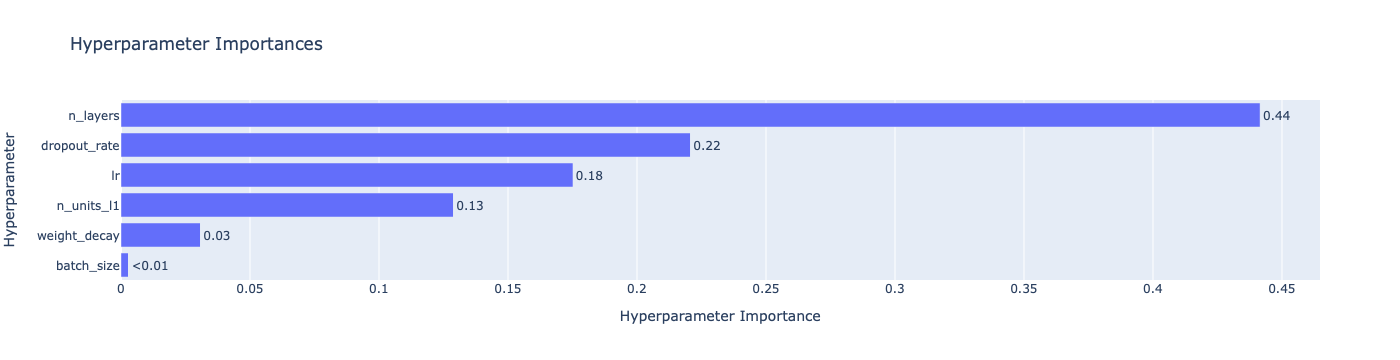

In [12]:
#optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)


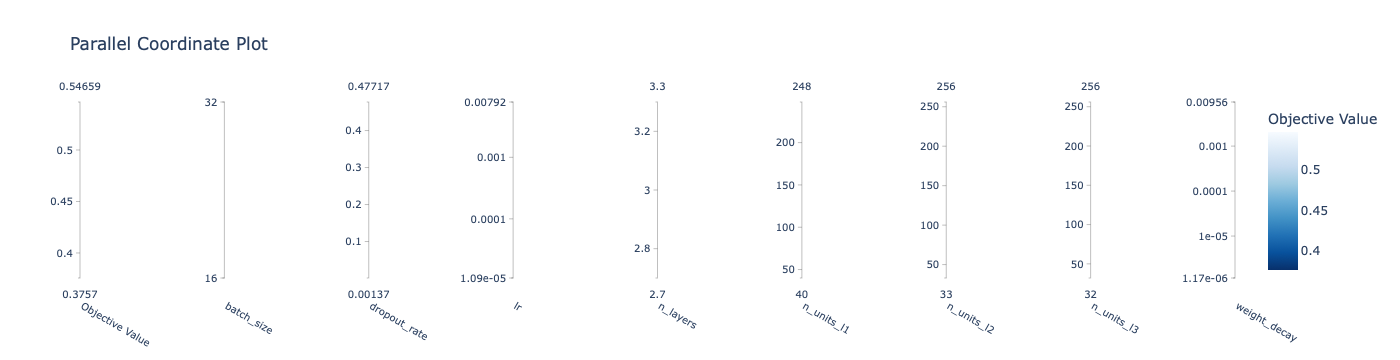

In [13]:
optuna.visualization.plot_parallel_coordinate(study)

In [10]:
plt.figure(figsize=(10, 6))
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../../training_plot_normalized.png")
plt.show()

NameError: name 'epochs' is not defined

<Figure size 720x432 with 0 Axes>

In [ ]:
model.eval()
predictions, true_values = [], []

with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        
        predictions.append(preds.cpu())
        true_values.append(yb.cpu())

all_predictions = torch.cat(predictions).numpy()
all_true_values = torch.cat(true_values).numpy()

all_predictions = all_predictions * stds + means
all_true_values = all_true_values * stds + means
all_predictions[:, logflag] = np.exp(all_predictions[:, logflag])
all_true_values[:, logflag] = np.exp(all_true_values[:, logflag])

In [ ]:
# Create figure with subplots
#Npanels=[5,7]
Npanels=[3,2]
fig, axes = plt.subplots(nrows=Npanels[0], ncols=Npanels[1], figsize=(25,25))
for i in range(Npanels[0]):
    for j in range(Npanels[1]):
        ax = axes[i, j]

        predictions = all_predictions[:,i*Npanels[1]+j]
        true_values = all_true_values[:,i*Npanels[1]+j]
        
        ax.scatter(true_values, predictions, alpha=0.6)
        r2 = r2_score(true_values, predictions)
        rmse = np.sqrt(mean_squared_error(true_values, predictions))

        # Plotting ideal prediction line
        min_val = min(true_values.min(), predictions.min())
        max_val = max(true_values.max(), predictions.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

        ax.set_xlabel('True Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(f'R² = {r2:.3f}, RMSE = {rmse:.3f}')
        ax.grid(True)
        ax.set_xlim(origParameters.min(axis=0)[i*Npanels[1]+j]-(origParameters.max(axis=0)[i*Npanels[1]+j]-origParameters.min(axis=0)[i*Npanels[1]+j])*0.1, origParameters.max(axis=0)[i*Npanels[1]+j]+(origParameters.max(axis=0)[i*Npanels[1]+j]-origParameters.min(axis=0)[i*Npanels[1]+j])*0.1)
        ax.set_ylim(origParameters.min(axis=0)[i*Npanels[1]+j]-(origParameters.max(axis=0)[i*Npanels[1]+j]-origParameters.min(axis=0)[i*Npanels[1]+j])*0.1, origParameters.max(axis=0)[i*Npanels[1]+j]+(origParameters.max(axis=0)[i*Npanels[1]+j]-origParameters.min(axis=0)[i*Npanels[1]+j])*0.1)

plt.tight_layout()
plt.savefig("../../results_plot_normalized.png")
plt.show()

In [ ]:
# for the case of just one output

predictions = all_predictions
true_values = all_true_values

r2 = r2_score(true_values, predictions)
rmse = np.sqrt(mean_squared_error(true_values, predictions))

plt.figure(figsize=(7, 7))
plt.scatter(true_values, predictions, alpha=0.6)

# Plotting ideal prediction line
min_val = min(true_values.min(), predictions.min())
max_val = max(true_values.max(), predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'R² = {r2:.3f}, RMSE = {rmse:.3f}')
plt.grid(True)
plt.xlim(origParameters.min()-(origParameters.max()-origParameters.min())*0.1, origParameters.max()+(origParameters.max()-origParameters.min())*0.1)
plt.ylim(origParameters.min()-(origParameters.max()-origParameters.min())*0.1, origParameters.max()+(origParameters.max()-origParameters.min())*0.1)
plt.tight_layout()
plt.show()